# Conformer Generation Pipeline

## **Step 1: Input Smile and Reference Conformer**

In [1]:
import time

# Capture the start time
start_time: float = time.time()

In [2]:
import sys

# Add a folder to Python's import path
sys.path.append('/app')

In [3]:
from atk_conformer_generation_pipeline.utils import *
from atk_conformer_generation_pipeline.variables import *
import os
import glob
import re
import subprocess
from pyscf import gto
from pyscf.geomopt import geometric_solver
from gpu4pyscf.dft import rks
from pyscf.hessian import thermo
from termcolor import colored

In [4]:
#Change the dir to /work
os.chdir("/work")
!pwd

/work


**Change the below variables accordingly**

In [5]:
inp_smiles: str="NC(=O)CO"
dielectric_value: float=46.826
output_dir: str="SMILE2"
num_conf: int = 1000     # Number of conformers to be generated
E_avg_proton: float=-277.60  # E_H (solv) in kcal/mol
pKa_EXP: float=23.00 # Experimental pKa

In [6]:
os.makedirs(output_dir, exist_ok=True)
os.chdir(output_dir)

In [7]:
!pwd

/work/SMILE2


In [8]:
import sys
sys.setrecursionlimit(10000)
# set the maximum depth of the Python interpreter stack. This stack depth is crucial for recursive function calls, 
# as it limits how deep the recursion can go before causing a RecursionError.

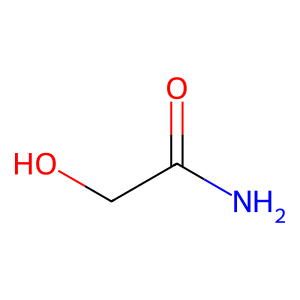

In [9]:
display_2d_structure(inp_smiles)


**Importing the necessary libraries**

In [10]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import shutil
import time
import os
import re
import shutil
import pandas as pd
import numpy as np
from numpy import loadtxt
import csv
from typing import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from matplotlib.gridspec import GridSpec

In [11]:
%%time

### Remove all files and directories created in the previous execution to avoid any confusion

file_and_dir_to_remove: List[str]=[init_conf_xyz,opt_conf_xyz,opt_conf_energy_csv,opt_conf_SMILES_file,similarity_output_csv,
feasible_geometries_csv,infeasible_geometries_csv,feasible_geometries_xyz,infeasible_geometries_xyz,pairwise_RMSDs_dat,
pairwise_RMSDs_csv,cluster_reps_csv,cluster_reps_xyz,cluster_rep_prefix,cluster_reps_dir,clusters_RMSD_stats_csv,clusters_energy_stats_csv,
opt_cluster_reps_csv]

remove_paths(file_and_dir_to_remove)

The path initial_generated_conformers.sdf does not exist.
The path optimized_generated_conformers.sdf does not exist.
The path opt_conf_energies.csv does not exist.
The path optimized_generated_conformers.smi does not exist.
The path tanimoto_similarity.csv does not exist.
The path feasible_geom_energies.csv does not exist.
The path infeasible_geometries.csv does not exist.
The path feasible_geometries.xyz does not exist.
The path infeasible_geometries.xyz does not exist.
The path rmsd_matrix-mx_flags.dat does not exist.
The path pairwise_RMSDs.csv does not exist.
The path cluster_rep_conformers.csv does not exist.
The path cluster_rep_conformers.xyz does not exist.
The path rep_of_cluster_ does not exist.
The path cluster_rep_conformers does not exist.
The path cluster_statistics-RMSDs.csv does not exist.
The path cluster_statistics-energies.csv does not exist.
The path opt_cluster_rep_conformers.csv does not exist.
CPU times: user 304 µs, sys: 159 µs, total: 463 µs
Wall time: 369 µs


## **Step 2: Generating Conformers**

Generating conformers for a given molecule using the RDKit-ETKDG method.

In [12]:
%%time

import time
import sys


mol: Chem.Mol= generate_conformers(inp_smiles, num_conf)  # Call the function to generate conformers
save_conformers_to_sdf(mol, init_conf_sdf)       # Save conformers to SDF file



CPU times: user 805 ms, sys: 8.49 ms, total: 814 ms
Wall time: 402 ms


In [13]:
# Find the number of atoms in the molecule
num_atoms_generated_conf: int = mol.GetNumAtoms()

## **Step 3: Optimizing Conformers**

In [14]:
%%time

### Optimize the generated conformers and save the optimized coordinates
opt_mol, conformer_energies = mmff_optimize_conformers(mol)     # Call the function to optimize conformers
save_conformers_to_sdf(opt_mol,opt_conf_sdf)
# print(conformer_energies)

num_opt_conf: int= opt_mol.GetNumConformers()


### Save the energies of optimized to a CSV file
conformer_energies_items : List[Tuple[int, float]] = list(conformer_energies.items())
energy_DF: pd.DataFrame = pd.DataFrame(conformer_energies_items, columns=['conformer_id', 'energy_in_kcalpermol'])
energy_DF.to_csv(opt_conf_energy_csv, index=False)

CPU times: user 2.43 s, sys: 5.01 ms, total: 2.44 s
Wall time: 2.44 s


In [15]:
%%time

### Convert the 3D gometries of conformers into SMILES and save them
convert_conformers_to_smiles(opt_conf_sdf,opt_conf_SMILES_file)

CPU times: user 72.9 ms, sys: 3.24 ms, total: 76.2 ms
Wall time: 75.7 ms


In [16]:
### Process optimized conformers to calculate Tanimoto similarity and separate feasible and infeasible geometries.
infeasible_geom_DF, energy_DF=process_conformers(opt_conf_SMILES_file,opt_conf_sdf,feasible_geometries_sdf,infeasible_geometries_sdf,similarity_output_csv,infeasible_geometries_csv,inp_smiles,num_opt_conf,energy_DF)


In [17]:
%%time

### Calculate the numbers of conformers with feasible and infeasible geometries
num_feasible_geom: int = len(energy_DF)
num_infeasible_geom: int = len(infeasible_geom_DF)

with open("outputs.txt", 'a') as file:
    file.write(f'Number_of_feasible_geometries: {num_feasible_geom}\n')
    
print("Number of conformers with infeasible geometries:", num_infeasible_geom)
print("Number of conformers with feasible geometries:", num_feasible_geom)
print("Total number of conformers for which the geometry feasibility was checked:", num_infeasible_geom+num_feasible_geom)
print("Total number of conformers generated:", num_conf)

Number of conformers with infeasible geometries: 0
Number of conformers with feasible geometries: 1000
Total number of conformers for which the geometry feasibility was checked: 1000
Total number of conformers generated: 1000
CPU times: user 688 µs, sys: 0 ns, total: 688 µs
Wall time: 461 µs


In [18]:
%%time

### Calculate the relative energies of conformers and write the results to a CSV file.
rel_energy_DF: pd.DataFrame=calculate_relative_energies(energy_DF,feasible_geometries_csv)


CPU times: user 6.79 ms, sys: 923 µs, total: 7.72 ms
Wall time: 7.08 ms


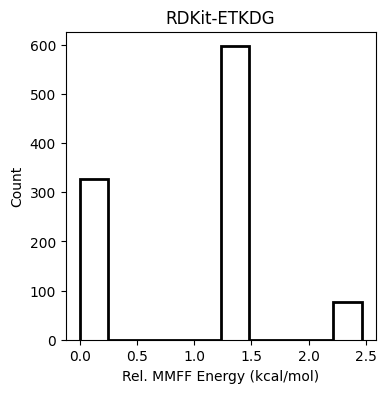

CPU times: user 369 ms, sys: 1.11 s, total: 1.48 s
Wall time: 185 ms


In [19]:
%%time

fig = plt.figure(figsize=(4, 4))

### Plot the relative energy distribution for conformers with feasible geometries
n_bins=10
plt.hist(rel_energy_DF['rel_energy_in_kcalpermol'], bins=n_bins, density=False, color='black', histtype='step', fill=False, lw=2)
#density=False: If True, the histogram is normalized so that the area under the histogram integrates to 1. If False, the histogram represents the count of occurrences in each bin.
#'bar': Traditional bar histogram (default)
plt.xlabel('Rel. MMFF Energy (kcal/mol)')
plt.ylabel('Count')
plt.title('RDKit-ETKDG')
plt.grid(False)

### Show the plot
plt.show()

### Save figure
fig.savefig("rel_MMFF_energies-count_histogram", bbox_inches='tight', pad_inches=0.04, transparent = False)

## **Step 4: Calculating RMSD Matrix**

Using Open Babel obrms command to calculate the Root Mean Square Deviation (RMSD) between the feasiable geometries present in an SDF file

In [20]:
%%time

### Run obrms on the concatenated sdf file of conformers with feasible geometries to compute RMSD matrix
calculate_rmsd(feasible_geometries_sdf,pairwise_RMSDs_dat)

RMSD calculation completed and appended to rmsd_matrix-mx_flags.dat.
CPU times: user 1.61 ms, sys: 19 ms, total: 20.6 ms
Wall time: 3.66 s


In [21]:
%%time

from scipy.spatial.distance import squareform, is_valid_dm

### Read the pairwise RMSD matrix from the output of obrms; it is supposed to be a hollow, asymmetric matrix
rmsd_matrix_DF: pd.DataFrame = pd.read_csv(pairwise_RMSDs_dat, header=None, index_col=0)

### Convert the pairwise RMSD matrix into a numpy float-type 2D array
rmsd_matrix: np.ndarray = rmsd_matrix_DF.to_numpy(dtype=float)

### Round the matrix elements to two decimal places to avoid possible asymmetry in the matrix due to insignificant numerical errors
rmsd_matrix_2DP: np.ndarray  = np.round(rmsd_matrix, 2)

# Force the matrix to be symmetric
rmsd_matrix_2DP = (rmsd_matrix_2DP + rmsd_matrix_2DP.T) / 2

# Check if the matrix is symmetric
if not is_valid_dm(rmsd_matrix_2DP, throw=False):
    raise ValueError("The provided RMSD matrix is not symmetric even after rounding and forcing symmetry.")

CPU times: user 141 ms, sys: 55.3 ms, total: 196 ms
Wall time: 195 ms


In [22]:
%%time

### Convert the the pairwise distance matrix to its condensed form; write the pairwise RMSDs from the condensed matrix into a CSV file
from scipy.spatial.distance import squareform
condensed_matrix: np.ndarray  = squareform(rmsd_matrix_2DP)
pairwise_RMSDs_DF: pd.DataFrame = pd.DataFrame(condensed_matrix)
pairwise_RMSDs_DF.to_csv(pairwise_RMSDs_csv, header=['pairwise_RMSD'], index=False)

CPU times: user 279 ms, sys: 37.5 ms, total: 317 ms
Wall time: 318 ms


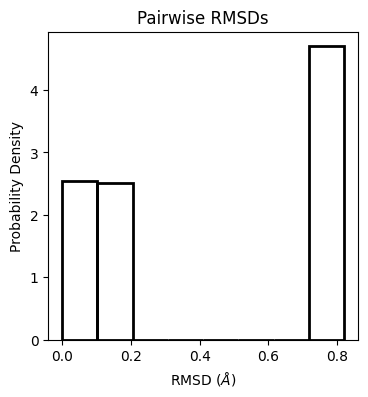

CPU times: user 419 ms, sys: 1.1 s, total: 1.52 s
Wall time: 217 ms


In [23]:
%%time

### Plot the distribution of pairwise RMSDs
fig = plt.figure(figsize=(4, 4))

### Plot the histograms
plt.hist(condensed_matrix, bins=8, density=True, color='black', fill=False, lw=2)

### Format the axes
plt.xlabel(r'RMSD ($\AA)$')
plt.ylabel('Probability Density')
plt.title('Pairwise RMSDs')
plt.grid(False)

### Show the plot
plt.show()

### Save figure
fig.savefig("pairwise_rmsd_distribution-PD.png", bbox_inches='tight', pad_inches=0.04, transparent = False)

## **Step 5: Hierarchical Cluster**

Clustering the generated conformers into 20 clusters using hierarchical clustering with `ward` linkage method. 

In [24]:
%%time

### Perform hierarchical clustering with 'ward' linkage method on the condensed version of pairwise distance matrix
import scipy.cluster.hierarchy as sch
linkage_matrix_ward: np.ndarray = sch.linkage(condensed_matrix, method='ward')

CPU times: user 12.8 ms, sys: 920 µs, total: 13.8 ms
Wall time: 13.1 ms


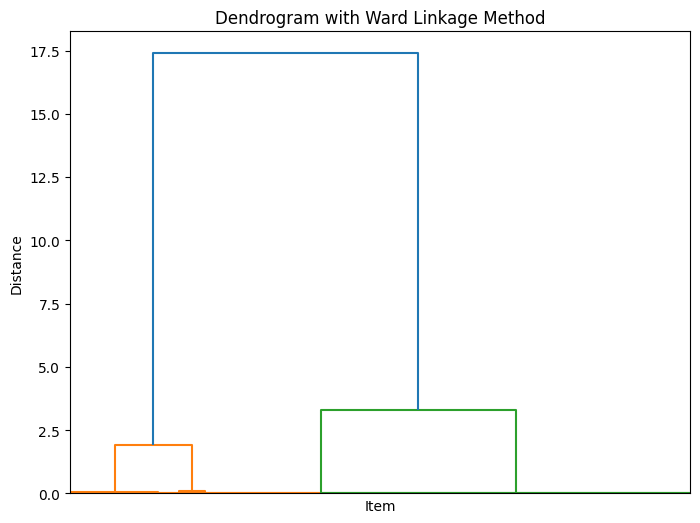

CPU times: user 198 ms, sys: 168 ms, total: 367 ms
Wall time: 180 ms


In [25]:
%%time

### A few settings to export the image of the plot
plt.style.use('default')
fig = plt.figure(figsize=(8, 6))

### Plot the dendrogram to visualize the hierarchical clustering structure
sch.dendrogram(linkage_matrix_ward, no_labels=True)
plt.title('Dendrogram with Ward Linkage Method')
plt.xlabel('Conformers')
plt.ylabel('Distance')
#plt.xticks(np.arange(0, 1000, 200))

### Show the plot
plt.show()

### Save figure
fig.savefig("hierarchical_clustering_dendogram-ward.png", bbox_inches='tight', pad_inches=0.04, transparent = False)

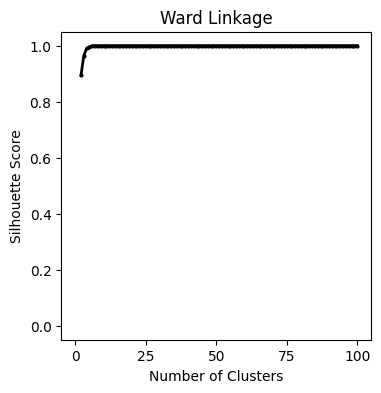

The optimal number of clusters is 6 with a silhouette score of 1.0
CPU times: user 1.16 s, sys: 187 ms, total: 1.35 s
Wall time: 1.17 s


In [26]:
%%time

### A few settings to export the image of the plot
# plt.style.use('~/matplotlib_templates/single_column.mplstyle')
fig = plt.figure(figsize=(4, 4))

### Determine the optimal number of clusters using silhouette score; the original pairwise RMSD matrix must be used for this
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster
from collections import Counter


## Calculate silhouette score for different numbers of clusters
sil_scores = []
range_n_clusters = list(range(2, 101))     # Try different numbers of clusters
for n_clusters in range_n_clusters:
    cluster_labels = fcluster(linkage_matrix_ward, n_clusters, criterion='maxclust')
    cluster_counts = Counter(cluster_labels)
    # print(cluster_counts)
    
    # Check if the clustering resulted in more than one cluster
    if len(cluster_counts) > 1:
        sil_score = silhouette_score(rmsd_matrix_2DP, cluster_labels, metric='precomputed')
        sil_scores.append(sil_score)
    else:
        sil_scores.append(float('-inf'))  # Append a very low score if there's only one cluster    


## Plot the Silhouette scores
plt.plot(range_n_clusters, sil_scores, marker='o', color='black', fillstyle='none', ms=2, lw=2)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Ward Linkage")
plt.axis([-5, 105, -0.05, 1.05])
plt.xticks([0, 25, 50, 75, 100])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

### Show the plot
plt.show()

### Save figure
fig.savefig("silhouette_score_vs_num_clust-ward.png", bbox_inches='tight', pad_inches=0.04, transparent = False)

## Find the optimal number of clusters based on the maximum value of silhouette score and printing it
max_sil_score = np.max(sil_scores)
optimal_clusters = range_n_clusters[np.argmax(sil_scores)]
print(f"The optimal number of clusters is {optimal_clusters} with a silhouette score of {max_sil_score}")

In [27]:
%%time

from scipy.cluster.hierarchy import linkage, fcluster

num_clusters = 5 if optimal_clusters > 5 else optimal_clusters

## For each conformer, assign the cluster label to which it belongs
cluster_labels: np.ndarray = fcluster(linkage_matrix_ward, num_clusters, criterion='maxclust')

## Create an empty dictionary to store the cluster sets
clusters: Dict[int, List[int]] = {i: [] for i in range(1, num_clusters + 1)}

## Assign each cluster label to the respective cluster set
for index, label in enumerate(cluster_labels):
    clusters[label].append(index)     # Store the indices instead of raw data
    

CPU times: user 3.57 ms, sys: 0 ns, total: 3.57 ms
Wall time: 3.47 ms


## **Step 6: Identifying Cluster Representative**

Identifying the minimum energy conformer within each cluster as its representative

In [28]:
%%time

### Identify the minimum energy conformer within each cluster as its representative

## Loop over all the cluster sets
cluster_reps_list: List[pd.DataFrame] = []

for clust_label, clust_elements in clusters.items():
    if len(clust_elements)!=0:
        clust_DF: pd.DataFrame = rel_energy_DF.loc[clust_elements]     # Extract the relative energies of the cluster elements into a dataframe
        min_energy_index: int = clust_DF['rel_energy_in_kcalpermol'].idxmin()     # Find the row index correspoding to the minimum relative energy conformer within the cluster 
        min_energy_DF: pd.DataFrame= clust_DF.loc[[min_energy_index]]     # Isolate the repesentative conformer's relative energy into a dataframe
        min_energy_DF['cluster_id'] = clust_label     # Add the 'cluster ID' information to the above dataframe
        # print(min_energy_DF)
        cluster_reps_list.append(min_energy_DF)     # Append the dataframe corresponding to each cluster representative into a list of dataframes

## Concatenate the dataframes of all cluster representatives into a single dataframe
cluster_reps_DF: pd.DataFrame = pd.concat(cluster_reps_list, ignore_index=True)

## Sort the cluster respresentatives samples by 'conformer_id' and save the sorted dataframe to a csv file
sorted_cluster_reps_DF: pd.DataFrame = cluster_reps_DF.sort_values(by='conformer_id', ascending=True)
sorted_cluster_reps_DF.to_csv(cluster_reps_csv, index=False)

CPU times: user 9 ms, sys: 1.39 ms, total: 10.4 ms
Wall time: 9.37 ms


In [29]:
%%time

###  Write the coordinates of cluster representative conformers to SDF files.
write_cluster_representatives(opt_conf_sdf,cluster_reps_dir,cluster_reps_sdf,sorted_cluster_reps_DF,cluster_reps_DF,cluster_rep_prefix,conf_extension)



Completed Writing the SDF files of cluster representative conformers
CPU times: user 92.1 ms, sys: 3.59 ms, total: 95.7 ms
Wall time: 95.1 ms


## **Step 7: Calculating the Minimum RMSD**

Calculating the min rmsd between refrence conformer and cluster representatives.

# calculating the min rmsd between refrence conformer and cluster representatives
result: float = calculate_min_rmsd(f"../{ref_confo_path}",cluster_reps_sdf)
print(f"Min RMSD 20 Clusters: {result}")

# Append the result to the text file
with open('outputs.txt', 'a') as file:
    file.write(f'Min_RMSD_20_cluster : {result}\n')

# Step 8: Geometry optimization of neutral conformers using DFT

In [30]:
def get_atom_list(sdf_file):
    molecules = Chem.SDMolSupplier(sdf_file, removeHs=False)
    mol = next(molecules)  # Assuming you have one molecule in the SDF

    # Get the first conformer to access 3D coordinates
    conformer = mol.GetConformer()

    # Extract atomic symbols and coordinates
    atom_list = []
    for atom in mol.GetAtoms():
        pos = conformer.GetAtomPosition(atom.GetIdx())
        atom_list.append((atom.GetSymbol(), (pos.x, pos.y, pos.z)))
    return atom_list


def opti_PCM(mol, eps, xyz_filename, charge_filename, xc):
    start_time = time.time()
    # Set up the DFT calculation
    mf = rks.RKS(mol).density_fit()  # Use density fitting for efficiency
    mf.xc = xc  # Set the exchange-correlation functional

    # SCF convergence Criteria
    mf.conv_tol = 1e-8  # Energy convergence
    mf.conv_tol_grad = 3e-4  # Gradient convergence
    mf.max_cycle = 70  # Increase max iterations if needed

    # Apply the solvation model
    mf = mf.PCM()  # Initialize solvation model
    mf.grids.atom_grid = (99, 590)
    mf.with_solvent.lebedev_order = 29  # 302 Lebedev grids
    mf.with_solvent.method = 'IEF-PCM'  # Can be C-PCM, SS(V)PE, COSMO
    mf.with_solvent.eps = eps  # Set the solvent's dielectric constant

    # Perform geometry optimization
    print("Starting geometry optimization...")
    mol_opt = geometric_solver.optimize(mf, max_steps=200, xtol=1e-8, gtol=3e-4, etol=1e-8)

    # Output optimized geometry
    optimized_atoms = [(atom[0], mol_opt.atom_coords(unit='Angstrom')[i]) for i, atom in enumerate(mol_opt.atom)]

    # Ensure SCF calculation is performed after optimization
    mf_scf = rks.RKS(mol_opt).density_fit()
    mf_scf.xc = xc

    # SCF convergence Criteria
    mf_scf.conv_tol = 1e-8  # Energy convergence
    mf_scf.conv_tol_grad = 3e-4  # Gradient convergence
    mf_scf.max_cycle = 70  # Increase max iterations if needed

    # Apply the solvation model
    mf_scf = mf_scf.PCM()  # Initialize solvation model
    mf_scf.grids.atom_grid = (99, 590)
    mf_scf.with_solvent.lebedev_order = 29  # 302 Lebedev grids
    mf_scf.with_solvent.method = 'IEF-PCM'  # Can be C-PCM, SS(V)PE, COSMO
    mf_scf.with_solvent.eps = eps  # Set the solvent's dielectric constant

    #Run the scf
    mf_scf.kernel()

    #Mulliken Charge Analysis
    analysis = mf_scf.analyze()
    mulliken_charges = analysis[0][1]  # Get the Mulliken charges

    # Save captured output to file
    with open(charge_filename, "w") as charge_file:
        charge_file.write("Atom Index  Atom Symbol  Mulliken Charge\n")
        for i, charge in enumerate(mulliken_charges):
            atom_symbol = mol.atom_symbol(i)  # Get the atom symbol
            charge_file.write(f"{i+1}             {atom_symbol}        {charge:.6f}\n")


    # Extract the final energy in Hartree
    final_energy_hartree = mf_scf.e_tot

    # Convert energy from Hartree to kJ/mol
    #hartree_to_kjmol = 2625.5
    hartree_to_kcalmol=627.509
    final_energy_kcalmol = final_energy_hartree * hartree_to_kcalmol

    # Save optimized geometry to XYZ file
    with open(xyz_filename, 'w') as xyz_file:
        xyz_file.write(f"{len(optimized_atoms)}\n")
        xyz_file.write(f"Energy: {final_energy_kcalmol:.6f} kcal/mol\n")
        for symbol, coords in optimized_atoms:
            formatted_coords = ' '.join(f"{coord:.8f}" for coord in coords)
            xyz_file.write(f"{symbol} {formatted_coords}\n")

    print(f"Optimized geometry saved to '{xyz_filename}'.")

    # Print the final energy
    print(f"Final energy: {final_energy_hartree:.8f} Hartree ({final_energy_kcalmol:.6f} kcal/mol)")

    # Record the end time
    opt_time = time.time()

    # Calculate and print the total run time
    total_opt_time = opt_time - start_time
    print(f"\nOPT Time: {total_opt_time:.2f} seconds")

    print("################################################################")
    return mol_opt

In [31]:
!export LD_LIBRARY_PATH=/opt/conda/lib:$LD_LIBRARY_PATH

In [32]:
def extract_charge_info(sdf_path):
    """
    Extracts total formal charge from M  CHG lines in a .sdf file.
    If no M  CHG line is found, assumes formal charge = 0.
    """
    charges = {}
    with open(sdf_path) as f:
        for line in f:
            if line.startswith("M  CHG"):
                tokens = line.strip().split()
                n_entries = int(tokens[2])
                for i in range(n_entries):
                    atom_idx = int(tokens[3 + i * 2])
                    charge = int(tokens[4 + i * 2])
                    charges[atom_idx] = charge

    if charges:
        formal_charge = sum(charges.values())
    else:
        formal_charge = 0  # Default if no charge info present

    #print(f"{os.path.basename(sdf_path)}: formal charge = {formal_charge}")
    return formal_charge


In [33]:
# Define basis sets and XC functionals to loop over
basis_sets = ['aug-cc-pVDZ']
xc_functionals = ['M06-2X']  # Add more if needed

# Get list of charged SDF files
sdf_files = sorted(glob.glob(os.path.join(cluster_reps_dir, "*.sdf")))
if not sdf_files:
    print(colored(f"No SDF files found in {cluster_reps_dir}", "yellow"))


# Loop over each SDF file
for sdf_path in sdf_files:
    atom_list = get_atom_list(sdf_path)

    for basis in basis_sets:
        for xc in xc_functionals:
            start_time_sub = time.time()

            # Build molecule with given basis
            mol1 = gto.M(
                atom=atom_list,
                basis=basis,
                charge=extract_charge_info(sdf_path),
                spin=0,
                verbose=4,
            )

            # Sanitize names for filename safety
            basis_tag = basis.replace("(", "").replace(")", "").replace("*", "").replace("+", "").replace("/", "-").replace(" ", "")
            xc_tag = xc.replace("(", "").replace(")", "").replace("*", "").replace("+", "").replace("/", "-").replace(" ", "")

            # Output file names
            xyz_filename = sdf_path.replace('.sdf', f'_{basis_tag}_{xc_tag}.xyz')
            charge_filename = sdf_path.replace('.sdf', f'_{basis_tag}_{xc_tag}.charge')

            # Call your optimization/PCM function
            A = opti_PCM(mol1, dielectric_value, xyz_filename, charge_filename, xc)

            print(colored(f"Finished {os.path.basename(sdf_path)} | basis: {basis} | xc: {xc} in {time.time() - start_time_sub:.2f} s", "green"))


System: uname_result(system='Linux', node='910ac71e58c9', release='6.11.0-9-generic', version='#9-Ubuntu SMP PREEMPT_DYNAMIC Mon Oct 14 13:19:59 UTC 2024', machine='x86_64')  Threads 15
Python 3.9.18 | packaged by conda-forge | (main, Dec 23 2023, 16:33:10) 
[GCC 12.3.0]
numpy 1.26.4  scipy 1.13.1  h5py 3.12.1
Date: Tue Jun 17 10:45:57 2025
PySCF version 2.7.0
PySCF path  /opt/conda/lib/python3.9/site-packages/pyscf/__init__.py
CUDA Environment
    CuPy 13.3.0
    CUDA Path /usr/local/cuda
    CUDA Build Version 12060
    CUDA Driver Version 12080
    CUDA Runtime Version 12060
CUDA toolkit
    cuSolver (11, 7, 2)
    cuBLAS 120803
    cuTENSOR 20002
Device info
    Device name b'Tesla V100S-PCIE-32GB'
    Device global memory 31.73 GB
    CuPy memory fraction 0.9
    Num. Devices 1
GPU4PySCF 1.3.1
GPU4PySCF path  /opt/conda/lib/python3.9/site-packages/gpu4pyscf_cuda12x-1.3.1-py3.9.egg/gpu4pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 10
[INPUT] num. electrons

geometric-optimize called with the following command line:
/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py --f=/root/.local/share/jupyter/runtime/kernel-v2-299qr6b12Yp3KBl.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********      .))))))  
         


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.383400   0.155800  -0.197700    0.000000  0.000000  0.000000
   C   0.324900  -0.703700  -0.305700    0.000000  0.000000  0.000000
   O   0.445300  -1.807400  -0.823200    0.000000  0.000000  0.000000
   C  -0.988200  -0.170500   0.268000    0.000000  0.000000 -0.000000
   O  -0.940700   1.222200   0.559500    0.000000  0.000000  0.000000
   H   2.295200  -0.212400  -0.434800   -0.000000  0.000000  0.000000
   H   1.329700   0.899900   0.489400    0.000000  0.000000  0.000000
   H  -1.792600  -0.349400  -0.451400    0.000000  0.000000  0.000000
   H  -1.202700  -0.708200   1.195700    0.000000  0.000000  0.000000
   H  -0.854300   1.673700  -0.299700    0.000000  0.000000  0.000000
New geometry
   1 N      1.383400000000   0.155800000000  -0.197700000000 AA    2.614247120723   0.294419330207  -0.373598854827 Bohr

   2 C      0.324900000000  -0.703700

Step    0 : Gradient = 1.003e-02/2.164e-02 (rms/max) Energy = -284.3821112687
Hessian Eigenvalues: 2.30000e-02 2.30000e-02 2.30000e-02 ... 5.13979e-01 5.24791e-01 9.32314e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.377648   0.146904  -0.196732   -0.005752 -0.008896  0.000968
   C   0.342082  -0.724169  -0.296852    0.017182 -0.020469  0.008848
   O   0.353593  -1.846573  -0.792123   -0.091707 -0.039173  0.031077
   C  -0.968762  -0.170541   0.243471    0.019438 -0.000041 -0.024529
   O  -0.917222   1.208190   0.583547    0.023478 -0.014010  0.024047
   H   2.313094  -0.184646  -0.393635    0.017894  0.027754  0.041165
   H   1.280136   0.952263   0.407655   -0.049564  0.052363 -0.081745
   H  -1.754879  -0.388564  -0.491207    0.037721 -0.039164 -0.039807
   H  -1.192570  -0.714947   1.167418    0.010130 -0.006747 -0.028282
   H  -0.830354   1.721811  -0.230386    0.023946  0.048111  0.069314
New geometry
   1 N      1.377647750965   0.146904354200  -0.196731796427 AA    2.603376945447   0.277608995944  -0.371769215240 Bohr

   2 C      0.342082024273  -0.724169

<class 'gpu4pyscf.solvent.pcm.PCM'> does not have attributes  v_grids_n


<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021303968156198
Solvent Energy = -0.021303968156198
init E= -284.387125737934
<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0222895470219462
Solvent Energy = -0.0222895470219462
cycle= 1 E= -284.38286861444  delta_E= 0.00426  |ddm|= 0.425
<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.021579530105774
Solvent Energy = -0.021579530105774
cycle= 2 E= -284.383112207227  delta_E= -0.000244  |ddm|= 0.0742
<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.022271609612865
Solvent Energy = -0.022271609612865
cycle= 3 E= -284.383278282126  delta_E= -0.000166  |ddm|= 0.0317
<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0220607796728484
Solvent Energy = -0.0220607796728484
cycle= 4 E= -284.383320570004  delta_E= -4.23e-05  |ddm|= 0.0132
<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0220830917179799
Solvent Energy = -0.0220830917179799
cycle= 5 E= -284.383322093048  delta_E= -1.52e-06  |ddm|= 0.00356
<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -

Step    1 : Displace = 6.478e-02/1.094e-01 (rms/max) Trust = 1.000e-01 (=) Grad = 8.339e-03/1.684e-02 (rms/max) E (change) = -284.3833222673 (-1.211e-03) Quality = 0.517
Hessian Eigenvalues: 1.93555e-02 2.30000e-02 2.30841e-02 ... 5.15973e-01 6.89567e-01 9.31409e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.418437   0.102631  -0.199994    0.040789 -0.044273 -0.003262
   C   0.343568  -0.700624  -0.272016    0.001486  0.023546  0.024836
   O   0.390707  -1.825739  -0.762534    0.037113  0.020834  0.029589
   C  -0.985101  -0.152909   0.234289   -0.016340  0.017632 -0.009182
   O  -0.978858   1.211957   0.612222   -0.061636  0.003768  0.028676
   H   2.349189  -0.248739  -0.387153    0.036095 -0.064093  0.006483
   H   1.342415   0.964418   0.320690    0.062278  0.012156 -0.086965
   H  -1.742009  -0.405170  -0.522733    0.012870 -0.016607 -0.031526
   H  -1.221921  -0.714263   1.147184   -0.029351  0.000684 -0.020234
   H  -0.911133   1.768586  -0.168775   -0.080779  0.046776  0.061611
New geometry
   1 N      1.418436800052   0.102631489706  -0.199994052757 AA    2.680457077102   0.193945407301  -0.377933986252 Bohr

   2 C      0.343567924828  -0.700623

Step    2 : Displace = 6.710e-02/1.133e-01 (rms/max) Trust = 1.000e-01 (=) Grad = 5.904e-03/1.068e-02 (rms/max) E (change) = -284.3839936867 (-6.714e-04) Quality = 0.391
Hessian Eigenvalues: 1.98738e-02 2.30069e-02 2.30994e-02 ... 5.25622e-01 8.00465e-01 9.88985e-01



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.407291   0.122803  -0.189160   -0.011146  0.020171  0.010834
   C   0.344230  -0.695492  -0.286858    0.000662  0.005131 -0.014842
   O   0.399959  -1.826081  -0.769129    0.009252 -0.000342 -0.006595
   C  -0.978560  -0.156318   0.241216    0.006542 -0.003409  0.006927
   O  -0.961060   1.208902   0.603111    0.017797 -0.003055 -0.009111
   H   2.319324  -0.264159  -0.393544   -0.029865 -0.015420 -0.006392
   H   1.344461   0.973531   0.354166    0.002046  0.009113  0.033476
   H  -1.746890  -0.381518  -0.509655   -0.004881  0.023653  0.013078
   H  -1.212176  -0.724411   1.150447    0.009745 -0.010148  0.003263
   H  -0.910011   1.743128  -0.199568    0.001122 -0.025458 -0.030794
New geometry
   1 N      1.407291000162   0.122802624993  -0.189160353651 AA    2.659394567872   0.232063328615  -0.357461262026 Bohr

   2 C      0.344230370655  -0.695492

Step    3 : Displace = 2.544e-02/4.002e-02 (rms/max) Trust = 1.000e-01 (=) Grad = 1.564e-03/2.595e-03 (rms/max) E (change) = -284.3846768923 (-6.832e-04) Quality = 0.939
Hessian Eigenvalues: 1.97384e-02 2.14802e-02 2.30074e-02 ... 5.24538e-01 7.56704e-01 9.37271e-01



Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.400333   0.112078  -0.175643   -0.006958 -0.010724  0.013518
   C   0.341022  -0.710820  -0.283189   -0.003209 -0.015327  0.003669
   O   0.386199  -1.843675  -0.765051   -0.013760 -0.017594  0.004078
   C  -0.974925  -0.159485   0.244388    0.003635 -0.003167  0.003172
   O  -0.929253   1.205500   0.600838    0.031807 -0.003402 -0.002272
   H   2.330479  -0.211786  -0.405446    0.011155  0.052373 -0.011902
   H   1.306992   0.968927   0.353924   -0.037469 -0.004604 -0.000242
   H  -1.747362  -0.360989  -0.508367   -0.000472  0.020529  0.001289
   H  -1.219364  -0.729743   1.148865   -0.007188 -0.005332 -0.001582
   H  -0.886314   1.731748  -0.209511    0.023697 -0.011380 -0.009943
New geometry
   1 N      1.400333006534   0.112078279120  -0.175642665266 AA    2.646245865538   0.211797252048  -0.331916533142 Bohr

   2 C      0.341021587214  -0.710819

Step    4 : Displace = 2.812e-02/5.447e-02 (rms/max) Trust = 1.414e-01 (+) Grad = 1.558e-03/2.228e-03 (rms/max) E (change) = -284.3848009132 (-1.240e-04) Quality = 0.546
Hessian Eigenvalues: 1.31239e-02 2.21298e-02 2.30311e-02 ... 5.25497e-01 8.01728e-01 9.60806e-01



Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.405979   0.106911  -0.167185    0.005646 -0.005167  0.008458
   C   0.346216  -0.711013  -0.274032    0.005195 -0.000193  0.009157
   O   0.393250  -1.845265  -0.754179    0.007051 -0.001590  0.010872
   C  -0.974327  -0.157273   0.241016    0.000598  0.002213 -0.003372
   O  -0.933348   1.205522   0.608981   -0.004095  0.000021  0.008143
   H   2.328018  -0.229739  -0.409876   -0.002461 -0.017953 -0.004430
   H   1.317874   0.982566   0.330188    0.010882  0.013639 -0.023736
   H  -1.738119  -0.359962  -0.521044    0.009243  0.001027 -0.012677
   H  -1.228134  -0.732748   1.139574   -0.008770 -0.003004 -0.009291
   H  -0.906307   1.743028  -0.193495   -0.019993  0.011280  0.016016
New geometry
   1 N      1.405979027789   0.106911240880  -0.167184893597 AA    2.656915299404   0.202032964901  -0.315933661064 Bohr

   2 C      0.346216304515  -0.711012

Step    5 : Displace = 1.709e-02/2.931e-02 (rms/max) Trust = 1.414e-01 (=) Grad = 9.517e-04/1.730e-03 (rms/max) E (change) = -284.3849838591 (-1.829e-04) Quality = 1.458
Hessian Eigenvalues: 6.59400e-03 2.22394e-02 2.30251e-02 ... 5.24985e-01 7.66173e-01 9.39707e-01



Geometry optimization cycle 7
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.415898   0.095729  -0.148311    0.009919 -0.011183  0.018874
   C   0.353449  -0.712939  -0.263520    0.007233 -0.001927  0.010513
   O   0.404484  -1.852694  -0.732204    0.011234 -0.007428  0.021975
   C  -0.972035  -0.155001   0.236501    0.002292  0.002271 -0.004515
   O  -0.929492   1.203611   0.621115    0.003856 -0.001911  0.012134
   H   2.327399  -0.246334  -0.420022   -0.000619 -0.016595 -0.010146
   H   1.327997   0.999877   0.293202    0.010123  0.017311 -0.036985
   H  -1.723516  -0.347789  -0.540416    0.014603  0.012173 -0.019372
   H  -1.245569  -0.737812   1.124603   -0.017435 -0.005064 -0.014972
   H  -0.938981   1.753074  -0.172649   -0.032674  0.010046  0.020846
New geometry
   1 N      1.415898164623   0.095728740538  -0.148310638284 AA    2.675659751412   0.180901101867  -0.280266487716 Bohr

   2 C      0.353449216865  -0.712939

Step    6 : Displace = 2.570e-02/4.256e-02 (rms/max) Trust = 2.000e-01 (+) Grad = 9.776e-04/1.959e-03 (rms/max) E (change) = -284.3851059524 (-1.221e-04) Quality = 1.158
Hessian Eigenvalues: 4.66684e-03 2.23117e-02 2.30236e-02 ... 5.75836e-01 7.90602e-01 9.32019e-01



Geometry optimization cycle 8
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.419398   0.090813  -0.142174    0.003499 -0.004916  0.006137
   C   0.355501  -0.716504  -0.259506    0.002051 -0.003565  0.004014
   O   0.406187  -1.857620  -0.724342    0.001703 -0.004927  0.007862
   C  -0.970483  -0.155134   0.235582    0.001551 -0.000133 -0.000920
   O  -0.923378   1.203141   0.623491    0.006114 -0.000470  0.002375
   H   2.330454  -0.244077  -0.424090    0.003054  0.002257 -0.004068
   H   1.326463   1.002602   0.282356   -0.001534  0.002724 -0.010846
   H  -1.718319  -0.340180  -0.546478    0.005197  0.007609 -0.006062
   H  -1.251962  -0.739824   1.119818   -0.006393 -0.002012 -0.004785
   H  -0.950500   1.754808  -0.168406   -0.011519  0.001734  0.004242
New geometry
   1 N      1.419397528303   0.090812501163  -0.142173527011 AA    2.682272590377   0.171610755886  -0.268669028215 Bohr

   2 C      0.355500588598  -0.716503

Step    7 : Displace = 8.559e-03/1.327e-02 (rms/max) Trust = 2.828e-01 (+) Grad = 5.806e-04/1.142e-03 (rms/max) E (change) = -284.3851403193 (-3.437e-05) Quality = 1.540
Hessian Eigenvalues: 3.47638e-03 2.18388e-02 2.30280e-02 ... 5.25570e-01 7.75438e-01 9.26774e-01



Geometry optimization cycle 9
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.422413   0.085651  -0.137929    0.003016 -0.005161  0.004245
   C   0.357309  -0.721167  -0.256419    0.001808 -0.004664  0.003086
   O   0.407144  -1.864313  -0.714805    0.000957 -0.006693  0.009537
   C  -0.968141  -0.155410   0.234230    0.002343 -0.000275 -0.001352
   O  -0.913154   1.202162   0.625199    0.010224 -0.000979  0.001708
   H   2.335553  -0.238000  -0.426316    0.005100  0.006077 -0.002226
   H   1.321435   1.003804   0.271075   -0.005028  0.001203 -0.011282
   H  -1.712326  -0.331141  -0.553041    0.005993  0.009039 -0.006563
   H  -1.258196  -0.741276   1.114802   -0.006234 -0.001452 -0.005016
   H  -0.963693   1.755111  -0.164641   -0.013193  0.000302  0.003765
New geometry
   1 N      1.422413098400   0.085651279162  -0.137928679547 AA    2.687971191970   0.161857459835  -0.260647429067 Bohr

   2 C      0.357308791913  -0.721167

Step    8 : Displace = 9.756e-03/1.459e-02 (rms/max) Trust = 3.000e-01 (+) Grad = 1.743e-04/2.994e-04 (rms/max) E (change) = -284.3851619441 (-2.162e-05) Quality = 1.089
Hessian Eigenvalues: 2.88976e-03 2.09758e-02 2.30518e-02 ... 5.25567e-01 7.71203e-01 9.31619e-01



Geometry optimization cycle 10
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.423387   0.084759  -0.136997    0.000974 -0.000892  0.000932
   C   0.358552  -0.722542  -0.254718    0.001243 -0.001375  0.001701
   O   0.408284  -1.866601  -0.710931    0.001140 -0.002288  0.003874
   C  -0.967224  -0.155339   0.233584    0.000917  0.000071 -0.000645
   O  -0.910702   1.201908   0.625515    0.002452 -0.000254  0.000316
   H   2.336223  -0.237929  -0.427384    0.000670  0.000070 -0.001068
   H   1.321458   1.004867   0.267360    0.000023  0.001062 -0.003715
   H  -1.709823  -0.328715  -0.555666    0.002503  0.002427 -0.002625
   H  -1.260198  -0.742197   1.112541   -0.002002 -0.000922 -0.002261
   H  -0.969258   1.755948  -0.163026   -0.005565  0.000837  0.001615
New geometry
   1 N      1.423386791892   0.084759233710  -0.136997144551 AA    2.689811206000   0.160171738240  -0.258887083048 Bohr

   2 C      0.358551533128  -0.72254

Step    9 : Displace = 3.351e-03/6.272e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 1.347e-04/3.010e-04 (rms/max) E (change) = -284.3851639644 (-2.020e-06) Quality = 1.337
Hessian Eigenvalues: 2.36849e-03 1.40911e-02 2.31231e-02 ... 5.26951e-01 8.00512e-01 9.37452e-01



Geometry optimization cycle 11
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.424357   0.084463  -0.138311    0.000970 -0.000296 -0.001313
   C   0.359844  -0.723679  -0.253484    0.001293 -0.001137  0.001235
   O   0.409979  -1.869187  -0.706072    0.001695 -0.002586  0.004859
   C  -0.966271  -0.155229   0.232704    0.000953  0.000110 -0.000880
   O  -0.908447   1.201554   0.625692    0.002255 -0.000354  0.000177
   H   2.337673  -0.238289  -0.427198    0.001450 -0.000360  0.000186
   H   1.321890   1.005567   0.263692    0.000432  0.000701 -0.003668
   H  -1.707272  -0.326884  -0.558405    0.002551  0.001831 -0.002739
   H  -1.261989  -0.743014   1.110165   -0.001791 -0.000817 -0.002375
   H  -0.975586   1.756700  -0.161328   -0.006329  0.000752  0.001698
New geometry
   1 N      1.424357006792   0.084463132171  -0.138310623866 AA    2.691644646442   0.159612187426  -0.261369199224 Bohr

   2 C      0.359844102205  -0.72367

Step   10 : Displace = 3.503e-03/7.132e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 1.221e-04/2.873e-04 (rms/max) E (change) = -284.3851660734 (-2.109e-06) Quality = 1.463
Hessian Eigenvalues: 1.97337e-03 7.93393e-03 2.28776e-02 ... 5.26464e-01 7.99052e-01 9.37662e-01



Geometry optimization cycle 12
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.425011   0.085330  -0.142171    0.000654  0.000867 -0.003861
   C   0.361656  -0.724949  -0.251898    0.001812 -0.001270  0.001586
   O   0.412804  -1.872567  -0.699140    0.002825 -0.003380  0.006932
   C  -0.964995  -0.155335   0.231486    0.001276 -0.000107 -0.001218
   O  -0.905984   1.200857   0.625761    0.002463 -0.000697  0.000069
   H   2.339125  -0.239461  -0.426214    0.001453 -0.001172  0.000984
   H   1.322469   1.006589   0.259492    0.000579  0.001022 -0.004200
   H  -1.703983  -0.325264  -0.561893    0.003289  0.001619 -0.003488
   H  -1.263956  -0.744224   1.107139   -0.001966 -0.001210 -0.003027
   H  -0.982262   1.757175  -0.159519   -0.006675  0.000475  0.001809
New geometry
   1 N      1.425011106231   0.085330151218  -0.142171404805 AA    2.692880715240   0.161250615969  -0.268665017826 Bohr

   2 C      0.361655753690  -0.72494

Step   11 : Displace = 4.293e-03/7.874e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 9.590e-05/1.604e-04 (rms/max) E (change) = -284.3851684398 (-2.366e-06) Quality = 1.293
Hessian Eigenvalues: 1.98810e-03 5.41336e-03 2.25840e-02 ... 5.26078e-01 7.98615e-01 9.38293e-01



Geometry optimization cycle 13
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.425020   0.086571  -0.145765    0.000009  0.001241 -0.003594
   C   0.362567  -0.725377  -0.251401    0.000912 -0.000427  0.000496
   O   0.414570  -1.874306  -0.695216    0.001765 -0.001739  0.003924
   C  -0.964436  -0.155672   0.230860    0.000559 -0.000337 -0.000626
   O  -0.905591   1.200398   0.625706    0.000393 -0.000459 -0.000055
   H   2.339771  -0.240439  -0.425149    0.000645 -0.000978  0.001065
   H   1.322776   1.006970   0.257935    0.000307  0.000381 -0.001557
   H  -1.702567  -0.325167  -0.563427    0.001416  0.000097 -0.001534
   H  -1.264586  -0.744915   1.105859   -0.000630 -0.000691 -0.001280
   H  -0.983693   1.757103  -0.159085   -0.001431 -0.000072  0.000434
New geometry
   1 N      1.425020086095   0.086571043168  -0.145765259435 AA    2.692897684723   0.163595561905  -0.275456418809 Bohr

   2 C      0.362567362031  -0.72537

Step   12 : Displace = 2.044e-03/3.695e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 6.225e-05/1.328e-04 (rms/max) E (change) = -284.3851694720 (-1.032e-06) Quality = 1.280
Hessian Eigenvalues: 2.31789e-03 3.93894e-03 2.13014e-02 ... 5.25903e-01 7.98622e-01 9.36876e-01



Geometry optimization cycle 14
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.424732   0.087239  -0.147218   -0.000288  0.000668 -0.001453
   C   0.362691  -0.725417  -0.251311    0.000124 -0.000041  0.000091
   O   0.415106  -1.874675  -0.694186    0.000536 -0.000370  0.001030
   C  -0.964434  -0.156013   0.230749    0.000001 -0.000340 -0.000110
   O  -0.906025   1.200117   0.625711   -0.000434 -0.000281  0.000005
   H   2.339677  -0.240704  -0.424864   -0.000094 -0.000265  0.000285
   H   1.322628   1.007051   0.257867   -0.000148  0.000080 -0.000068
   H  -1.702441  -0.325565  -0.563652    0.000126 -0.000398 -0.000225
   H  -1.264612  -0.745144   1.105772   -0.000026 -0.000229 -0.000087
   H  -0.981688   1.756644  -0.159437    0.002005 -0.000458 -0.000353
New geometry
   1 N      1.424732413637   0.087238731762  -0.147218456647 AA    2.692354062564   0.164857310484  -0.278202563543 Bohr

   2 C      0.362691493358  -0.72541

Step   13 : Displace = 8.972e-04/1.903e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 3.054e-05/5.791e-05 (rms/max) E (change) = -284.3851698020 (-3.300e-07) Quality = 1.427
Hessian Eigenvalues: 2.31181e-03 3.75626e-03 1.59047e-02 ... 5.28035e-01 7.98591e-01 9.37650e-01



Geometry optimization cycle 15
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.424755   0.087406  -0.147883    0.000022  0.000167 -0.000665
   C   0.362961  -0.725700  -0.250976    0.000269 -0.000283  0.000335
   O   0.415679  -1.875386  -0.692692    0.000573 -0.000711  0.001494
   C  -0.964360  -0.156334   0.230556    0.000075 -0.000321 -0.000193
   O  -0.906209   1.199802   0.625814   -0.000184 -0.000315  0.000104
   H   2.339778  -0.240773  -0.424963    0.000101 -0.000069 -0.000099
   H   1.322483   1.007325   0.256900   -0.000145  0.000274 -0.000968
   H  -1.701997  -0.325637  -0.564245    0.000443 -0.000073 -0.000593
   H  -1.265007  -0.745483   1.105379   -0.000394 -0.000339 -0.000393
   H  -0.980359   1.756435  -0.159423    0.001329 -0.000209  0.000015
New geometry
   1 N      1.424754766356   0.087406119501  -0.147883034375 AA    2.692396303082   0.165173627468  -0.279458433438 Bohr

   2 C      0.362960732751  -0.72570

Step   14 : Displace = 7.776e-04/1.341e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 2.195e-05/3.136e-05 (rms/max) E (change) = -284.3851699504 (-1.484e-07) Quality = 1.737
Hessian Eigenvalues: 2.31181e-03 3.75626e-03 1.59047e-02 ... 5.28035e-01 7.98591e-01 9.37650e-01
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 23.025 seconds




******** <class 'gpu4pyscf.solvent._attach_solvent.PCMDFRKS'> ********
method = PCMDFRKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'gpu4pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-08
SCF conv_tol_grad = 0.0003
SCF max_cycles = 70
direct_scf = False
max_memory 4000 MB (current use 1495 MB)
******** <class 'gpu4pyscf.solvent.pcm.PCM'> ********
lebedev_order = 29 (302 grids per sphere)
eps = 46.826
frozen = False
equilibrium_solvation = False
Initial guess from minao.
tot grids = 321792
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000288762108227684
Solvent Energy = -0.000288762108227684
init E= -285.126767383903
<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.04

geometric-optimize called with the following command line:
/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py --f=/root/.local/share/jupyter/runtime/kernel-v2-299qr6b12Yp3KBl.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********      .))))))  
         


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.498400  -0.052900   0.257100    0.000000  0.000000  0.000000
   C   0.384900  -0.825300   0.088900    0.000000  0.000000  0.000000
   O   0.425000  -2.047000   0.178300    0.000000  0.000000  0.000000
   C  -0.885300  -0.041300  -0.241900    0.000000  0.000000  0.000000
   O  -0.726300   1.364000  -0.065300    0.000000  0.000000  0.000000
   H   2.347800  -0.491800   0.581200   -0.000000  0.000000  0.000000
   H   1.370800   0.947900   0.366400    0.000000  0.000000  0.000000
   H  -1.684700  -0.384000   0.421500    0.000000  0.000000  0.000000
   H  -1.150600  -0.236900  -1.284800    0.000000  0.000000  0.000000
   H  -1.579900   1.767300  -0.301300    0.000000  0.000000  0.000000
New geometry
   1 N      1.498400000000  -0.052900000000   0.257100000000 AA    2.831565625048  -0.099966511989   0.485848586626 Bohr

   2 C      0.384900000000  -0.825300

Step    0 : Gradient = 1.209e-02/2.815e-02 (rms/max) Energy = -284.3817584294
Hessian Eigenvalues: 2.30000e-02 2.30000e-02 2.30000e-02 ... 5.18338e-01 5.27427e-01 9.29347e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.451640  -0.010420   0.257290   -0.046760  0.042480  0.000190
   C   0.383456  -0.824167   0.098199   -0.001444  0.001133  0.009299
   O   0.329242  -2.049107   0.140136   -0.095758 -0.002107 -0.038164
   C  -0.879094  -0.065433  -0.234036    0.006206 -0.024133  0.007864
   O  -0.647026   1.326076  -0.044210    0.079274 -0.037924  0.021090
   H   2.318708  -0.418577   0.579490   -0.029092  0.073223 -0.001710
   H   1.311330   0.987941   0.334558   -0.059470  0.040041 -0.031842
   H  -1.674189  -0.445146   0.421264    0.010511 -0.061146 -0.000236
   H  -1.130583  -0.293994  -1.279384    0.020017 -0.057094  0.005416
   H  -1.459060   1.793615  -0.272578    0.120840  0.026315  0.028722
New geometry
   1 N      1.451640376826  -0.010419881626   0.257289764918 AA    2.743202743562  -0.019690722524   0.486207190349 Bohr

   2 C      0.383455961339  -0.824166

Step    1 : Displace = 7.719e-02/1.262e-01 (rms/max) Trust = 1.000e-01 (=) Grad = 1.155e-02/2.293e-02 (rms/max) E (change) = -284.3818203225 (-6.189e-05) Quality = 0.020
Hessian Eigenvalues: 2.26085e-02 2.30000e-02 2.30044e-02 ... 5.24222e-01 7.91404e-01 9.30220e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.474918  -0.031847   0.264785    0.023278 -0.021427  0.007496
   C   0.380077  -0.798902   0.097238   -0.003379  0.025265 -0.000961
   O   0.372319  -2.025621   0.147734    0.043077  0.023486  0.007598
   C  -0.895098  -0.052681  -0.237032   -0.016004  0.012752 -0.002996
   O  -0.691663   1.343267  -0.054733   -0.044637  0.017191 -0.010522
   H   2.331611  -0.464806   0.584281    0.012903 -0.046229  0.004791
   H   1.369206   0.969353   0.345752    0.057877 -0.018588  0.011194
   H  -1.684271  -0.443874   0.419340   -0.010082  0.001271 -0.001924
   H  -1.143194  -0.291080  -1.281760   -0.012611  0.002913 -0.002376
   H  -1.509484   1.797187  -0.284602   -0.050425  0.003572 -0.012024
New geometry
   1 N      1.474918354087  -0.031847245959   0.264785341080 AA    2.787191745319  -0.060182572684   0.500371776441 Bohr

   2 C      0.380076768073  -0.798902

Step    2 : Displace = 4.016e-02/6.164e-02 (rms/max) Trust = 3.859e-02 (-) Grad = 3.979e-03/6.841e-03 (rms/max) E (change) = -284.3841335382 (-2.313e-03) Quality = 0.908
Hessian Eigenvalues: 2.26177e-02 2.30000e-02 2.30030e-02 ... 5.25662e-01 8.46037e-01 9.68598e-01



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.479167  -0.038368   0.278091    0.004249 -0.006521  0.013306
   C   0.382791  -0.794810   0.094346    0.002714  0.004092 -0.002893
   O   0.379706  -2.024855   0.142783    0.007387  0.000766 -0.004951
   C  -0.895238  -0.046600  -0.235153   -0.000141  0.006081  0.001879
   O  -0.709658   1.348309  -0.060197   -0.017995  0.005042 -0.005464
   H   2.335962  -0.479220   0.584881    0.004351 -0.014414  0.000600
   H   1.389185   0.966012   0.347197    0.019979 -0.003341  0.001445
   H  -1.682801  -0.438765   0.421561    0.001470  0.005110  0.002221
   H  -1.148637  -0.289012  -1.277232   -0.005443  0.002068  0.004528
   H  -1.529704   1.798881  -0.293187   -0.020220  0.001694 -0.008585
New geometry
   1 N      1.479166879268  -0.038368055557   0.278091057225 AA    2.795220294345  -0.072505116934   0.525515935846 Bohr

   2 C      0.382790907319  -0.794809

Step    3 : Displace = 1.406e-02/2.227e-02 (rms/max) Trust = 5.458e-02 (+) Grad = 1.470e-03/3.043e-03 (rms/max) E (change) = -284.3843751692 (-2.416e-04) Quality = 1.256
Hessian Eigenvalues: 1.54515e-02 2.28751e-02 2.30008e-02 ... 5.26195e-01 8.88811e-01 9.96721e-01



Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.474865  -0.042663   0.299827   -0.004302 -0.004295  0.021736
   C   0.380436  -0.790441   0.095818   -0.002355  0.004369  0.001472
   O   0.380814  -2.023179   0.128746    0.001108  0.001676 -0.014038
   C  -0.897328  -0.043204  -0.231980   -0.002090  0.003396  0.003173
   O  -0.711805   1.348443  -0.062011   -0.002147  0.000134 -0.001814
   H   2.341504  -0.482294   0.579134    0.005542 -0.003074 -0.005747
   H   1.396991   0.963999   0.345402    0.007806 -0.002012 -0.001795
   H  -1.683167  -0.438644   0.425405   -0.000365  0.000121  0.003844
   H  -1.154384  -0.293805  -1.271771   -0.005747 -0.004793  0.005462
   H  -1.528006   1.802161  -0.301414    0.001698  0.003280 -0.008228
New geometry
   1 N      1.474864902272  -0.042662987829   0.299826734437 AA    2.787090736027  -0.080621362652   0.566590412909 Bohr

   2 C      0.380435825745  -0.790440

Step    4 : Displace = 1.036e-02/2.211e-02 (rms/max) Trust = 7.719e-02 (+) Grad = 1.654e-03/3.734e-03 (rms/max) E (change) = -284.3844953291 (-1.202e-04) Quality = 1.297
Hessian Eigenvalues: 6.29159e-03 2.29254e-02 2.30010e-02 ... 5.26312e-01 9.31053e-01 1.13103e+00



Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.468639  -0.041660   0.329644   -0.006226  0.001003  0.029818
   C   0.381710  -0.787498   0.094772    0.001275  0.002942 -0.001046
   O   0.384981  -2.022410   0.107922    0.004167  0.000769 -0.020824
   C  -0.897231  -0.039457  -0.227545    0.000097  0.003747  0.004435
   O  -0.714853   1.351466  -0.067059   -0.003049  0.003023 -0.005048
   H   2.336745  -0.500021   0.570250   -0.004759 -0.017727 -0.008884
   H   1.410417   0.966971   0.347926    0.013426  0.002972  0.002524
   H  -1.678623  -0.433872   0.436597    0.004543  0.004772  0.011192
   H  -1.163293  -0.299298  -1.263003   -0.008909 -0.005493  0.008767
   H  -1.529549   1.803373  -0.315495   -0.001543  0.001213 -0.014081
New geometry
   1 N      1.468639111355  -0.041660203370   0.329644452565 AA    2.775325696285  -0.078726374663   0.622937733830 Bohr

   2 C      0.381710466896  -0.787498

Step    5 : Displace = 1.602e-02/3.029e-02 (rms/max) Trust = 1.092e-01 (+) Grad = 1.976e-03/3.631e-03 (rms/max) E (change) = -284.3845906664 (-9.534e-05) Quality = 1.108
Hessian Eigenvalues: 3.76583e-03 2.29106e-02 2.30034e-02 ... 5.29340e-01 9.50056e-01 1.03562e+00



Geometry optimization cycle 7
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.460980  -0.044664   0.353021   -0.007659 -0.003004  0.023377
   C   0.380788  -0.793150   0.091758   -0.000922 -0.005652 -0.003013
   O   0.382632  -2.027866   0.089198   -0.002349 -0.005456 -0.018723
   C  -0.896599  -0.039997  -0.224596    0.000633 -0.000540  0.002949
   O  -0.705489   1.351471  -0.070289    0.009365  0.000006 -0.003231
   H   2.341641  -0.493180   0.564494    0.004895  0.006841 -0.005755
   H   1.399112   0.963607   0.349437   -0.011305 -0.003364  0.001512
   H  -1.675295  -0.425540   0.448353    0.003329  0.008332  0.011755
   H  -1.172451  -0.301546  -1.256716   -0.009158 -0.002247  0.006287
   H  -1.517352   1.805763  -0.324524    0.012197  0.002390 -0.009029
New geometry
   1 N      1.460979787321  -0.044663990618   0.353021064752 AA    2.760851671562  -0.084402709898   0.667113128584 Bohr

   2 C      0.380788240196  -0.793150

Step    6 : Displace = 1.384e-02/2.424e-02 (rms/max) Trust = 1.544e-01 (+) Grad = 1.503e-03/2.541e-03 (rms/max) E (change) = -284.3846663606 (-7.569e-05) Quality = 1.239
Hessian Eigenvalues: 3.35416e-03 2.29359e-02 2.30300e-02 ... 5.25653e-01 8.57463e-01 1.07879e+00



Geometry optimization cycle 8
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.456842  -0.045678   0.363101   -0.004138 -0.001014  0.010080
   C   0.379369  -0.795470   0.089518   -0.001420 -0.002319 -0.002241
   O   0.384736  -2.028411   0.075838    0.002105 -0.000545 -0.013360
   C  -0.898110  -0.041817  -0.223320   -0.001511 -0.001819  0.001275
   O  -0.697554   1.351189  -0.073842    0.007935 -0.000282 -0.003553
   H   2.340532  -0.493093   0.564626   -0.001108  0.000087  0.000132
   H   1.393641   0.962469   0.353101   -0.005471 -0.001139  0.003664
   H  -1.673069  -0.420424   0.457753    0.002225  0.005117  0.009400
   H  -1.180480  -0.304131  -1.253120   -0.008029 -0.002586  0.003597
   H  -1.507072   1.808160  -0.329570    0.010280  0.002397 -0.005046
New geometry
   1 N      1.456842168319  -0.045678036864   0.363101381635 AA    2.753032704841  -0.086318979581   0.686162166742 Bohr

   2 C      0.379368581884  -0.795469

Step    7 : Displace = 8.604e-03/1.385e-02 (rms/max) Trust = 2.183e-01 (+) Grad = 2.791e-04/5.109e-04 (rms/max) E (change) = -284.3846913287 (-2.497e-05) Quality = 1.171
Hessian Eigenvalues: 3.08185e-03 2.01341e-02 2.30181e-02 ... 5.26332e-01 8.72822e-01 1.07193e+00



Geometry optimization cycle 9
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.456756  -0.047570   0.366424   -0.000086 -0.001892  0.003322
   C   0.379621  -0.796501   0.086954    0.000252 -0.001031 -0.002564
   O   0.384453  -2.028858   0.067421   -0.000284 -0.000447 -0.008417
   C  -0.898310  -0.041606  -0.222691   -0.000200  0.000210  0.000630
   O  -0.695091   1.352357  -0.077959    0.002463  0.001168 -0.004117
   H   2.340746  -0.494897   0.566834    0.000214 -0.001803  0.002207
   H   1.393256   0.960489   0.358443   -0.000384 -0.001980  0.005342
   H  -1.670308  -0.415781   0.464025    0.002761  0.004643  0.006272
   H  -1.185926  -0.305454  -1.250376   -0.005446 -0.001322  0.002744
   H  -1.504846   1.809195  -0.332923    0.002226  0.001035 -0.003353
New geometry
   1 N      1.456756417007  -0.047569771061   0.366423683126 AA    2.752870658346  -0.089893839113   0.692440406663 Bohr

   2 C      0.379620886759  -0.796501

Step    8 : Displace = 5.070e-03/8.205e-03 (rms/max) Trust = 3.000e-01 (+) Grad = 2.304e-04/4.174e-04 (rms/max) E (change) = -284.3846973114 (-5.983e-06) Quality = 1.485
Hessian Eigenvalues: 2.38425e-03 9.27438e-03 2.30258e-02 ... 5.41570e-01 9.27473e-01 1.07702e+00



Geometry optimization cycle 10
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.456366  -0.051131   0.370974   -0.000390 -0.003561  0.004550
   C   0.379841  -0.797442   0.081945    0.000221 -0.000941 -0.005009
   O   0.384724  -2.029310   0.052248    0.000271 -0.000451 -0.015173
   C  -0.898461  -0.040325  -0.221671   -0.000152  0.001281  0.001020
   O  -0.690261   1.354471  -0.086333    0.004830  0.002114 -0.008374
   H   2.339385  -0.500612   0.570765   -0.001361 -0.005715  0.003931
   H   1.393551   0.956963   0.370377    0.000295 -0.003525  0.011934
   H  -1.664896  -0.407212   0.475086    0.005412  0.008568  0.011061
   H  -1.196020  -0.308630  -1.245040   -0.010094 -0.003176  0.005335
   H  -1.500642   1.811728  -0.338481    0.004203  0.002532 -0.005559
New geometry
   1 N      1.456366221850  -0.051131006220   0.370974092260 AA    2.752133296364  -0.096623598229   0.701039433680 Bohr

   2 C      0.379841446977  -0.79744

Step    9 : Displace = 9.478e-03/1.479e-02 (rms/max) Trust = 3.000e-01 (=) Grad = 4.744e-04/8.028e-04 (rms/max) E (change) = -284.3847042414 (-6.930e-06) Quality = 1.403
Hessian Eigenvalues: 2.14288e-03 5.57501e-03 2.30506e-02 ... 5.39182e-01 9.13729e-01 1.12455e+00



Geometry optimization cycle 11
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.456752  -0.055337   0.372157    0.000386 -0.004206  0.001183
   C   0.379789  -0.798368   0.076759   -0.000052 -0.000926 -0.005186
   O   0.383624  -2.030116   0.037723   -0.001100 -0.000806 -0.014525
   C  -0.898193  -0.038326  -0.221055    0.000269  0.001999  0.000616
   O  -0.684403   1.356488  -0.095370    0.005857  0.002016 -0.009037
   H   2.337893  -0.506755   0.575888   -0.001492 -0.006144  0.005123
   H   1.393724   0.952709   0.384067    0.000173 -0.004254  0.013690
   H  -1.659493  -0.398155   0.485084    0.005403  0.009057  0.009999
   H  -1.205993  -0.311880  -1.239852   -0.009972 -0.003250  0.005189
   H  -1.495843   1.814951  -0.341910    0.004800  0.003223 -0.003429
New geometry
   1 N      1.456751964547  -0.055336726777   0.372157334172 AA    2.752862244416  -0.104571258238   0.703275436833 Bohr

   2 C      0.379789299428  -0.79836

Step   10 : Displace = 9.383e-03/1.353e-02 (rms/max) Trust = 3.000e-01 (=) Grad = 4.080e-04/8.009e-04 (rms/max) E (change) = -284.3847095927 (-5.351e-06) Quality = 1.318
Hessian Eigenvalues: 2.01055e-03 4.61107e-03 2.30765e-02 ... 5.28896e-01 8.90818e-01 1.09421e+00



Geometry optimization cycle 12
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.456835  -0.057984   0.372122    0.000083 -0.002647 -0.000035
   C   0.379489  -0.798752   0.073801   -0.000301 -0.000384 -0.002958
   O   0.382405  -2.030688   0.030204   -0.001219 -0.000572 -0.007519
   C  -0.897680  -0.036520  -0.220979    0.000513  0.001806  0.000077
   O  -0.680103   1.357603  -0.100583    0.004300  0.001115 -0.005213
   H   2.335924  -0.512133   0.578591   -0.001969 -0.005378  0.002703
   H   1.394468   0.950005   0.392121    0.000743 -0.002704  0.008054
   H  -1.656734  -0.392757   0.489636    0.002759  0.005398  0.004552
   H  -1.211226  -0.313520  -1.237145   -0.005234 -0.001640  0.002707
   H  -1.492428   1.817507  -0.341577    0.003414  0.002556  0.000333
New geometry
   1 N      1.456834853233  -0.057983979364   0.372122448910 AA    2.753018881332  -0.109573840610   0.703209513243 Bohr

   2 C      0.379488599343  -0.79875

Step   11 : Displace = 5.020e-03/7.301e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 1.483e-04/3.293e-04 (rms/max) E (change) = -284.3847121100 (-2.517e-06) Quality = 1.247
Hessian Eigenvalues: 2.32139e-03 3.83500e-03 2.13207e-02 ... 5.30160e-01 8.93266e-01 1.05582e+00



Geometry optimization cycle 13
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.457132  -0.059491   0.370777    0.000298 -0.001507 -0.001345
   C   0.378960  -0.799215   0.073257   -0.000528 -0.000463 -0.000545
   O   0.380549  -2.031346   0.029566   -0.001856 -0.000658 -0.000638
   C  -0.897176  -0.035466  -0.221432    0.000504  0.001054 -0.000454
   O  -0.677785   1.358002  -0.101710    0.002318  0.000399 -0.001127
   H   2.335200  -0.514516   0.579625   -0.000724 -0.002383  0.001034
   H   1.394914   0.948466   0.393855    0.000446 -0.001540  0.001734
   H  -1.656657  -0.390975   0.489242    0.000078  0.001782 -0.000394
   H  -1.211677  -0.313090  -1.237263   -0.000450  0.000430 -0.000118
   H  -1.490867   1.818975  -0.338109    0.001561  0.001467  0.003469
New geometry
   1 N      1.457132458765  -0.059490927225   0.370777295582 AA    2.753581274280  -0.112421559352   0.700667541857 Bohr

   2 C      0.378960136413  -0.79921

Step   12 : Displace = 1.364e-03/2.416e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 8.909e-05/1.413e-04 (rms/max) E (change) = -284.3847131570 (-1.047e-06) Quality = 1.322
Hessian Eigenvalues: 2.24682e-03 3.63052e-03 1.13513e-02 ... 5.34407e-01 9.10680e-01 1.11091e+00



Geometry optimization cycle 14
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.457152  -0.062206   0.370923    0.000020 -0.002715  0.000146
   C   0.377981  -0.800042   0.072651   -0.000979 -0.000827 -0.000606
   O   0.377566  -2.032267   0.028037   -0.002983 -0.000920 -0.001529
   C  -0.896553  -0.033860  -0.222002    0.000623  0.001606 -0.000569
   O  -0.674255   1.358849  -0.103117    0.003530  0.000847 -0.001407
   H   2.334099  -0.519120   0.580331   -0.001101 -0.004604  0.000707
   H   1.396306   0.945802   0.395780    0.001393 -0.002664  0.001925
   H  -1.656737  -0.387953   0.488748   -0.000080  0.003022 -0.000494
   H  -1.212172  -0.311856  -1.237493   -0.000495  0.001235 -0.000230
   H  -1.488471   1.821369  -0.332535    0.002396  0.002395  0.005574
New geometry
   1 N      1.457152456909  -0.062205631691   0.370923087667 AA    2.753619065294  -0.117551607301   0.700943048968 Bohr

   2 C      0.377981286028  -0.80004

Step   13 : Displace = 1.739e-03/3.612e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 2.062e-04/3.928e-04 (rms/max) E (change) = -284.3847142455 (-1.089e-06) Quality = 1.388
Hessian Eigenvalues: 1.65749e-03 2.77414e-03 6.58063e-03 ... 5.51849e-01 9.04553e-01 1.22079e+00



Geometry optimization cycle 15
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.457240  -0.068858   0.371894    0.000088 -0.006652  0.000970
   C   0.375592  -0.802213   0.071511   -0.002390 -0.002171 -0.001140
   O   0.370421  -2.034425   0.025094   -0.007145 -0.002159 -0.002943
   C  -0.895395  -0.030463  -0.223298    0.001158  0.003397 -0.001297
   O  -0.666628   1.360945  -0.105512    0.007627  0.002096 -0.002395
   H   2.332184  -0.529389   0.581740   -0.001915 -0.010269  0.001408
   H   1.399754   0.939302   0.399003    0.003448 -0.006499  0.003223
   H  -1.657255  -0.381058   0.487479   -0.000518  0.006895 -0.001269
   H  -1.212715  -0.308163  -1.238478   -0.000543  0.003693 -0.000985
   H  -1.483309   1.826664  -0.319191    0.005162  0.005294  0.013343
New geometry
   1 N      1.457240344578  -0.068857639260   0.371893552530 AA    2.753785148919  -0.130122079785   0.702776961773 Bohr

   2 C      0.375591653010  -0.80221

Step   14 : Displace = 3.819e-03/8.627e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 3.150e-04/7.036e-04 (rms/max) E (change) = -284.3847161054 (-1.860e-06) Quality = 1.231
Hessian Eigenvalues: 1.01021e-03 2.86101e-03 5.63930e-03 ... 5.44284e-01 9.00191e-01 1.21073e+00



Geometry optimization cycle 16
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.457152  -0.078071   0.374791   -0.000088 -0.009214  0.002897
   C   0.372485  -0.805180   0.069905   -0.003106 -0.002967 -0.001606
   O   0.361279  -2.037137   0.019612   -0.009142 -0.002712 -0.005482
   C  -0.894196  -0.026254  -0.224585    0.001199  0.004210 -0.001287
   O  -0.657018   1.363940  -0.108719    0.009610  0.002995 -0.003207
   H   2.329818  -0.543511   0.583265   -0.002366 -0.014122  0.001525
   H   1.404819   0.930310   0.403684    0.005064 -0.008993  0.004681
   H  -1.657453  -0.371454   0.487279   -0.000198  0.009605 -0.000200
   H  -1.214091  -0.303178  -1.239204   -0.001376  0.004985 -0.000726
   H  -1.476344   1.833498  -0.302969    0.006965  0.006834  0.016222
New geometry
   1 N      1.457152458115  -0.078071197833   0.374790610223 AA    2.753619067574  -0.147533182121   0.708251607381 Bohr

   2 C      0.372485461683  -0.80517

Step   15 : Displace = 4.707e-03/9.817e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 2.872e-04/6.620e-04 (rms/max) E (change) = -284.3847179344 (-1.829e-06) Quality = 1.160
Hessian Eigenvalues: 7.14728e-04 2.98238e-03 5.40087e-03 ... 5.32417e-01 8.97231e-01 1.11717e+00



Geometry optimization cycle 17
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.457012  -0.087644   0.378180   -0.000141 -0.009572  0.003389
   C   0.369563  -0.808403   0.067770   -0.002922 -0.003223 -0.002135
   O   0.352755  -2.039904   0.012715   -0.008524 -0.002767 -0.006896
   C  -0.893238  -0.022480  -0.225482    0.000958  0.003774 -0.000897
   O  -0.647631   1.366854  -0.112027    0.009387  0.002913 -0.003309
   H   2.327659  -0.557642   0.584946   -0.002159 -0.014131  0.001681
   H   1.409707   0.920925   0.409243    0.004888 -0.009384  0.005559
   H  -1.656888  -0.361568   0.488706    0.000566  0.009885  0.001427
   H  -1.216463  -0.298361  -1.239227   -0.002373  0.004817 -0.000023
   H  -1.468813   1.840071  -0.288717    0.007530  0.006573  0.014252
New geometry
   1 N      1.457011623306  -0.087643645744   0.378179590785 AA    2.753352928357  -0.165622487015   0.714655852484 Bohr

   2 C      0.369563438081  -0.80840

Step   16 : Displace = 4.505e-03/8.939e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 1.135e-04/2.869e-04 (rms/max) E (change) = -284.3847188880 (-9.536e-07) Quality = 0.810
Hessian Eigenvalues: 7.68563e-04 3.01836e-03 5.31269e-03 ... 5.31192e-01 9.00001e-01 1.06999e+00



Geometry optimization cycle 18
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.457094  -0.089688   0.379150    0.000082 -0.002045  0.000971
   C   0.369167  -0.809166   0.067404   -0.000396 -0.000763 -0.000366
   O   0.351397  -2.040536   0.010908   -0.001359 -0.000632 -0.001808
   C  -0.893165  -0.022105  -0.225275    0.000073  0.000376  0.000207
   O  -0.646272   1.367278  -0.112112    0.001359  0.000424 -0.000085
   H   2.327485  -0.560575   0.584958   -0.000174 -0.002933  0.000012
   H   1.410968   0.918910   0.410402    0.001262 -0.002015  0.001159
   H  -1.656535  -0.360076   0.489649    0.000353  0.001493  0.000943
   H  -1.217067  -0.297491  -1.238862   -0.000604  0.000870  0.000365
   H  -1.467384   1.841040  -0.287629    0.001429  0.000968  0.001088
New geometry
   1 N      1.457093619929  -0.089688169625   0.379150397283 AA    2.753507879518  -0.169486077204   0.716490410884 Bohr

   2 C      0.369167241693  -0.80916

Step   17 : Displace = 7.334e-04/1.139e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 2.899e-05/5.310e-05 (rms/max) E (change) = -284.3847190809 (-1.930e-07) Quality = 0.991
Hessian Eigenvalues: 7.68563e-04 3.01836e-03 5.31269e-03 ... 5.31192e-01 9.00001e-01 1.06999e+00
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 25.866 seconds




******** <class 'gpu4pyscf.solvent._attach_solvent.PCMDFRKS'> ********
method = PCMDFRKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'gpu4pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-08
SCF conv_tol_grad = 0.0003
SCF max_cycles = 70
direct_scf = False
max_memory 4000 MB (current use 1504 MB)
******** <class 'gpu4pyscf.solvent.pcm.PCM'> ********
lebedev_order = 29 (302 grids per sphere)
eps = 46.826
frozen = False
equilibrium_solvation = False
Initial guess from minao.
tot grids = 321792
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000284694652851184
Solvent Energy = -0.000284694652851184
init E= -285.134431611693
<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.03

geometric-optimize called with the following command line:
/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py --f=/root/.local/share/jupyter/runtime/kernel-v2-299qr6b12Yp3KBl.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********      .))))))  
         


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.358500   0.358800  -0.055300    0.000000  0.000000  0.000000
   C   0.477000  -0.678900   0.075800    0.000000  0.000000  0.000000
   O   0.859000  -1.819100   0.309200    0.000000  0.000000  0.000000
   C  -0.992000  -0.290700  -0.094400    0.000000  0.000000  0.000000
   O  -1.197900   1.118000  -0.083400    0.000000  0.000000  0.000000
   H   1.048900   1.193400  -0.541400    0.000000  0.000000  0.000000
   H   2.340800   0.120400  -0.090800    0.000000  0.000000  0.000000
   H  -1.343000  -0.681400  -1.053500    0.000000  0.000000  0.000000
   H  -1.576500  -0.735400   0.716300    0.000000  0.000000  0.000000
   H  -0.974900   1.415000   0.817400    0.000000  0.000000  0.000000
New geometry
   1 N      1.358500000000   0.358800000000  -0.055300000000 AA    2.567192940222   0.678033733494  -0.104501854688 Bohr

   2 C      0.477000000000  -0.678900

Step    0 : Gradient = 1.005e-02/2.171e-02 (rms/max) Energy = -284.3821015796
Hessian Eigenvalues: 2.30000e-02 2.30000e-02 2.30000e-02 ... 5.13815e-01 5.24958e-01 9.32315e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.345293   0.358738  -0.068910   -0.013207 -0.000062 -0.013610
   C   0.492560  -0.689345   0.055868    0.015560 -0.010445 -0.019932
   O   0.774767  -1.860226   0.289504   -0.084233 -0.041126 -0.019696
   C  -0.972251  -0.296050  -0.072857    0.019749 -0.005350  0.021543
   O  -1.192066   1.107140  -0.117164    0.005834 -0.010860 -0.033764
   H   1.067354   1.260222  -0.433532    0.018454  0.066822  0.107868
   H   2.328064   0.123701  -0.126194   -0.012736  0.003301 -0.035394
   H  -1.332951  -0.701639  -1.024452    0.010049 -0.020239  0.029048
   H  -1.523588  -0.777880   0.745132    0.052912 -0.042480  0.028832
   H  -0.985224   1.477592   0.751071   -0.010324  0.062592 -0.066329
New geometry
   1 N      1.345292625943   0.358738015572  -0.068910133132 AA    2.542234620430   0.677916599901  -0.130221278826 Bohr

   2 C      0.492559817296  -0.689345

Step    1 : Displace = 6.748e-02/1.286e-01 (rms/max) Trust = 1.000e-01 (=) Grad = 1.197e-02/2.451e-02 (rms/max) E (change) = -284.3827017109 (-6.001e-04) Quality = 0.241
Hessian Eigenvalues: 2.00867e-02 2.30000e-02 2.30582e-02 ... 5.17983e-01 7.25186e-01 9.32191e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.378135   0.337186  -0.064312    0.032843 -0.021552  0.004598
   C   0.487333  -0.668179   0.049548   -0.005226  0.021166 -0.006320
   O   0.802567  -1.832920   0.275418    0.027800  0.027307 -0.014085
   C  -0.982401  -0.285169  -0.068638   -0.010150  0.010882  0.004219
   O  -1.229095   1.110294  -0.115032   -0.037029  0.003154  0.002132
   H   1.080017   1.231808  -0.425297    0.012663 -0.028414  0.008235
   H   2.359445   0.095068  -0.129737    0.031381 -0.028633 -0.003543
   H  -1.342731  -0.694295  -1.020225   -0.009781  0.007344  0.004227
   H  -1.518674  -0.785387   0.749752    0.004914 -0.007507  0.004619
   H  -1.031717   1.494332   0.746322   -0.046493  0.016741 -0.004748
New geometry
   1 N      1.378135388011   0.337185823583  -0.064312419232 AA    2.604298445912   0.637188859657  -0.121532858757 Bohr

   2 C      0.487333320210  -0.668179

Step    2 : Displace = 3.317e-02/5.009e-02 (rms/max) Trust = 3.374e-02 (-) Grad = 3.796e-03/6.909e-03 (rms/max) E (change) = -284.3844285287 (-1.727e-03) Quality = 0.841
Hessian Eigenvalues: 2.03622e-02 2.29997e-02 2.30415e-02 ... 5.23631e-01 7.67082e-01 9.73449e-01



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.377473   0.332090  -0.071873   -0.000662 -0.005096 -0.007560
   C   0.487039  -0.669565   0.056775   -0.000295 -0.001386  0.007227
   O   0.798459  -1.840712   0.268630   -0.004108 -0.007792 -0.006788
   C  -0.978926  -0.281506  -0.071222    0.003474  0.003662 -0.002584
   O  -1.213242   1.111201  -0.120716    0.015853  0.000907 -0.005684
   H   1.063999   1.230732  -0.413139   -0.016018 -0.001076  0.012158
   H   2.361659   0.104494  -0.133471    0.002214  0.009426 -0.003734
   H  -1.340218  -0.700886  -1.018281    0.002513 -0.006591  0.001944
   H  -1.521007  -0.767517   0.750198   -0.002333  0.017871  0.000446
   H  -1.031040   1.486713   0.750253    0.000678 -0.007620  0.003931
New geometry
   1 N      1.377473108458   0.332089883188  -0.071872870950 AA    2.603046918939   0.627558927963  -0.135820041882 Bohr

   2 C      0.487038525449  -0.669565

Step    3 : Displace = 1.237e-02/2.045e-02 (rms/max) Trust = 4.771e-02 (+) Grad = 1.349e-03/2.840e-03 (rms/max) E (change) = -284.3846812070 (-2.527e-04) Quality = 1.292
Hessian Eigenvalues: 1.03971e-02 2.18423e-02 2.30177e-02 ... 5.27651e-01 7.67903e-01 9.55862e-01



Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.381377   0.319216  -0.096862    0.003904 -0.012873 -0.024989
   C   0.486817  -0.671573   0.046899   -0.000221 -0.002007 -0.009877
   O   0.797392  -1.848337   0.248834   -0.001067 -0.007626 -0.019796
   C  -0.977571  -0.275998  -0.069898    0.001356  0.005508  0.001325
   O  -1.205202   1.113347  -0.134133    0.008039  0.002146 -0.013417
   H   1.078924   1.245472  -0.369702    0.014925  0.014740  0.043437
   H   2.367204   0.098566  -0.134497    0.005545 -0.005928 -0.001026
   H  -1.349851  -0.716637  -1.003062   -0.009633 -0.015750  0.015219
   H  -1.513734  -0.745937   0.764072    0.007273  0.021579  0.013874
   H  -1.057057   1.491463   0.743976   -0.026017  0.004750 -0.006277
New geometry
   1 N      1.381377349052   0.319216383739  -0.096862014661 AA    2.610424864386   0.603231539740  -0.183042679583 Bohr

   2 C      0.486817403555  -0.671572

Step    4 : Displace = 2.441e-02/4.761e-02 (rms/max) Trust = 6.748e-02 (+) Grad = 2.111e-03/3.205e-03 (rms/max) E (change) = -284.3849198040 (-2.386e-04) Quality = 1.289
Hessian Eigenvalues: 4.91617e-03 2.18498e-02 2.30197e-02 ... 5.49719e-01 7.91570e-01 9.83138e-01



Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.388186   0.303360  -0.122583    0.006809 -0.015856 -0.025721
   C   0.492320  -0.680120   0.028649    0.005503 -0.008547 -0.018250
   O   0.784563  -1.865238   0.220532   -0.012829 -0.016901 -0.028302
   C  -0.969139  -0.268712  -0.066878    0.008431  0.007286  0.003019
   O  -1.182961   1.121671  -0.150349    0.022241  0.008325 -0.016216
   H   1.058114   1.238867  -0.316459   -0.020810 -0.006606  0.053243
   H   2.379388   0.107572  -0.126366    0.012184  0.009007  0.008131
   H  -1.360349  -0.724151  -0.985121   -0.010497 -0.007515  0.017941
   H  -1.496058  -0.723087   0.782271    0.017675  0.022850  0.018200
   H  -1.081359   1.506614   0.730724   -0.024303  0.015151 -0.013252
New geometry
   1 N      1.388186106525   0.303360032763  -0.122583321504 AA    2.623291551258   0.573267379060  -0.231648905082 Bohr

   2 C      0.492320034401  -0.680120

Step    5 : Displace = 3.106e-02/5.699e-02 (rms/max) Trust = 9.543e-02 (+) Grad = 2.900e-03/6.080e-03 (rms/max) E (change) = -284.3850228075 (-1.030e-04) Quality = 0.688
Hessian Eigenvalues: 4.34516e-03 2.20821e-02 2.30221e-02 ... 5.33005e-01 7.81530e-01 9.85269e-01



Geometry optimization cycle 7
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.389797   0.303648  -0.129269    0.001611  0.000288 -0.006686
   C   0.492066  -0.680150   0.024457   -0.000254 -0.000030 -0.004192
   O   0.790288  -1.862601   0.213077    0.005725  0.002638 -0.007455
   C  -0.971572  -0.269814  -0.065665   -0.002432 -0.001102  0.001213
   O  -1.185488   1.123364  -0.150025   -0.002526  0.001693  0.000324
   H   1.080609   1.245977  -0.321900    0.022494  0.007110 -0.005442
   H   2.378788   0.095407  -0.115780   -0.000600 -0.012165  0.010586
   H  -1.369612  -0.722733  -0.982082   -0.009264  0.001419  0.003039
   H  -1.494227  -0.720330   0.788173    0.001831  0.002758  0.005902
   H  -1.096967   1.505646   0.732693   -0.015608 -0.000967  0.001969
New geometry
   1 N      1.389796808329   0.303647599605  -0.129269111285 AA    2.626335336536   0.573810801636  -0.244283216695 Bohr

   2 C      0.492066323260  -0.680150

Step    6 : Displace = 1.179e-02/2.349e-02 (rms/max) Trust = 9.543e-02 (=) Grad = 1.092e-03/2.124e-03 (rms/max) E (change) = -284.3851318163 (-1.090e-04) Quality = 1.223
Hessian Eigenvalues: 3.90200e-03 2.20816e-02 2.30356e-02 ... 5.29467e-01 7.87306e-01 9.51703e-01



Geometry optimization cycle 8
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.391191   0.300811  -0.136085    0.001394 -0.002837 -0.006816
   C   0.492058  -0.682305   0.018010   -0.000009 -0.002155 -0.006447
   O   0.789261  -1.864423   0.202782   -0.001027 -0.001823 -0.010296
   C  -0.971022  -0.269224  -0.065422    0.000550  0.000590  0.000243
   O  -1.178635   1.126077  -0.154438    0.006852  0.002712 -0.004413
   H   1.085501   1.247605  -0.310929    0.004892  0.001628  0.010972
   H   2.379408   0.089850  -0.109300    0.000620 -0.005558  0.006480
   H  -1.377909  -0.722596  -0.977528   -0.008296  0.000137  0.004554
   H  -1.488050  -0.712798   0.795164    0.006177  0.007531  0.006991
   H  -1.107347   1.508064   0.729453   -0.010379  0.002417 -0.003240
New geometry
   1 N      1.391191254126   0.300810826054  -0.136085386561 AA    2.628970457189   0.568450076546  -0.257164110155 Bohr

   2 C      0.492057599372  -0.682305

Step    7 : Displace = 8.948e-03/1.357e-02 (rms/max) Trust = 1.350e-01 (+) Grad = 2.237e-04/4.204e-04 (rms/max) E (change) = -284.3851527696 (-2.095e-05) Quality = 1.188
Hessian Eigenvalues: 3.24271e-03 2.14374e-02 2.29281e-02 ... 5.30761e-01 7.76791e-01 9.65555e-01



Geometry optimization cycle 9
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.392754   0.298938  -0.137300    0.001563 -0.001872 -0.001215
   C   0.492178  -0.683481   0.015696    0.000121 -0.001176 -0.002314
   O   0.786883  -1.866393   0.197785   -0.002378 -0.001970 -0.004996
   C  -0.970347  -0.267923  -0.065647    0.000675  0.001301 -0.000225
   O  -1.175419   1.128084  -0.156240    0.003216  0.002008 -0.001802
   H   1.088164   1.247243  -0.305738    0.002663 -0.000363  0.005191
   H   2.380523   0.086242  -0.108660    0.001116 -0.003608  0.000640
   H  -1.380491  -0.722007  -0.975819   -0.002583  0.000589  0.001709
   H  -1.485472  -0.708330   0.797589    0.002577  0.004468  0.002425
   H  -1.113539   1.509913   0.728375   -0.006192  0.001849 -0.001077
New geometry
   1 N      1.392754309024   0.298938437656  -0.137300333662 AA    2.631924202863   0.564911775275  -0.259460027432 Bohr

   2 C      0.492178294554  -0.683480

Step    8 : Displace = 4.085e-03/8.125e-03 (rms/max) Trust = 1.909e-01 (+) Grad = 1.947e-04/3.707e-04 (rms/max) E (change) = -284.3851564413 (-3.672e-06) Quality = 1.374
Hessian Eigenvalues: 2.59342e-03 1.32797e-02 2.22541e-02 ... 5.31291e-01 8.37617e-01 9.65469e-01



Geometry optimization cycle 10
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.394297   0.296417  -0.136253    0.001543 -0.002521  0.001047
   C   0.491649  -0.684783   0.013529   -0.000529 -0.001302 -0.002168
   O   0.783639  -1.868818   0.191858   -0.003245 -0.002425 -0.005928
   C  -0.969868  -0.265788  -0.066017    0.000479  0.002135 -0.000370
   O  -1.170686   1.130825  -0.158312    0.004733  0.002741 -0.002072
   H   1.091495   1.246062  -0.300538    0.003331 -0.001180  0.005200
   H   2.381544   0.081170  -0.108817    0.001021 -0.005072 -0.000157
   H  -1.382990  -0.720580  -0.974402   -0.002498  0.001427  0.001417
   H  -1.483930  -0.702826   0.799499    0.001543  0.005504  0.001911
   H  -1.118675   1.512099   0.727131   -0.005136  0.002186 -0.001245
New geometry
   1 N      1.394297283128   0.296416960895  -0.136253334078 AA    2.634840001338   0.560146874767  -0.257481484966 Bohr

   2 C      0.491648962950  -0.68478

Step    9 : Displace = 4.058e-03/7.978e-03 (rms/max) Trust = 2.699e-01 (+) Grad = 2.761e-04/5.479e-04 (rms/max) E (change) = -284.3851597625 (-3.321e-06) Quality = 1.495
Hessian Eigenvalues: 1.95821e-03 7.56903e-03 2.23048e-02 ... 5.30689e-01 8.62727e-01 9.66693e-01



Geometry optimization cycle 11
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.397094   0.291684  -0.131778    0.002797 -0.004733  0.004475
   C   0.490430  -0.686871   0.010686   -0.001219 -0.002088 -0.002843
   O   0.777305  -1.873279   0.181874   -0.006333 -0.004461 -0.009983
   C  -0.969311  -0.261433  -0.066576    0.000557  0.004355 -0.000558
   O  -1.163267   1.135956  -0.161126    0.007420  0.005131 -0.002814
   H   1.097684   1.242827  -0.293727    0.006189 -0.003236  0.006811
   H   2.383420   0.071746  -0.109616    0.001876 -0.009424 -0.000799
   H  -1.386572  -0.717137  -0.972607   -0.003583  0.003443  0.001795
   H  -1.482989  -0.693793   0.801460    0.000941  0.009034  0.001960
   H  -1.125149   1.516629   0.725236   -0.006474  0.004529 -0.001894
New geometry
   1 N      1.397094404446   0.291683838391  -0.131778126635 AA    2.640125794566   0.551202569520  -0.249024568548 Bohr

   2 C      0.490430400852  -0.68687

Step   10 : Displace = 6.004e-03/1.194e-02 (rms/max) Trust = 3.000e-01 (+) Grad = 2.387e-04/4.734e-04 (rms/max) E (change) = -284.3851639660 (-4.204e-06) Quality = 1.302
Hessian Eigenvalues: 1.88064e-03 5.52683e-03 2.23279e-02 ... 5.30771e-01 8.28644e-01 9.67509e-01



Geometry optimization cycle 12
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.398570   0.288367  -0.126512    0.001475 -0.003317  0.005266
   C   0.488998  -0.688265   0.009322   -0.001433 -0.001394 -0.001363
   O   0.772482  -1.876316   0.175588   -0.004823 -0.003037 -0.006286
   C  -0.969448  -0.258202  -0.067022   -0.000137  0.003231 -0.000446
   O  -1.158635   1.139617  -0.162543    0.004632  0.003661 -0.001417
   H   1.101577   1.239874  -0.290948    0.003893 -0.002953  0.002779
   H   2.384298   0.065192  -0.109682    0.000878 -0.006554 -0.000066
   H  -1.388887  -0.713966  -0.972077   -0.002315  0.003171  0.000530
   H  -1.483985  -0.688150   0.801716   -0.000996  0.005643  0.000256
   H  -1.125296   1.520050   0.724093   -0.000147  0.003422 -0.001143
New geometry
   1 N      1.398569625661   0.288367182114  -0.126512061444 AA    2.642913558635   0.544934997507  -0.239073147583 Bohr

   2 C      0.488997789151  -0.68826

Step   11 : Displace = 3.018e-03/4.745e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 1.220e-04/2.418e-04 (rms/max) E (change) = -284.3851661003 (-2.134e-06) Quality = 1.259
Hessian Eigenvalues: 2.10249e-03 4.10128e-03 2.23442e-02 ... 5.31043e-01 7.88489e-01 9.67435e-01



Geometry optimization cycle 13
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.399068   0.286517  -0.122915    0.000499 -0.001850  0.003597
   C   0.487811  -0.688871   0.008991   -0.001187 -0.000606 -0.000332
   O   0.769446  -1.877840   0.172694   -0.003037 -0.001524 -0.002894
   C  -0.969964  -0.256356  -0.067247   -0.000516  0.001847 -0.000225
   O  -1.157136   1.141607  -0.162994    0.001499  0.001989 -0.000451
   H   1.103519   1.237944  -0.290225    0.001942 -0.001930  0.000724
   H   2.384447   0.061601  -0.108941    0.000149 -0.003591  0.000741
   H  -1.390232  -0.711792  -0.972139   -0.001345  0.002173 -0.000062
   H  -1.485440  -0.685623   0.801325   -0.001455  0.002527 -0.000391
   H  -1.121855   1.522277   0.723444    0.003441  0.002227 -0.000649
New geometry
   1 N      1.399068330412   0.286517131022  -0.122914811079 AA    2.643855974031   0.541438907627  -0.232275329593 Bohr

   2 C      0.487810772880  -0.68887

Step   12 : Displace = 1.394e-03/2.966e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 4.857e-05/8.373e-05 (rms/max) E (change) = -284.3851670559 (-9.556e-07) Quality = 1.251
Hessian Eigenvalues: 2.14231e-03 3.37030e-03 1.68752e-02 ... 5.31344e-01 8.29805e-01 9.67451e-01



Geometry optimization cycle 14
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.399231   0.284860  -0.120529    0.000163 -0.001657  0.002386
   C   0.486534  -0.689474   0.008576   -0.001276 -0.000603 -0.000415
   O   0.766561  -1.879127   0.170374   -0.002884 -0.001287 -0.002320
   C  -0.970640  -0.254856  -0.067474   -0.000676  0.001500 -0.000227
   O  -1.156079   1.143300  -0.163390    0.001057  0.001694 -0.000396
   H   1.105155   1.236542  -0.288920    0.001636 -0.001401  0.001305
   H   2.384302   0.058486  -0.107382   -0.000145 -0.003115  0.001559
   H  -1.391769  -0.709843  -0.972198   -0.001537  0.001949 -0.000059
   H  -1.486782  -0.683395   0.801108   -0.001342  0.002228 -0.000217
   H  -1.117160   1.524416   0.722716    0.004695  0.002139 -0.000728
New geometry
   1 N      1.399230953662   0.284859805135  -0.120529172128 AA    2.644163287436   0.538307015601  -0.227767125343 Bohr

   2 C      0.486534297276  -0.68947

Step   13 : Displace = 1.370e-03/2.849e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 8.282e-05/1.651e-04 (rms/max) E (change) = -284.3851676063 (-5.504e-07) Quality = 1.284
Hessian Eigenvalues: 2.06549e-03 2.99411e-03 9.67171e-03 ... 5.31386e-01 8.66224e-01 9.68722e-01



Geometry optimization cycle 15
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.399638   0.281706  -0.117863    0.000407 -0.003154  0.002666
   C   0.484309  -0.690591   0.007612   -0.002225 -0.001116 -0.000963
   O   0.761211  -1.881395   0.166390   -0.005351 -0.002268 -0.003984
   C  -0.971748  -0.252149  -0.067875   -0.001108  0.002706 -0.000402
   O  -1.154018   1.146403  -0.164130    0.002061  0.003103 -0.000740
   H   1.108376   1.234387  -0.285384    0.003221 -0.002155  0.003536
   H   2.384108   0.052716  -0.104396   -0.000194 -0.005770  0.002986
   H  -1.394655  -0.706329  -0.972148   -0.002886  0.003514  0.000050
   H  -1.488609  -0.679108   0.801111   -0.001827  0.004287  0.000003
   H  -1.109817   1.528139   0.721472    0.007343  0.003723 -0.001244
New geometry
   1 N      1.399637590312   0.281706298716  -0.117863497651 AA    2.644931719335   0.532347752139  -0.222729730643 Bohr

   2 C      0.484309095135  -0.69059

Step   14 : Displace = 2.166e-03/4.172e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 9.757e-05/2.023e-04 (rms/max) E (change) = -284.3851682291 (-6.228e-07) Quality = 1.117
Hessian Eigenvalues: 1.91750e-03 2.98602e-03 6.72391e-03 ... 5.31560e-01 8.46179e-01 9.69070e-01



Geometry optimization cycle 16
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.400213   0.278093  -0.116303    0.000576 -0.003614  0.001561
   C   0.481962  -0.691839   0.006524   -0.002348 -0.001248 -0.001088
   O   0.755249  -1.883787   0.162750   -0.005962 -0.002392 -0.003640
   C  -0.972804  -0.249110  -0.068359   -0.001056  0.003039 -0.000484
   O  -1.151271   1.149961  -0.164622    0.002747  0.003558 -0.000492
   H   1.112120   1.232191  -0.281191    0.003744 -0.002196  0.004193
   H   2.383984   0.046218  -0.101387   -0.000124 -0.006499  0.003009
   H  -1.397593  -0.702188  -0.972254   -0.002938  0.004141 -0.000106
   H  -1.490324  -0.674307   0.801127   -0.001715  0.004801  0.000016
   H  -1.103254   1.531909   0.720710    0.006563  0.003770 -0.000762
New geometry
   1 N      1.400213353080   0.278092775771  -0.116302503610 AA    2.646019753280   0.525519183427  -0.219779879425 Bohr

   2 C      0.481961555892  -0.69183

Step   15 : Displace = 1.845e-03/3.048e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 6.687e-05/1.316e-04 (rms/max) E (change) = -284.3851687326 (-5.035e-07) Quality = 1.133
Hessian Eigenvalues: 1.63851e-03 3.03027e-03 5.06718e-03 ... 5.31279e-01 8.04745e-01 9.67459e-01



Geometry optimization cycle 17
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.401213   0.273089  -0.115074    0.000999 -0.005004  0.001228
   C   0.479003  -0.693483   0.005340   -0.002959 -0.001645 -0.001184
   O   0.747304  -1.886848   0.158969   -0.007944 -0.003062 -0.003782
   C  -0.973940  -0.244846  -0.069056   -0.001137  0.004264 -0.000696
   O  -1.146892   1.154985  -0.164687    0.004379  0.005024 -0.000065
   H   1.117285   1.229109  -0.276049    0.005165 -0.003082  0.005142
   H   2.384017   0.037301  -0.098243    0.000032 -0.008917  0.003144
   H  -1.400885  -0.695925  -0.972876   -0.003292  0.006263 -0.000622
   H  -1.492630  -0.668043   0.800715   -0.002306  0.006264 -0.000412
   H  -1.096484   1.536454   0.720733    0.006770  0.004545  0.000023
New geometry
   1 N      1.401212799327   0.273088601605  -0.115074150316 AA    2.647908432963   0.516062664773  -0.217458628115 Bohr

   2 C      0.479002888738  -0.69348

Step   16 : Displace = 1.589e-03/2.510e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 3.706e-05/6.701e-05 (rms/max) E (change) = -284.3851692616 (-5.290e-07) Quality = 1.112
Hessian Eigenvalues: 1.42084e-03 2.86042e-03 4.31940e-03 ... 5.31311e-01 8.24951e-01 9.67347e-01



Geometry optimization cycle 18
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.402589   0.267049  -0.114150    0.001377 -0.006039  0.000924
   C   0.475646  -0.695322   0.004467   -0.003357 -0.001838 -0.000873
   O   0.737966  -1.890206   0.156205   -0.009339 -0.003357 -0.002764
   C  -0.975054  -0.239549  -0.069973   -0.001114  0.005297 -0.000918
   O  -1.141111   1.161249  -0.163725    0.005782  0.006265  0.000962
   H   1.123521   1.225138  -0.271381    0.006236 -0.003971  0.004668
   H   2.384215   0.026579  -0.095458    0.000198 -0.010722  0.002785
   H  -1.403818  -0.687366  -0.974512   -0.002933  0.008559 -0.001636
   H  -1.495889  -0.661176   0.799263   -0.003259  0.006867 -0.001452
   H  -1.089638   1.541201   0.722300    0.006846  0.004747  0.001567
New geometry
   1 N      1.402589427523   0.267049145580  -0.114149680328 AA    2.650509883228   0.504649746945  -0.215711633027 Bohr

   2 C      0.475645667068  -0.69532

Step   17 : Displace = 7.339e-04/1.436e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 7.271e-05/1.233e-04 (rms/max) E (change) = -284.3851699339 (-6.723e-07) Quality = 1.312
Hessian Eigenvalues: 1.42084e-03 2.86042e-03 4.31940e-03 ... 5.31311e-01 8.24951e-01 9.67347e-01
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 25.610 seconds




******** <class 'gpu4pyscf.solvent._attach_solvent.PCMDFRKS'> ********
method = PCMDFRKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'gpu4pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-08
SCF conv_tol_grad = 0.0003
SCF max_cycles = 70
direct_scf = False
max_memory 4000 MB (current use 1505 MB)
******** <class 'gpu4pyscf.solvent.pcm.PCM'> ********
lebedev_order = 29 (302 grids per sphere)
eps = 46.826
frozen = False
equilibrium_solvation = False
Initial guess from minao.
tot grids = 321792
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.00028931273870106
Solvent Energy = -0.00028931273870106
init E= -285.126706691229
<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0419

geometric-optimize called with the following command line:
/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py --f=/root/.local/share/jupyter/runtime/kernel-v2-299qr6b12Yp3KBl.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********      .))))))  
         


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.587300  -0.230700  -0.498600    0.000000  0.000000  0.000000
   C  -0.254800  -0.519400  -0.527000    0.000000  0.000000  0.000000
   O   0.148700  -1.661100  -0.730300    0.000000  0.000000  0.000000
   C   0.689200   0.662300  -0.319400    0.000000  0.000000  0.000000
   O   2.004300   0.237300   0.002100    0.000000 -0.000000  0.000000
   H  -1.939700   0.629600  -0.101500    0.000000  0.000000  0.000000
   H  -2.221300  -1.018600  -0.550600    0.000000  0.000000  0.000000
   H   0.726500   1.246800  -1.243200    0.000000  0.000000  0.000000
   H   0.322600   1.294000   0.494600    0.000000  0.000000  0.000000
   H   2.111700  -0.640100  -0.417700    0.000000  0.000000  0.000000
New geometry
   1 N     -1.587300000000  -0.230700000000  -0.498600000000 AA   -2.999562277522  -0.435959816937  -0.942217445708 Bohr

   2 C     -0.254800000000  -0.519400

Step    0 : Gradient = 9.768e-03/1.794e-02 (rms/max) Energy = -284.3831283245
Hessian Eigenvalues: 2.30000e-02 2.30000e-02 2.30000e-02 ... 5.16637e-01 5.21993e-01 9.19869e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.563770  -0.225972  -0.498212    0.023530  0.004728  0.000388
   C  -0.250218  -0.543593  -0.510470    0.004582 -0.024193  0.016530
   O   0.268793  -1.635248  -0.726920    0.120093  0.025852  0.003380
   C   0.660609   0.650923  -0.318735   -0.028591 -0.011377  0.000665
   O   1.969086   0.213804  -0.007288   -0.035214 -0.023496 -0.009388
   H  -1.850959   0.662532  -0.111418    0.088741  0.032932 -0.009918
   H  -2.242530  -0.974405  -0.555944   -0.021230  0.044195 -0.005344
   H   0.643159   1.236780  -1.250641   -0.083341 -0.010020 -0.007441
   H   0.288965   1.276144   0.500969   -0.033635 -0.017856  0.006369
   H   2.074539  -0.660585  -0.413860   -0.037161 -0.020485  0.003840
New geometry
   1 N     -1.563769526720  -0.225972476250  -0.498211738551 AA   -2.955096127442  -0.427026091803  -0.941483737905 Bohr

   2 C     -0.250217787872  -0.543593

Step    1 : Displace = 6.425e-02/1.225e-01 (rms/max) Trust = 1.000e-01 (=) Grad = 9.342e-03/1.715e-02 (rms/max) E (change) = -284.3829880136 (+1.403e-04) Quality = -0.067
Hessian Eigenvalues: 2.22319e-02 2.30000e-02 2.30211e-02 ... 5.16770e-01 7.44221e-01 9.20018e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.567904  -0.243826  -0.498918   -0.004135 -0.017854 -0.000706
   C  -0.250419  -0.519850  -0.502120   -0.000202  0.023744  0.008350
   O   0.206175  -1.637510  -0.727467   -0.062618 -0.002262 -0.000548
   C   0.681922   0.665227  -0.314218    0.021313  0.014304  0.004518
   O   1.983994   0.214385  -0.010487    0.014908  0.000581 -0.003199
   H  -1.882325   0.639592  -0.122198   -0.031366 -0.022940 -0.010780
   H  -2.231247  -1.005614  -0.562573    0.011284 -0.031210 -0.006630
   H   0.660110   1.250670  -1.248356    0.016951  0.013890  0.002285
   H   0.326553   1.299766   0.506521    0.037588  0.023622  0.005552
   H   2.070671  -0.661636  -0.412838   -0.003867 -0.001051  0.001022
New geometry
   1 N     -1.567904169164  -0.243826079508  -0.498918208822 AA   -2.962909469283  -0.460764512296  -0.942818773232 Bohr

   2 C     -0.250419328548  -0.519849

Step    2 : Displace = 3.329e-02/6.250e-02 (rms/max) Trust = 3.212e-02 (-) Grad = 3.465e-03/5.932e-03 (rms/max) E (change) = -284.3845317879 (-1.544e-03) Quality = 0.888
Hessian Eigenvalues: 2.22390e-02 2.29999e-02 2.30194e-02 ... 5.17659e-01 8.10112e-01 9.54835e-01



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.567993  -0.236939  -0.479424   -0.000088  0.006887  0.019495
   C  -0.250708  -0.516304  -0.498563   -0.000289  0.003545  0.003556
   O   0.200046  -1.640538  -0.715347   -0.006128 -0.003028  0.012120
   C   0.694159   0.664064  -0.306595    0.012237 -0.001163  0.007623
   O   1.999136   0.215381  -0.025308    0.015142  0.000996 -0.014820
   H  -1.955744   0.638671  -0.155263   -0.073419 -0.000920 -0.033065
   H  -2.212812  -1.011614  -0.567914    0.018435 -0.005999 -0.005341
   H   0.667043   1.254541  -1.236235    0.006933  0.003871  0.012121
   H   0.352310   1.300227   0.518517    0.025757  0.000461  0.011996
   H   2.072793  -0.664507  -0.426361    0.002122 -0.002870 -0.013523
New geometry
   1 N     -1.567992511266  -0.236938915768  -0.479423523850 AA   -2.963076411662  -0.447749659053  -0.905979157751 Bohr

   2 C     -0.250708147154  -0.516304

Step    3 : Displace = 3.067e-02/8.048e-02 (rms/max) Trust = 4.543e-02 (+) Grad = 3.269e-03/6.336e-03 (rms/max) E (change) = -284.3845487720 (-1.698e-05) Quality = 0.046
Hessian Eigenvalues: 1.83957e-02 2.29465e-02 2.30026e-02 ... 5.28281e-01 8.10594e-01 9.36989e-01



Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.567326  -0.246593  -0.480567    0.000666 -0.009654 -0.001144
   C  -0.250816  -0.520822  -0.497475   -0.000108 -0.004518  0.001089
   O   0.212243  -1.641708  -0.710077    0.012197 -0.001170  0.005271
   C   0.688099   0.663247  -0.304529   -0.006060 -0.000817  0.002065
   O   1.995472   0.219851  -0.030249   -0.003664  0.004470 -0.004941
   H  -1.915525   0.646812  -0.160582    0.040218  0.008140 -0.005319
   H  -2.229441  -1.006281  -0.572315   -0.016629  0.005333 -0.004401
   H   0.652910   1.256249  -1.232526   -0.014133  0.001708  0.003710
   H   0.343745   1.296193   0.521988   -0.008565 -0.004034  0.003472
   H   2.069471  -0.663014  -0.425676   -0.003322  0.001492  0.000685
New geometry
   1 N     -1.567326336009  -0.246592996047  -0.480567378718 AA   -2.961817522876  -0.465993226765  -0.908140730178 Bohr

   2 C     -0.250816248756  -0.520822

Step    4 : Displace = 1.660e-02/4.161e-02 (rms/max) Trust = 1.533e-02 (-) Grad = 1.096e-03/2.329e-03 (rms/max) E (change) = -284.3848743791 (-3.256e-04) Quality = 1.228
Hessian Eigenvalues: 1.51933e-02 2.29434e-02 2.30044e-02 ... 5.12894e-01 8.08933e-01 9.36200e-01



Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.562970  -0.254086  -0.471399    0.004357 -0.007493  0.009168
   C  -0.248066  -0.521790  -0.488206    0.002751 -0.000968  0.009268
   O   0.220913  -1.641082  -0.700454    0.008670  0.000626  0.009623
   C   0.686063   0.665292  -0.300826   -0.002036  0.002044  0.003703
   O   1.996258   0.222029  -0.044917    0.000785  0.002178 -0.014667
   H  -1.902639   0.653711  -0.185492    0.012886  0.006899 -0.024910
   H  -2.230639  -1.005993  -0.580930   -0.001198  0.000288 -0.008615
   H   0.634952   1.264893  -1.224645   -0.017959  0.008645  0.007881
   H   0.346296   1.291320   0.533038    0.002551 -0.004873  0.011050
   H   2.060408  -0.667806  -0.426396   -0.009064 -0.004792 -0.000720
New geometry
   1 N     -1.562969782189  -0.254085652847  -0.471399362481 AA   -2.953584829308  -0.480152296062  -0.890815690384 Bohr

   2 C     -0.248065674150  -0.521790

Step    5 : Displace = 1.506e-02/2.849e-02 (rms/max) Trust = 2.169e-02 (+) Grad = 1.060e-03/2.010e-03 (rms/max) E (change) = -284.3850002757 (-1.259e-04) Quality = 1.451
Hessian Eigenvalues: 5.19227e-03 2.29404e-02 2.30472e-02 ... 5.96785e-01 8.12143e-01 9.39288e-01



Geometry optimization cycle 7
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.558760  -0.265378  -0.452883    0.004210 -0.011293  0.018517
   C  -0.244781  -0.524067  -0.479055    0.003285 -0.002276  0.009151
   O   0.231573  -1.643780  -0.680250    0.010660 -0.002698  0.020204
   C   0.683734   0.668004  -0.294813   -0.002328  0.002713  0.006013
   O   2.002058   0.231933  -0.073630    0.005800  0.009904 -0.028713
   H  -1.886755   0.664534  -0.233408    0.015884  0.010823 -0.047917
   H  -2.231862  -1.006348  -0.594280   -0.001222 -0.000355 -0.013351
   H   0.609241   1.281990  -1.207519   -0.025711  0.017097  0.017125
   H   0.352678   1.278078   0.554583    0.006382 -0.013242  0.021544
   H   2.048505  -0.671928  -0.425358   -0.011902 -0.004121  0.001037
New geometry
   1 N     -1.558760095567  -0.265378231720  -0.452882709469 AA   -2.945629674523  -0.501492177372  -0.855824287448 Bohr

   2 C     -0.244780829592  -0.524066

Step    6 : Displace = 2.634e-02/5.042e-02 (rms/max) Trust = 3.067e-02 (+) Grad = 1.882e-03/4.168e-03 (rms/max) E (change) = -284.3851208643 (-1.206e-04) Quality = 1.168
Hessian Eigenvalues: 3.80974e-03 2.29296e-02 2.30813e-02 ... 6.51937e-01 8.40946e-01 9.39164e-01



Geometry optimization cycle 8
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.556654  -0.267265  -0.444573    0.002107 -0.001887  0.008309
   C  -0.241964  -0.523109  -0.473923    0.002817  0.000957  0.005133
   O   0.235396  -1.643190  -0.669627    0.003823  0.000590  0.010623
   C   0.684100   0.670995  -0.293285    0.000366  0.002991  0.001528
   O   2.006557   0.235636  -0.091440    0.004499  0.003703 -0.017810
   H  -1.892969   0.666498  -0.256159   -0.006214  0.001964 -0.022751
   H  -2.224794  -1.009643  -0.601357    0.007068 -0.003294 -0.007077
   H   0.598968   1.292896  -1.199419   -0.010273  0.010906  0.008100
   H   0.359214   1.271184   0.565752    0.006536 -0.006894  0.011169
   H   2.041573  -0.677232  -0.420870   -0.006932 -0.005304  0.004489
New geometry
   1 N     -1.556653534922  -0.267265114405  -0.444573280816 AA   -2.941648851838  -0.505057868876  -0.840121743042 Bohr

   2 C     -0.241963753974  -0.523109

Step    7 : Displace = 1.354e-02/2.253e-02 (rms/max) Trust = 4.337e-02 (+) Grad = 1.350e-03/3.128e-03 (rms/max) E (change) = -284.3852084360 (-8.757e-05) Quality = 1.605
Hessian Eigenvalues: 2.66235e-03 2.22475e-02 2.30047e-02 ... 5.12610e-01 8.06905e-01 9.38915e-01



Geometry optimization cycle 9
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.554575  -0.268834  -0.435955    0.002078 -0.001569  0.008618
   C  -0.237796  -0.522095  -0.470090    0.004168  0.001015  0.003833
   O   0.240403  -1.643471  -0.651336    0.005007 -0.000281  0.018291
   C   0.685541   0.675189  -0.291301    0.001441  0.004194  0.001984
   O   2.015692   0.245072  -0.123321    0.009135  0.009435 -0.031881
   H  -1.906991   0.666752  -0.289604   -0.014022  0.000254 -0.033444
   H  -2.213479  -1.015490  -0.611463    0.011315 -0.005847 -0.010106
   H   0.584388   1.310954  -1.184861   -0.014580  0.018058  0.014558
   H   0.371669   1.257843   0.584207    0.012454 -0.013341  0.018455
   H   2.031417  -0.683628  -0.407649   -0.010156 -0.006396  0.013221
New geometry
   1 N     -1.554575332561  -0.268834217090  -0.435954928665 AA   -2.937721618544  -0.508023043212  -0.823835417831 Bohr

   2 C     -0.237795632985  -0.522094

Step    8 : Displace = 2.202e-02/3.682e-02 (rms/max) Trust = 6.134e-02 (+) Grad = 3.306e-04/6.260e-04 (rms/max) E (change) = -284.3853026958 (-9.426e-05) Quality = 1.201
Hessian Eigenvalues: 1.78517e-03 2.13476e-02 2.29896e-02 ... 5.19275e-01 8.07430e-01 9.39993e-01



Geometry optimization cycle 10
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.552863  -0.272295  -0.430931    0.001712 -0.003461  0.005024
   C  -0.235317  -0.521971  -0.464720    0.002478  0.000124  0.005370
   O   0.245939  -1.643234  -0.637117    0.005537  0.000237  0.014219
   C   0.685124   0.678019  -0.288627   -0.000417  0.002830  0.002674
   O   2.019965   0.251301  -0.149194    0.004273  0.006229 -0.025873
   H  -1.905632   0.667867  -0.318137    0.001359  0.001115 -0.028533
   H  -2.209375  -1.018018  -0.618898    0.004104 -0.002528 -0.007435
   H   0.568033   1.324007  -1.172495   -0.016355  0.013054  0.012366
   H   0.380549   1.248221   0.598702    0.008880 -0.009622  0.014495
   H   2.024950  -0.687648  -0.398884   -0.006467 -0.004020  0.008765
New geometry
   1 N     -1.552862854469  -0.272295098083  -0.430930907787 AA   -2.934485503956  -0.514563160439  -0.814341394328 Bohr

   2 C     -0.235317358746  -0.52197

Step    9 : Displace = 1.724e-02/2.867e-02 (rms/max) Trust = 8.675e-02 (+) Grad = 3.871e-04/9.053e-04 (rms/max) E (change) = -284.3853251903 (-2.249e-05) Quality = 1.284
Hessian Eigenvalues: 1.38402e-03 1.94033e-02 2.30655e-02 ... 5.19391e-01 8.07359e-01 9.41601e-01



Geometry optimization cycle 11
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.551407  -0.272407  -0.433472    0.001456 -0.000112 -0.002541
   C  -0.233262  -0.521595  -0.462218    0.002055  0.000376  0.002502
   O   0.249036  -1.643469  -0.625995    0.003097 -0.000235  0.011122
   C   0.685844   0.679463  -0.287155    0.000720  0.001444  0.001472
   O   2.023137   0.254614  -0.168002    0.003172  0.003313 -0.018808
   H  -1.909070   0.667760  -0.336007   -0.003438 -0.000107 -0.017870
   H  -2.205701  -1.020339  -0.621043    0.003674 -0.002321 -0.002145
   H   0.558089   1.333423  -1.163463   -0.009943  0.009416  0.009032
   H   0.387825   1.240515   0.608490    0.007276 -0.007706  0.009788
   H   2.021481  -0.690736  -0.392764   -0.003469 -0.003088  0.006120
New geometry
   1 N     -1.551406967006  -0.272407270319  -0.433471504927 AA   -2.931734275384  -0.514775135244  -0.819142427115 Bohr

   2 C     -0.233262097476  -0.52159

Step   10 : Displace = 1.181e-02/2.033e-02 (rms/max) Trust = 1.227e-01 (+) Grad = 5.260e-04/1.131e-03 (rms/max) E (change) = -284.3853407544 (-1.556e-05) Quality = 1.470
Hessian Eigenvalues: 8.95812e-04 1.13182e-02 2.27552e-02 ... 5.76542e-01 8.42413e-01 9.45583e-01



Geometry optimization cycle 12
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.549328  -0.272572  -0.441550    0.002079 -0.000164 -0.008078
   C  -0.230916  -0.522053  -0.458996    0.002346 -0.000458  0.003222
   O   0.252541  -1.645746  -0.605815    0.003505 -0.002277  0.020181
   C   0.686613   0.680442  -0.284675    0.000769  0.000979  0.002480
   O   2.027304   0.260081  -0.198061    0.004168  0.005467 -0.030059
   H  -1.908593   0.669072  -0.365529    0.000477  0.001312 -0.029521
   H  -2.202776  -1.022927  -0.622441    0.002925 -0.002588 -0.001397
   H   0.541708   1.348380  -1.147343   -0.016381  0.014956  0.016121
   H   0.399474   1.225661   0.624697    0.011649 -0.014854  0.016207
   H   2.017399  -0.693770  -0.384243   -0.004082 -0.003034  0.008520
New geometry
   1 N     -1.549328161773  -0.272571724038  -0.441549724636 AA   -2.927805902827  -0.515085907733  -0.834408049939 Bohr

   2 C     -0.230916358465  -0.52205

Step   11 : Displace = 1.942e-02/3.264e-02 (rms/max) Trust = 1.735e-01 (+) Grad = 5.994e-04/1.249e-03 (rms/max) E (change) = -284.3853648832 (-2.413e-05) Quality = 1.535
Hessian Eigenvalues: 6.72281e-04 7.07677e-03 2.26358e-02 ... 5.63886e-01 8.29534e-01 9.44824e-01



Geometry optimization cycle 13
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.546772  -0.270772  -0.463064    0.002556  0.001800 -0.021514
   C  -0.228862  -0.522598  -0.455277    0.002054 -0.000544  0.003719
   O   0.255046  -1.649436  -0.574361    0.002505 -0.003690  0.031453
   C   0.687564   0.680863  -0.281565    0.000952  0.000421  0.003110
   O   2.031578   0.265872  -0.240049    0.004273  0.005791 -0.041988
   H  -1.907464   0.671544  -0.404106    0.001129  0.002473 -0.038577
   H  -2.200546  -1.026128  -0.620181    0.002230 -0.003202  0.002260
   H   0.520037   1.369126  -1.123325   -0.021671  0.020747  0.024018
   H   0.416638   1.202623   0.647159    0.017164 -0.023038  0.022462
   H   2.015403  -0.696936  -0.373292   -0.001995 -0.003165  0.010952
New geometry
   1 N     -1.546772344101  -0.270771879785  -0.463063981174 AA   -2.922976107403  -0.511684695028  -0.875064102570 Bohr

   2 C     -0.228862052307  -0.52259

Step   12 : Displace = 2.775e-02/4.536e-02 (rms/max) Trust = 2.454e-01 (+) Grad = 6.252e-04/1.120e-03 (rms/max) E (change) = -284.3854016481 (-3.676e-05) Quality = 1.450
Hessian Eigenvalues: 6.10553e-04 4.78682e-03 2.26262e-02 ... 5.36475e-01 8.21405e-01 9.44147e-01



Geometry optimization cycle 14
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.545076  -0.268609  -0.487376    0.001697  0.002163 -0.024312
   C  -0.228673  -0.523355  -0.454608    0.000189 -0.000758  0.000669
   O   0.254406  -1.652933  -0.551218   -0.000640 -0.003497  0.023144
   C   0.687786   0.680079  -0.280187    0.000221 -0.000785  0.001379
   O   2.033133   0.268234  -0.267907    0.001555  0.002361 -0.027858
   H  -1.901998   0.674840  -0.426250    0.005466  0.003295 -0.022144
   H  -2.201730  -1.026951  -0.614435   -0.001184 -0.000823  0.005746
   H   0.507199   1.382749  -1.106557   -0.012839  0.013623  0.016767
   H   0.428760   1.184614   0.661940    0.012122 -0.018008  0.014781
   H   2.014238  -0.698546  -0.366901   -0.001165 -0.001610  0.006390
New geometry
   1 N     -1.545075695388  -0.268609337572  -0.487376133557 AA   -2.919769906005  -0.507598082512  -0.921007412073 Bohr

   2 C     -0.228672761445  -0.52335

Step   13 : Displace = 1.957e-02/2.972e-02 (rms/max) Trust = 3.000e-01 (+) Grad = 3.536e-04/5.699e-04 (rms/max) E (change) = -284.3854272949 (-2.565e-05) Quality = 1.287
Hessian Eigenvalues: 7.59988e-04 3.28506e-03 2.28101e-02 ... 5.17377e-01 8.13492e-01 9.42592e-01



Geometry optimization cycle 15
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.545511  -0.266692  -0.496340   -0.000435  0.001917 -0.008964
   C  -0.229911  -0.523073  -0.456791   -0.001238  0.000282 -0.002183
   O   0.252336  -1.653221  -0.552237   -0.002070 -0.000288 -0.001020
   C   0.687682   0.679295  -0.281134   -0.000104 -0.000784 -0.000948
   O   2.032855   0.265392  -0.263672   -0.000277 -0.002842  0.004235
   H  -1.899626   0.676417  -0.417756    0.002372  0.001578  0.008494
   H  -2.203878  -1.025537  -0.610462   -0.002148  0.001414  0.003972
   H   0.510789   1.381225  -1.108782    0.003590 -0.001524 -0.002225
   H   0.427274   1.184721   0.660094   -0.001486  0.000107 -0.001846
   H   2.013523  -0.700787  -0.367704   -0.000715 -0.002241 -0.000803
New geometry
   1 N     -1.545510978853  -0.266692144602  -0.496340456528 AA   -2.920592472541  -0.503975112871  -0.937947527380 Bohr

   2 C     -0.229910918716  -0.52307

Step   14 : Displace = 4.695e-03/8.975e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 9.132e-05/1.777e-04 (rms/max) E (change) = -284.3854332600 (-5.965e-06) Quality = 1.093
Hessian Eigenvalues: 7.49857e-04 3.24181e-03 2.24369e-02 ... 5.13109e-01 8.11691e-01 9.43695e-01



Geometry optimization cycle 16
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.545923  -0.265773  -0.495105   -0.000412  0.000919  0.001236
   C  -0.230406  -0.522615  -0.457593   -0.000495  0.000457 -0.000802
   O   0.251339  -1.652728  -0.556327   -0.000997  0.000493 -0.004089
   C   0.687870   0.679154  -0.281603    0.000188 -0.000141 -0.000468
   O   2.032504   0.263217  -0.258727   -0.000351 -0.002175  0.004945
   H  -1.899815   0.676999  -0.411541   -0.000189  0.000582  0.006215
   H  -2.204298  -1.024413  -0.610544   -0.000419  0.001123 -0.000082
   H   0.514279   1.378790  -1.111923    0.003490 -0.002436 -0.003140
   H   0.425709   1.187390   0.657512   -0.001565  0.002669 -0.002582
   H   2.011625  -0.702394  -0.367946   -0.001898 -0.001607 -0.000242
New geometry
   1 N     -1.545922865254  -0.265773099978  -0.495104760123 AA   -2.921370825034  -0.502238370236  -0.935612399602 Bohr

   2 C     -0.230406067475  -0.52261

Step   15 : Displace = 3.572e-03/5.816e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 4.351e-05/7.072e-05 (rms/max) E (change) = -284.3854339274 (-6.674e-07) Quality = 1.280
Hessian Eigenvalues: 7.03245e-04 3.28198e-03 1.67455e-02 ... 5.08501e-01 8.10367e-01 9.42894e-01



Geometry optimization cycle 17
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.546602  -0.264322  -0.494120   -0.000679  0.001451  0.000985
   C  -0.231275  -0.522146  -0.458194   -0.000869  0.000469 -0.000602
   O   0.249526  -1.652499  -0.559217   -0.001813  0.000229 -0.002891
   C   0.688267   0.678657  -0.281767    0.000397 -0.000497 -0.000165
   O   2.032419   0.260744  -0.256071   -0.000085 -0.002474  0.002657
   H  -1.899853   0.678420  -0.407513   -0.000038  0.001421  0.004028
   H  -2.205402  -1.022394  -0.610895   -0.001104  0.002019 -0.000351
   H   0.516968   1.377143  -1.113543    0.002690 -0.001646 -0.001620
   H   0.425325   1.188582   0.656141   -0.000383  0.001193 -0.001371
   H   2.010256  -0.704731  -0.367076   -0.001369 -0.002337  0.000870
New geometry
   1 N     -1.546601856843  -0.264322237644  -0.494119870628 AA   -2.922653933177  -0.499496637780  -0.933751228192 Bohr

   2 C     -0.231274870324  -0.52214

Step   16 : Displace = 2.173e-03/3.716e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 3.931e-05/8.600e-05 (rms/max) E (change) = -284.3854342740 (-3.467e-07) Quality = 1.332
Hessian Eigenvalues: 7.83923e-04 3.25118e-03 8.04562e-03 ... 5.36820e-01 8.12986e-01 9.43728e-01



Geometry optimization cycle 18
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.547699  -0.261399  -0.493412   -0.001097  0.002924  0.000708
   C  -0.232841  -0.521513  -0.458870   -0.001566  0.000634 -0.000675
   O   0.245951  -1.652571  -0.562021   -0.003575 -0.000072 -0.002804
   C   0.689054   0.677429  -0.281687    0.000787 -0.001227  0.000080
   O   2.032286   0.256452  -0.254343   -0.000134 -0.004292  0.001727
   H  -1.899278   0.681701  -0.403894    0.000575  0.003281  0.003619
   H  -2.207788  -1.018184  -0.611263   -0.002387  0.004209 -0.000368
   H   0.520353   1.375620  -1.114247    0.003384 -0.001523 -0.000704
   H   0.426177   1.188549   0.655549    0.000852 -0.000034 -0.000592
   H   2.007728  -0.709052  -0.365049   -0.002528 -0.004321  0.002027
New geometry
   1 N     -1.547698787322  -0.261398619607  -0.493411583680 AA   -2.924726831359  -0.493971800397  -0.932412759844 Bohr

   2 C     -0.232840541661  -0.52151

Step   17 : Displace = 1.791e-03/3.155e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 7.076e-05/1.346e-04 (rms/max) E (change) = -284.3854346900 (-4.160e-07) Quality = 1.349
Hessian Eigenvalues: 8.45938e-04 2.81727e-03 3.65642e-03 ... 5.42937e-01 8.18841e-01 9.46153e-01



Geometry optimization cycle 19
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.550139  -0.254442  -0.492747   -0.002440  0.006956  0.000665
   C  -0.236437  -0.520263  -0.459836   -0.003596  0.001250 -0.000967
   O   0.237407  -1.653196  -0.565712   -0.008543 -0.000625 -0.003690
   C   0.690909   0.674266  -0.280992    0.001855 -0.003164  0.000695
   O   2.032150   0.246894  -0.252698   -0.000136 -0.009558  0.001645
   H  -1.897582   0.689834  -0.399451    0.001696  0.008133  0.004444
   H  -2.213580  -1.008118  -0.611752   -0.005792  0.010066 -0.000489
   H   0.526608   1.373328  -1.113696    0.006256 -0.002292  0.000551
   H   0.429246   1.186458   0.655987    0.003069 -0.002091  0.000438
   H   2.002832  -0.718790  -0.361070   -0.004895 -0.009738  0.003979
New geometry
   1 N     -1.550139151002  -0.254442252648  -0.492746709465 AA   -2.929338450359  -0.480826172022  -0.931156329669 Bohr

   2 C     -0.236436650725  -0.52026

Step   18 : Displace = 2.092e-03/3.594e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 1.078e-04/1.778e-04 (rms/max) E (change) = -284.3854354307 (-7.407e-07) Quality = 1.264
Hessian Eigenvalues: 8.64859e-04 1.27102e-03 3.36331e-03 ... 5.41265e-01 8.20519e-01 9.46397e-01



Geometry optimization cycle 20
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.555303  -0.238715  -0.492059   -0.005164  0.015727  0.000688
   C  -0.244346  -0.517749  -0.460976   -0.007910  0.002514 -0.001140
   O   0.218161  -1.655016  -0.570840   -0.019246 -0.001820 -0.005128
   C   0.695045   0.666837  -0.278678    0.004136 -0.007429  0.002314
   O   2.031831   0.225838  -0.250509   -0.000320 -0.021056  0.002189
   H  -1.893144   0.708541  -0.393673    0.004438  0.018708  0.005778
   H  -2.226500  -0.985233  -0.612672   -0.012920  0.022886 -0.000920
   H   0.539125   1.369083  -1.110303    0.012517 -0.004246  0.003392
   H   0.437215   1.180025   0.658853    0.007968 -0.006433  0.002866
   H   1.992364  -0.740004  -0.354168   -0.010468 -0.021214  0.006902
New geometry
   1 N     -1.555303433811  -0.238714920603  -0.492059015770 AA   -2.939097530499  -0.451105821786  -0.929856776928 Bohr

   2 C     -0.244346158417  -0.51774

Step   19 : Displace = 2.644e-03/5.710e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 1.448e-04/2.489e-04 (rms/max) E (change) = -284.3854366239 (-1.193e-06) Quality = 1.021
Hessian Eigenvalues: 7.09776e-04 1.00057e-03 3.33802e-03 ... 5.30756e-01 8.18198e-01 9.45557e-01



Geometry optimization cycle 21
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.561259  -0.218590  -0.492443   -0.005956  0.020125 -0.000384
   C  -0.254067  -0.514740  -0.461032   -0.009721  0.003009 -0.000056
   O   0.193783  -1.657674  -0.572668   -0.024379 -0.002658 -0.001828
   C   0.700248   0.657159  -0.274679    0.005204 -0.009677  0.003999
   O   2.031425   0.199687  -0.250128   -0.000406 -0.026151  0.000381
   H  -1.886560   0.732854  -0.392073    0.006584  0.024313  0.001600
   H  -2.242384  -0.955939  -0.613809   -0.015884  0.029294 -0.001137
   H   0.552860   1.365048  -1.103019    0.013735 -0.004035  0.007284
   H   0.448868   1.169489   0.665173    0.011653 -0.010536  0.006320
   H   1.979652  -0.766146  -0.347912   -0.012713 -0.026142  0.006256
New geometry
   1 N     -1.561259047353  -0.218590409965  -0.492443186000 AA   -2.950352008996  -0.413076008290  -0.930582753447 Bohr

   2 C     -0.254066996947  -0.51473

Step   20 : Displace = 2.205e-03/4.279e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 1.608e-04/2.649e-04 (rms/max) E (change) = -284.3854385304 (-1.906e-06) Quality = 1.226
Hessian Eigenvalues: 5.34340e-04 1.04051e-03 3.31941e-03 ... 5.22705e-01 8.12604e-01 9.44243e-01



Geometry optimization cycle 22
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.569146  -0.187991  -0.494115   -0.007887  0.030599 -0.001671
   C  -0.268171  -0.510367  -0.458903   -0.014104  0.004373  0.002129
   O   0.157329  -1.661816  -0.569519   -0.036454 -0.004142  0.003150
   C   0.708021   0.642306  -0.267081    0.007773 -0.014853  0.007598
   O   2.030696   0.161226  -0.251081   -0.000729 -0.038460 -0.000953
   H  -1.875044   0.770172  -0.396667    0.011516  0.037318 -0.004594
   H  -2.265199  -0.911196  -0.615814   -0.022815  0.044743 -0.002005
   H   0.571304   1.360137  -1.088577    0.018444 -0.004911  0.014442
   H   0.468047   1.151108   0.677844    0.019179 -0.018381  0.012671
   H   1.961473  -0.803948  -0.343065   -0.018179 -0.037802  0.004848
New geometry
   1 N     -1.569145918445  -0.187991268794  -0.494114559157 AA   -2.965256035340  -0.355252011829  -0.933741190966 Bohr

   2 C     -0.268170580297  -0.51036

Step   21 : Displace = 5.435e-03/8.446e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 1.609e-04/2.743e-04 (rms/max) E (change) = -284.3854424381 (-3.908e-06) Quality = 1.266
Hessian Eigenvalues: 6.58548e-04 1.10631e-03 3.31100e-03 ... 5.24488e-01 8.10616e-01 9.44071e-01



Geometry optimization cycle 23
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.571032  -0.177736  -0.495621   -0.001886  0.010255 -0.001506
   C  -0.272273  -0.508900  -0.455803   -0.004102  0.001468  0.003100
   O   0.145707  -1.663364  -0.562481   -0.011622 -0.001548  0.007038
   C   0.710762   0.637630  -0.262796    0.002741 -0.004676  0.004285
   O   2.030682   0.149268  -0.251130   -0.000014 -0.011958 -0.000049
   H  -1.870580   0.783026  -0.404734    0.004465  0.012854 -0.008067
   H  -2.271808  -0.896382  -0.617108   -0.006609  0.014814 -0.001294
   H   0.575934   1.359723  -1.080835    0.004629 -0.000414  0.007742
   H   0.475999   1.143882   0.684869    0.007952 -0.007226  0.007026
   H   1.956519  -0.815016  -0.347512   -0.004953 -0.011068 -0.004447
New geometry
   1 N     -1.571031738458  -0.177736153370  -0.495620710864 AA   -2.968819718684  -0.335872652303  -0.936587405196 Bohr

   2 C     -0.272272879175  -0.50889

Step   22 : Displace = 5.203e-03/9.008e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 1.413e-04/2.745e-04 (rms/max) E (change) = -284.3854461486 (-3.711e-06) Quality = 1.476
Hessian Eigenvalues: 7.40931e-04 1.06782e-03 3.33128e-03 ... 5.28762e-01 8.11693e-01 9.45877e-01



Geometry optimization cycle 24
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.571285  -0.173658  -0.495868   -0.000254  0.004078 -0.000247
   C  -0.273390  -0.507906  -0.453098   -0.001117  0.000994  0.002705
   O   0.142046  -1.663419  -0.558130   -0.003661 -0.000055  0.004351
   C   0.712149   0.636484  -0.260069    0.001386 -0.001146  0.002727
   O   2.030932   0.144699  -0.246632    0.000250 -0.004569  0.004497
   H  -1.868759   0.788018  -0.408054    0.001820  0.004992 -0.003320
   H  -2.273272  -0.890887  -0.618651   -0.001464  0.005495 -0.001543
   H   0.578824   1.358635  -1.078341    0.002890 -0.001088  0.002494
   H   0.478963   1.143327   0.687581    0.002965 -0.000555  0.002712
   H   1.954618  -0.818237  -0.354262   -0.001901 -0.003222 -0.006750
New geometry
   1 N     -1.571285345541  -0.173657809881  -0.495868193024 AA   -2.969298966615  -0.328165700067  -0.937055078698 Bohr

   2 C     -0.273390262675  -0.50790

Step   23 : Displace = 3.404e-03/8.127e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 9.104e-05/1.593e-04 (rms/max) E (change) = -284.3854479854 (-1.837e-06) Quality = 1.175
Hessian Eigenvalues: 7.33058e-04 9.77468e-04 3.33162e-03 ... 5.24031e-01 8.12314e-01 9.44939e-01



Geometry optimization cycle 25
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.571670  -0.170355  -0.495332   -0.000385  0.003303  0.000536
   C  -0.274432  -0.506904  -0.452467   -0.001042  0.001001  0.000631
   O   0.138963  -1.663121  -0.558300   -0.003082  0.000299 -0.000170
   C   0.713240   0.635593  -0.258845    0.001092 -0.000892  0.001224
   O   2.030997   0.140697  -0.243181    0.000064 -0.004002  0.003452
   H  -1.867474   0.791779  -0.406839    0.001285  0.003761  0.001214
   H  -2.274648  -0.886332  -0.619749   -0.001376  0.004555 -0.001098
   H   0.582266   1.357174  -1.078017    0.003442 -0.001461  0.000324
   H   0.480358   1.143680   0.688139    0.001395  0.000353  0.000558
   H   1.952534  -0.821647  -0.355278   -0.002085 -0.003410 -0.001016
New geometry
   1 N     -1.571670346547  -0.170354814584  -0.495331818761 AA   -2.970026513074  -0.321923943566  -0.936041478241 Bohr

   2 C     -0.274431918334  -0.50690

Step   24 : Displace = 1.234e-03/2.253e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 3.176e-05/5.363e-05 (rms/max) E (change) = -284.3854481854 (-2.000e-07) Quality = 0.990
Hessian Eigenvalues: 6.85540e-04 9.90984e-04 3.33205e-03 ... 5.12608e-01 8.07656e-01 9.40837e-01



Geometry optimization cycle 26
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.571348  -0.169975  -0.494968    0.000323  0.000380  0.000364
   C  -0.274108  -0.506418  -0.452292    0.000324  0.000486  0.000176
   O   0.139368  -1.662588  -0.558724    0.000405  0.000533 -0.000424
   C   0.713622   0.636047  -0.258492    0.000381  0.000455  0.000353
   O   2.031287   0.140743  -0.241358    0.000291  0.000046  0.001822
   H  -1.867270   0.792082  -0.406043    0.000204  0.000303  0.000797
   H  -2.274107  -0.885979  -0.620492    0.000541  0.000352 -0.000743
   H   0.583417   1.356925  -1.078412    0.001151 -0.000249 -0.000394
   H   0.480249   1.144882   0.687923   -0.000110  0.001202 -0.000216
   H   1.952513  -0.821471  -0.354771   -0.000021  0.000176  0.000508
New geometry
   1 N     -1.571347727508  -0.169975070133  -0.494968015722 AA   -2.969416851449  -0.321206330555  -0.935353990134 Bohr

   2 C     -0.274108272888  -0.50641

Step   25 : Displace = 7.679e-04/1.128e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 1.913e-05/4.358e-05 (rms/max) E (change) = -284.3854482203 (-3.499e-08) Quality = 0.618
Hessian Eigenvalues: 6.85540e-04 9.90984e-04 3.33205e-03 ... 5.12608e-01 8.07656e-01 9.40837e-01
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 37.620 seconds




******** <class 'gpu4pyscf.solvent._attach_solvent.PCMDFRKS'> ********
method = PCMDFRKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'gpu4pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-08
SCF conv_tol_grad = 0.0003
SCF max_cycles = 70
direct_scf = False
max_memory 4000 MB (current use 1505 MB)
******** <class 'gpu4pyscf.solvent.pcm.PCM'> ********
lebedev_order = 29 (302 grids per sphere)
eps = 46.826
frozen = False
equilibrium_solvation = False
Initial guess from minao.
tot grids = 321792
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000282820827916772
Solvent Energy = -0.000282820827916772
init E= -285.151027859684
<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.04

geometric-optimize called with the following command line:
/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py --f=/root/.local/share/jupyter/runtime/kernel-v2-299qr6b12Yp3KBl.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********      .))))))  
         


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.535800   0.471900  -0.158900    0.000000  0.000000  0.000000
   C   0.176500   0.552800  -0.231500    0.000000  0.000000  0.000000
   O  -0.385700   1.587800  -0.578400    0.000000  0.000000  0.000000
   C  -0.589900  -0.705400   0.169400    0.000000  0.000000  0.000000
   O  -1.936500  -0.667800  -0.276400    0.000000  0.000000  0.000000
   H   2.054700   1.270700  -0.502600    0.000000  0.000000  0.000000
   H   2.017000  -0.416100  -0.113900    0.000000  0.000000  0.000000
   H  -0.584500  -0.785500   1.260300    0.000000  0.000000  0.000000
   H  -0.108900  -1.588100  -0.261200    0.000000  0.000000  0.000000
   H  -2.178300   0.279600  -0.316400    0.000000  0.000000  0.000000
New geometry
   1 N      1.535800000000   0.471900000000  -0.158900000000 AA    2.902241382107   0.891761758182  -0.300277481193 Bohr

   2 C      0.176500000000   0.552800

Step    0 : Gradient = 9.742e-03/1.788e-02 (rms/max) Energy = -284.3831430055
Hessian Eigenvalues: 2.30000e-02 2.30000e-02 2.30000e-02 ... 5.16601e-01 5.22146e-01 9.19850e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.506556   0.467150  -0.175730   -0.029244 -0.004750 -0.016830
   C   0.161994   0.567218  -0.266632   -0.014506  0.014418 -0.035132
   O  -0.512441   1.547331  -0.570791   -0.126741 -0.040469  0.007609
   C  -0.564892  -0.690823   0.159871    0.025008  0.014577 -0.009529
   O  -1.910178  -0.640774  -0.273728    0.026322  0.027026  0.002672
   H   2.115772   1.224056  -0.458444    0.061072 -0.046644  0.044156
   H   1.934756  -0.443172  -0.076660   -0.082244 -0.027072  0.037240
   H  -0.497579  -0.759456   1.256559    0.086921  0.026044 -0.003741
   H  -0.081016  -1.569414  -0.281386    0.027884  0.018686 -0.020186
   H  -2.151984   0.297263  -0.324101    0.026316  0.017663 -0.007701
New geometry
   1 N      1.506556287538   0.467149684679  -0.175730420222 AA    2.846978774688   0.882784963220  -0.332082365974 Bohr

   2 C      0.161994011323   0.567218

Step    1 : Displace = 7.107e-02/1.336e-01 (rms/max) Trust = 1.000e-01 (=) Grad = 8.059e-03/1.446e-02 (rms/max) E (change) = -284.3830881099 (+5.490e-05) Quality = -0.025
Hessian Eigenvalues: 2.21155e-02 2.30000e-02 2.30117e-02 ... 5.15010e-01 7.14581e-01 9.20115e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.508524   0.482044  -0.184562    0.001968  0.014894 -0.008831
   C   0.167825   0.538166  -0.264988    0.005831 -0.029052  0.001644
   O  -0.442599   1.558319  -0.573848    0.069842  0.010988 -0.003057
   C  -0.584860  -0.711129   0.162255   -0.019968 -0.020307  0.002384
   O  -1.926397  -0.639308  -0.267709   -0.016220  0.001466  0.006020
   H   2.086787   1.261843  -0.469613   -0.028984  0.037787 -0.011170
   H   1.965174  -0.412502  -0.071072    0.030418  0.030670  0.005587
   H  -0.507948  -0.777904   1.260477   -0.010369 -0.018448  0.003918
   H  -0.120305  -1.602958  -0.275368   -0.039289 -0.033544  0.006018
   H  -2.143659   0.301664  -0.327097    0.008325  0.004402 -0.002996
New geometry
   1 N      1.508524460329   0.482043742797  -0.184561763248 AA    2.850698082229   0.910930653946  -0.348771185606 Bohr

   2 C      0.167824991984   0.538165

Step    2 : Displace = 3.855e-02/7.078e-02 (rms/max) Trust = 3.554e-02 (-) Grad = 4.707e-03/8.452e-03 (rms/max) E (change) = -284.3845734937 (-1.485e-03) Quality = 0.840
Hessian Eigenvalues: 2.21516e-02 2.29992e-02 2.30068e-02 ... 5.17292e-01 8.09758e-01 9.60974e-01



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.519239   0.465305  -0.174868    0.010715 -0.016739  0.009694
   C   0.178789   0.539999  -0.250909    0.010964  0.001833  0.014079
   O  -0.429112   1.558189  -0.580724    0.013486 -0.000130 -0.006875
   C  -0.588369  -0.712095   0.158351   -0.003509 -0.000966 -0.003904
   O  -1.929220  -0.634366  -0.264955   -0.002823  0.004942  0.002754
   H   2.033122   1.276475  -0.492354   -0.053665  0.014632 -0.022740
   H   2.004114  -0.414126  -0.057335    0.038941 -0.001625  0.013738
   H  -0.520581  -0.787901   1.255177   -0.012633 -0.009997 -0.005300
   H  -0.129126  -1.606124  -0.279861   -0.008821 -0.003166 -0.004492
   H  -2.136558   0.311216  -0.325752    0.007101  0.009551  0.001345
New geometry
   1 N      1.519239277470   0.465304765507  -0.174868100963 AA    2.870946152101   0.879298571262  -0.330452818743 Bohr

   2 C      0.178789419539   0.539998

Step    3 : Displace = 2.639e-02/6.018e-02 (rms/max) Trust = 5.026e-02 (+) Grad = 3.096e-03/6.074e-03 (rms/max) E (change) = -284.3846197499 (-4.626e-05) Quality = 0.101
Hessian Eigenvalues: 2.05373e-02 2.29201e-02 2.30053e-02 ... 5.15197e-01 7.97453e-01 9.26892e-01



Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.515295   0.473458  -0.181523   -0.003944  0.008153 -0.006655
   C   0.174268   0.541800  -0.254983   -0.004522  0.001801 -0.004074
   O  -0.443136   1.555160  -0.583107   -0.014024 -0.003029 -0.002383
   C  -0.586574  -0.711453   0.157582    0.001795  0.000642 -0.000769
   O  -1.928927  -0.636239  -0.261580    0.000294 -0.001874  0.003375
   H   2.064873   1.267704  -0.482633    0.031751 -0.008771  0.009720
   H   1.984769  -0.412693  -0.055661   -0.019346  0.001433  0.001674
   H  -0.514199  -0.787333   1.254346    0.006382  0.000568 -0.000831
   H  -0.124466  -1.603162  -0.282149    0.004661  0.002962 -0.002288
   H  -2.139693   0.308744  -0.324283   -0.003135 -0.002472  0.001469
New geometry
   1 N      1.515295208452   0.473457976191  -0.181522863773 AA    2.863492941840   0.894705906492  -0.343028497878 Bohr

   2 C      0.174267901598   0.541799

Step    4 : Displace = 1.432e-02/3.427e-02 (rms/max) Trust = 1.320e-02 (-) Grad = 1.036e-03/2.207e-03 (rms/max) E (change) = -284.3848759689 (-2.562e-04) Quality = 0.968
Hessian Eigenvalues: 2.01271e-02 2.29225e-02 2.30048e-02 ... 5.17823e-01 7.93752e-01 9.26487e-01



Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.511756   0.472686  -0.190379   -0.003539 -0.000772 -0.008856
   C   0.172484   0.537058  -0.264472   -0.001784 -0.004742 -0.009489
   O  -0.448259   1.550184  -0.588641   -0.005123 -0.004976 -0.005534
   C  -0.586622  -0.713619   0.155553   -0.000048 -0.002166 -0.002029
   O  -1.931558  -0.630833  -0.250751   -0.002631  0.005406  0.010830
   H   2.065928   1.269402  -0.475351    0.001055  0.001698  0.007282
   H   1.981835  -0.409001  -0.038071   -0.002934  0.003692  0.017590
   H  -0.500399  -0.792140   1.251711    0.013800 -0.004808 -0.002635
   H  -0.130399  -1.605462  -0.290340   -0.005933 -0.002300 -0.008190
   H  -2.133739   0.314891  -0.326226    0.005954  0.006146 -0.001943
New geometry
   1 N      1.511756400801   0.472686130524  -0.190378716061 AA    2.856805564572   0.893247329572  -0.359763633301 Bohr

   2 C      0.172484014933   0.537057

Step    5 : Displace = 1.115e-02/1.827e-02 (rms/max) Trust = 1.866e-02 (+) Grad = 9.653e-04/1.983e-03 (rms/max) E (change) = -284.3849734532 (-9.748e-05) Quality = 1.537
Hessian Eigenvalues: 5.32969e-03 2.29165e-02 2.30276e-02 ... 5.18167e-01 7.92088e-01 9.27405e-01



Geometry optimization cycle 7
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.507327   0.467218  -0.212228   -0.004430 -0.005468 -0.021849
   C   0.170153   0.530188  -0.277464   -0.002331 -0.006869 -0.012992
   O  -0.454788   1.540089  -0.609035   -0.006529 -0.010096 -0.020394
   C  -0.588158  -0.718211   0.150581   -0.001535 -0.004592 -0.004972
   O  -1.940926  -0.620421  -0.220270   -0.009368  0.010412  0.030480
   H   2.063181   1.273900  -0.462257   -0.002747  0.004498  0.013095
   H   1.979611  -0.398955   0.006565   -0.002224  0.010046  0.044635
   H  -0.473691  -0.808532   1.243422    0.026708 -0.016392 -0.008289
   H  -0.146304  -1.608478  -0.313553   -0.015905 -0.003016 -0.023213
   H  -2.121856   0.326791  -0.329900    0.011883  0.011901 -0.003673
New geometry
   1 N      1.507326877833   0.467218197812  -0.212227550098 AA    2.848434979301   0.882914434277  -0.401051945773 Bohr

   2 C      0.170152948008   0.530188

Step    6 : Displace = 2.628e-02/4.617e-02 (rms/max) Trust = 2.639e-02 (+) Grad = 1.283e-03/2.805e-03 (rms/max) E (change) = -284.3851467329 (-1.733e-04) Quality = 1.320
Hessian Eigenvalues: 2.70312e-03 2.29504e-02 2.30256e-02 ... 5.24636e-01 7.92163e-01 9.35429e-01



Geometry optimization cycle 8
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.504703   0.454082  -0.239416   -0.002624 -0.013137 -0.027189
   C   0.168227   0.521355  -0.289806   -0.001926 -0.008834 -0.012341
   O  -0.456381   1.526796  -0.638057   -0.001592 -0.013293 -0.029022
   C  -0.590230  -0.723916   0.146994   -0.002072 -0.005704 -0.003587
   O  -1.953661  -0.603139  -0.175254   -0.012735  0.017282  0.045017
   H   2.048620   1.280107  -0.448629   -0.014561  0.006207  0.013628
   H   1.980224  -0.383826   0.064478    0.000613  0.015129  0.057913
   H  -0.442652  -0.834321   1.233643    0.031038 -0.025790 -0.009779
   H  -0.170267  -1.609901  -0.345950   -0.023963 -0.001423 -0.032397
   H  -2.106108   0.342025  -0.339659    0.015748  0.015234 -0.009759
New geometry
   1 N      1.504702689048   0.454081637329  -0.239416122884 AA    2.843475981197   0.858089932746  -0.452430902056 Bohr

   2 C      0.168226861872   0.521354

Step    7 : Displace = 3.548e-02/6.071e-02 (rms/max) Trust = 3.732e-02 (+) Grad = 1.383e-03/3.160e-03 (rms/max) E (change) = -284.3852569326 (-1.102e-04) Quality = 1.064
Hessian Eigenvalues: 2.49056e-03 2.29039e-02 2.30259e-02 ... 5.30919e-01 7.92559e-01 9.37811e-01



Geometry optimization cycle 9
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.504289   0.455019  -0.241385   -0.000413  0.000937 -0.001968
   C   0.165915   0.522675  -0.289162   -0.002312  0.001320  0.000643
   O  -0.458176   1.525287  -0.643847   -0.001796 -0.001509 -0.005790
   C  -0.590594  -0.724026   0.147486   -0.000365 -0.000110  0.000492
   O  -1.957254  -0.601503  -0.164668   -0.003593  0.001636  0.010586
   H   2.056728   1.275878  -0.449895    0.008108 -0.004230 -0.001266
   H   1.975960  -0.381535   0.072776   -0.004264  0.002291  0.008297
   H  -0.438969  -0.840733   1.232379    0.003684 -0.006412 -0.001264
   H  -0.173714  -1.606751  -0.354001   -0.003447  0.003150 -0.008051
   H  -2.105079   0.341656  -0.344693    0.001030 -0.000369 -0.005034
New geometry
   1 N      1.504289435223   0.455018509748  -0.241384588054 AA    2.842695044648   0.859860365031  -0.456150762113 Bohr

   2 C      0.165914848264   0.522675

Step    8 : Displace = 7.176e-03/1.134e-02 (rms/max) Trust = 5.278e-02 (+) Grad = 6.565e-04/1.373e-03 (rms/max) E (change) = -284.3852967570 (-3.982e-05) Quality = 1.358
Hessian Eigenvalues: 1.93655e-03 1.93351e-02 2.30225e-02 ... 5.48934e-01 8.21324e-01 9.11112e-01



Geometry optimization cycle 10
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.503319   0.452779  -0.245020   -0.000970 -0.002240 -0.003635
   C   0.163901   0.521158  -0.292310   -0.002014 -0.001517 -0.003147
   O  -0.459557   1.520211  -0.654663   -0.001381 -0.005076 -0.010816
   C  -0.591145  -0.725189   0.147588   -0.000550 -0.001164  0.000102
   O  -1.962339  -0.593690  -0.144895   -0.005085  0.007814  0.019773
   H   2.058571   1.273123  -0.448855    0.001843 -0.002755  0.001039
   H   1.972749  -0.377413   0.089070   -0.003211  0.004122  0.016295
   H  -0.428232  -0.851385   1.229314    0.010736 -0.010651 -0.003065
   H  -0.183158  -1.604411  -0.367569   -0.009444  0.002340 -0.013568
   H  -2.100337   0.344960  -0.353901    0.004741  0.003304 -0.009207
New geometry
   1 N      1.503319185265   0.452778741706  -0.245019947414 AA    2.840861537954   0.855627816850  -0.463020595668 Bohr

   2 C      0.163901190519   0.52115

Step    9 : Displace = 1.250e-02/2.165e-02 (rms/max) Trust = 7.465e-02 (+) Grad = 4.657e-04/9.661e-04 (rms/max) E (change) = -284.3853196079 (-2.285e-05) Quality = 1.399
Hessian Eigenvalues: 1.46228e-03 1.21677e-02 2.31919e-02 ... 6.08815e-01 8.14488e-01 9.52937e-01



Geometry optimization cycle 11
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.502336   0.451475  -0.244136   -0.000984 -0.001304  0.000884
   C   0.162619   0.519505  -0.295455   -0.001282 -0.001653 -0.003145
   O  -0.460034   1.515250  -0.665986   -0.000476 -0.004961 -0.011323
   C  -0.592349  -0.725960   0.147532   -0.001204 -0.000771 -0.000055
   O  -1.967155  -0.584487  -0.124523   -0.004816  0.009203  0.020372
   H   2.060417   1.269591  -0.449446    0.001846 -0.003532 -0.000591
   H   1.969575  -0.374853   0.102557   -0.003174  0.002560  0.013487
   H  -0.417173  -0.861653   1.225853    0.011059 -0.010268 -0.003462
   H  -0.194172  -1.602258  -0.380582   -0.011013  0.002153 -0.013014
   H  -2.095427   0.348467  -0.362863    0.004910  0.003507 -0.008962
New geometry
   1 N      1.502335603836   0.451475149698  -0.244135500009 AA    2.839002838432   0.853164384976  -0.461349232300 Bohr

   2 C      0.162619023979   0.51950

Step   10 : Displace = 1.224e-02/2.187e-02 (rms/max) Trust = 1.056e-01 (+) Grad = 7.734e-04/1.524e-03 (rms/max) E (change) = -284.3853398043 (-2.020e-05) Quality = 1.597
Hessian Eigenvalues: 8.86375e-04 7.03905e-03 2.32441e-02 ... 6.22015e-01 8.13574e-01 1.02955e+00



Geometry optimization cycle 12
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.500912   0.449256  -0.237019   -0.001424 -0.002219  0.007116
   C   0.161556   0.515618  -0.300916   -0.001063 -0.003887 -0.005462
   O  -0.458520   1.505025  -0.690539    0.001514 -0.010224 -0.024552
   C  -0.595807  -0.726850   0.147277   -0.003458 -0.000890 -0.000255
   O  -1.975988  -0.562663  -0.082389   -0.008833  0.021824  0.042135
   H   2.062819   1.261805  -0.453740    0.002401 -0.007786 -0.004294
   H   1.964785  -0.371187   0.127844   -0.004789  0.003666  0.025286
   H  -0.395050  -0.883134   1.217767    0.022122 -0.021481 -0.008085
   H  -0.219410  -1.597549  -0.406565   -0.025239  0.004709 -0.025982
   H  -2.087276   0.355723  -0.379238    0.008151  0.007256 -0.016374
New geometry
   1 N      1.500911846322   0.449255938038  -0.237019017390 AA    2.836312326664   0.848970682726  -0.447901029181 Bohr

   2 C      0.161555624995   0.51561

Step   11 : Displace = 2.506e-02/4.475e-02 (rms/max) Trust = 1.493e-01 (+) Grad = 1.092e-03/2.277e-03 (rms/max) E (change) = -284.3853765517 (-3.675e-05) Quality = 1.436
Hessian Eigenvalues: 7.07352e-04 5.20304e-03 2.33085e-02 ... 5.94615e-01 8.13596e-01 1.01785e+00



Geometry optimization cycle 13
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.500424   0.448605  -0.222233   -0.000488 -0.000651  0.014786
   C   0.162499   0.512487  -0.304596    0.000943 -0.003131 -0.003680
   O  -0.453755   1.496169  -0.714943    0.004765 -0.008856 -0.024405
   C  -0.599822  -0.726139   0.146832   -0.004015  0.000711 -0.000445
   O  -1.982669  -0.540240  -0.044299   -0.006681  0.022423  0.038090
   H   2.065692   1.251806  -0.463207    0.002873 -0.009998 -0.009467
   H   1.961917  -0.370771   0.147842   -0.002869  0.000415  0.019999
   H  -0.376866  -0.903498   1.209169    0.018185 -0.020364 -0.008598
   H  -0.244799  -1.591472  -0.430253   -0.025389  0.006077 -0.023688
   H  -2.082358   0.361812  -0.391561    0.004918  0.006088 -0.012324
New geometry
   1 N      1.500424339234   0.448605109087  -0.222232669301 AA    2.835391071783   0.847740794256  -0.419958880911 Bohr

   2 C      0.162498989484   0.51248

Step   12 : Displace = 2.310e-02/3.995e-02 (rms/max) Trust = 2.111e-01 (+) Grad = 9.180e-04/1.922e-03 (rms/max) E (change) = -284.3854139054 (-3.735e-05) Quality = 1.493
Hessian Eigenvalues: 6.74275e-04 3.66073e-03 2.30695e-02 ... 5.41922e-01 8.13601e-01 9.40638e-01



Geometry optimization cycle 14
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.501177   0.449506  -0.200545    0.000753  0.000901  0.021687
   C   0.165708   0.510102  -0.304964    0.003209 -0.002384 -0.000368
   O  -0.445535   1.489305  -0.735556    0.008220 -0.006864 -0.020613
   C  -0.603154  -0.724458   0.146531   -0.003332  0.001681 -0.000302
   O  -1.986323  -0.521020  -0.017394   -0.003654  0.019220  0.026904
   H   2.066474   1.240151  -0.479227    0.000782 -0.011655 -0.016020
   H   1.962667  -0.374227   0.159327    0.000751 -0.003455  0.011484
   H  -0.365533  -0.920140   1.202073    0.011333 -0.016642 -0.007096
   H  -0.265099  -1.585402  -0.448140   -0.020300  0.006070 -0.017887
   H  -2.079704   0.368667  -0.397191    0.002654  0.006855 -0.005630
New geometry
   1 N      1.501177159381   0.449505836839  -0.200545284175 AA    2.836813695682   0.849442923018  -0.378975662665 Bohr

   2 C      0.165708388303   0.51010

Step   13 : Displace = 1.858e-02/2.752e-02 (rms/max) Trust = 2.986e-01 (+) Grad = 3.294e-04/6.367e-04 (rms/max) E (change) = -284.3854420152 (-2.811e-05) Quality = 1.157
Hessian Eigenvalues: 7.88000e-04 3.20319e-03 2.21155e-02 ... 5.38751e-01 8.14119e-01 9.12652e-01



Geometry optimization cycle 15
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.501988   0.449719  -0.198083    0.000811  0.000213  0.002463
   C   0.166664   0.510152  -0.303660    0.000955  0.000050  0.001304
   O  -0.444341   1.490025  -0.734154    0.001195  0.000720  0.001402
   C  -0.602861  -0.724303   0.146545    0.000293  0.000155  0.000015
   O  -1.985660  -0.523080  -0.022764    0.000663 -0.002060 -0.005370
   H   2.066313   1.238946  -0.482664   -0.000162 -0.001205 -0.003437
   H   1.964148  -0.376161   0.155963    0.001481 -0.001935 -0.003363
   H  -0.368288  -0.918478   1.203082   -0.002755  0.001662  0.001009
   H  -0.262670  -1.585986  -0.445732    0.002429 -0.000584  0.002408
   H  -2.078898   0.370697  -0.393042    0.000806  0.002030  0.004150
New geometry
   1 N      1.501988360622   0.449718613422  -0.198082707833 AA    2.838346643860   0.849845012488  -0.374322067816 Bohr

   2 C      0.166663881544   0.51015

Step   14 : Displace = 3.412e-03/6.398e-03 (rms/max) Trust = 3.000e-01 (+) Grad = 9.669e-05/1.591e-04 (rms/max) E (change) = -284.3854447713 (-2.756e-06) Quality = 1.230
Hessian Eigenvalues: 7.06700e-04 3.52613e-03 1.79445e-02 ... 5.38906e-01 8.13269e-01 9.03255e-01



Geometry optimization cycle 16
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.502678   0.448989  -0.199326    0.000689 -0.000730 -0.001243
   C   0.167248   0.509793  -0.303384    0.000584 -0.000359  0.000275
   O  -0.443902   1.490227  -0.732764    0.000439  0.000202  0.001390
   C  -0.602264  -0.724601   0.146580    0.000597 -0.000299  0.000035
   O  -1.984899  -0.524796  -0.026836    0.000761 -0.001716 -0.004072
   H   2.066727   1.238595  -0.483426    0.000414 -0.000351 -0.000762
   H   1.964945  -0.377060   0.154205    0.000797 -0.000898 -0.001759
   H  -0.369661  -0.916798   1.203969   -0.001373  0.001680  0.000887
   H  -0.260431  -1.587063  -0.443485    0.002239 -0.001077  0.002247
   H  -2.078227   0.372187  -0.389596    0.000671  0.001490  0.003446
New geometry
   1 N      1.502677666955   0.448988932906  -0.199326029687 AA    2.839649244046   0.848466116152  -0.376671605606 Bohr

   2 C      0.167247841331   0.50979

Step   15 : Displace = 2.396e-03/4.877e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 3.815e-05/8.487e-05 (rms/max) E (change) = -284.3854453797 (-6.085e-07) Quality = 1.273
Hessian Eigenvalues: 7.07527e-04 3.53814e-03 1.25355e-02 ... 5.39179e-01 8.18793e-01 9.18464e-01



Geometry optimization cycle 17
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.503594   0.447687  -0.200333    0.000916 -0.001302 -0.001007
   C   0.168166   0.509143  -0.303973    0.000918 -0.000650 -0.000589
   O  -0.442748   1.489860  -0.733155    0.001154 -0.000366 -0.000391
   C  -0.601835  -0.724747   0.146591    0.000429 -0.000146  0.000011
   O  -1.984425  -0.524651  -0.027379    0.000474  0.000145 -0.000543
   H   2.067861   1.237213  -0.484211    0.001134 -0.001382 -0.000785
   H   1.965529  -0.378252   0.153881    0.000583 -0.001192 -0.000323
   H  -0.369336  -0.916377   1.204127    0.000325  0.000422  0.000158
   H  -0.260452  -1.587709  -0.442937   -0.000022 -0.000646  0.000547
   H  -2.077375   0.373662  -0.387068    0.000852  0.001475  0.002528
New geometry
   1 N      1.503593789397   0.447687037789  -0.200333043410 AA    2.841380464557   0.846005890939  -0.378574585746 Bohr

   2 C      0.168165937868   0.50914

Step   16 : Displace = 8.626e-04/2.032e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 6.208e-05/1.236e-04 (rms/max) E (change) = -284.3854456403 (-2.605e-07) Quality = 1.385
Hessian Eigenvalues: 1.10351e-03 3.53393e-03 5.79774e-03 ... 5.40771e-01 8.16950e-01 9.39651e-01



Geometry optimization cycle 18
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.505587   0.444589  -0.201455    0.001993 -0.003098 -0.001122
   C   0.170280   0.507499  -0.305497    0.002114 -0.001645 -0.001524
   O  -0.439444   1.488250  -0.736303    0.003303 -0.001611 -0.003147
   C  -0.601303  -0.724896   0.146706    0.000533 -0.000149  0.000115
   O  -1.983927  -0.521605  -0.023932    0.000498  0.003046  0.003447
   H   2.070815   1.232999  -0.486497    0.002955 -0.004214 -0.002285
   H   1.966399  -0.380898   0.155255    0.000870 -0.002646  0.001373
   H  -0.366582  -0.917630   1.203538    0.002754 -0.001254 -0.000588
   H  -0.263371  -1.588274  -0.444233   -0.002918 -0.000565 -0.001296
   H  -2.075450   0.376753  -0.384044    0.001925  0.003091  0.003024
New geometry
   1 N      1.505586576659   0.444589489603  -0.201455176082 AA    2.845146286707   0.840152373211  -0.380695109171 Bohr

   2 C      0.170279540626   0.50749

Step   17 : Displace = 2.025e-03/3.348e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 7.519e-05/1.424e-04 (rms/max) E (change) = -284.3854460537 (-4.135e-07) Quality = 1.362
Hessian Eigenvalues: 1.28426e-03 2.65084e-03 3.54554e-03 ... 5.42588e-01 8.23120e-01 9.21571e-01



Geometry optimization cycle 19
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.509834   0.438062  -0.204718    0.004247 -0.006527 -0.003263
   C   0.174646   0.504389  -0.307854    0.004366 -0.003110 -0.002357
   O  -0.432737   1.485998  -0.739806    0.006708 -0.002252 -0.003504
   C  -0.599904  -0.725052   0.147303    0.001398 -0.000156  0.000597
   O  -1.982283  -0.516840  -0.019581    0.001644  0.004765  0.004350
   H   2.077237   1.224516  -0.490870    0.006421 -0.008482 -0.004373
   H   1.968480  -0.387477   0.154647    0.002081 -0.006579 -0.000607
   H  -0.362592  -0.918195   1.203468    0.003990 -0.000565 -0.000071
   H  -0.267067  -1.589829  -0.444432   -0.003696 -0.001555 -0.000199
   H  -2.071864   0.382310  -0.378091    0.003586  0.005557  0.005952
New geometry
   1 N      1.509833985871   0.438062469278  -0.204717939928 AA    2.853172726856   0.827818092386  -0.386860839249 Bohr

   2 C      0.174645533408   0.50438

Step   18 : Displace = 2.028e-03/3.235e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 6.313e-05/1.213e-04 (rms/max) E (change) = -284.3854465309 (-4.772e-07) Quality = 1.055
Hessian Eigenvalues: 1.19932e-03 2.15129e-03 3.55634e-03 ... 5.38754e-01 8.22649e-01 9.24135e-01



Geometry optimization cycle 20
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.513885   0.431811  -0.207579    0.004051 -0.006251 -0.002861
   C   0.178760   0.501760  -0.309428    0.004114 -0.002629 -0.001574
   O  -0.426331   1.484510  -0.741858    0.006405 -0.001488 -0.002052
   C  -0.598665  -0.724935   0.148225    0.001239  0.000117  0.000923
   O  -1.980724  -0.512298  -0.015108    0.001559  0.004541  0.004473
   H   2.083440   1.216127  -0.495327    0.006203 -0.008390 -0.004458
   H   1.970487  -0.394492   0.152628    0.002007 -0.007015 -0.002019
   H  -0.359208  -0.918562   1.203808    0.003383 -0.000367  0.000341
   H  -0.270207  -1.590952  -0.444141   -0.003139 -0.001123  0.000291
   H  -2.068427   0.386600  -0.374538    0.003438  0.004290  0.003553
New geometry
   1 N      1.513884923165   0.431811236474  -0.207579154571 AA    2.860827888890   0.816004974446  -0.392267751309 Bohr

   2 C      0.178759571616   0.50175

Step   19 : Displace = 9.999e-04/1.482e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 6.237e-05/9.723e-05 (rms/max) E (change) = -284.3854470737 (-5.428e-07) Quality = 1.458
Hessian Eigenvalues: 1.19932e-03 2.15129e-03 3.55634e-03 ... 5.38754e-01 8.22649e-01 9.24135e-01
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 28.642 seconds




******** <class 'gpu4pyscf.solvent._attach_solvent.PCMDFRKS'> ********
method = PCMDFRKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'gpu4pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-08
SCF conv_tol_grad = 0.0003
SCF max_cycles = 70
direct_scf = False
max_memory 4000 MB (current use 1505 MB)
******** <class 'gpu4pyscf.solvent.pcm.PCM'> ********
lebedev_order = 29 (302 grids per sphere)
eps = 46.826
frozen = False
equilibrium_solvation = False
Initial guess from minao.
tot grids = 321792
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.00028392574660292
Solvent Energy = -0.00028392574660292
init E= -285.150957276003
<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.0414

# Step 9: Geometry optimization of charged conformers using DFT

In [34]:
def get_charge(file_path):
    """
    Reads the number of atoms directly from an SDF file.

    Args:
        file_path: The path to the SDF file.

    Returns:
        An integer representing the number of atoms, or None if the
        information cannot be extracted or the file cannot be read.
    """
    def get_num_atoms(file_path):
        try:
            with open(file_path, 'r') as f:
                # Skip the first three lines of the SDF file
                for _ in range(3):
                    f.readline()
                # Read the fourth line which contains the number of atoms
                fourth_line = f.readline().strip()
                parts = fourth_line.split()
                if parts:
                    try:
                        num_atoms = int(parts[0])
                        return num_atoms
                    except ValueError:
                        print("Error: Could not convert atom count to integer.")
                        return None
                else:
                    print("Error: Fourth line of SDF is empty.")
                    return None
        except FileNotFoundError:
            print(f"Error: File not found at {file_path}")
            return None
        except Exception as e:
            print(f"An error occurred while reading the file: {e}")
            return None
        
    #Get the charge
    A_atoms = get_num_atoms(file_path)
    #HA_atoms= get_num_atoms(file_path.replace("_treated", ""))
    clean_path = re.sub(r'(_protonated|_deprotonated)', '', file_path)
    HA_atoms = get_num_atoms(clean_path)
    formal_charge_on_HA=extract_charge_info(os.path.join(cluster_reps_dir, "rep_of_cluster_1.sdf"))
    charge=formal_charge_on_HA + (A_atoms-HA_atoms)
    print(f"Charge of {file_path}: {charge}")
    return charge

In [35]:
# Get list of SDF files
sdf_files = sorted(glob.glob(os.path.join(cluster_reps_dir, "*.sdf")))

# Loop over each SDF file
for sdf_path in sdf_files:
    sdf_filename = os.path.basename(sdf_path)
    sdf_stem = os.path.splitext(sdf_filename)[0]  # Remove .sdf extension

    for basis in basis_sets:
        for xc in xc_functionals:
            
            # Output file names
            new_filename = f"{sdf_stem}_{basis_tag}_{xc_tag}.sdf"
            new_filepath = os.path.join(cluster_reps_dir, new_filename)
            shutil.copy(sdf_path, new_filepath)
            print("Renamed output will be:", new_filepath)


Renamed output will be: cluster_rep_conformers/rep_of_cluster_1_aug-cc-pVDZ_M06-2X.sdf
Renamed output will be: cluster_rep_conformers/rep_of_cluster_2_aug-cc-pVDZ_M06-2X.sdf
Renamed output will be: cluster_rep_conformers/rep_of_cluster_3_aug-cc-pVDZ_M06-2X.sdf
Renamed output will be: cluster_rep_conformers/rep_of_cluster_4_aug-cc-pVDZ_M06-2X.sdf
Renamed output will be: cluster_rep_conformers/rep_of_cluster_5_aug-cc-pVDZ_M06-2X.sdf


In [36]:

# Define base paths
base_dir = f"/work/{output_dir}/cluster_rep_conformers"
treated_dir = os.path.join(base_dir, "treated")

# Run the external Python script
subprocess.run([
    "python",
    "/app/ionization_tool_with_ranking/main.py",
    base_dir
], check=True)

# Move all .sdf files from treated/ to base_dir
sdf_files = glob.glob(os.path.join(treated_dir, "*.sdf"))
for file_path in sdf_files:
    shutil.move(file_path, base_dir)

# Remove the treated directory
shutil.rmtree(treated_dir)



Missing charge file for rep_of_cluster_4.sdf, skipping.
rep_of_cluster_1_aug-cc-pVDZ_M06-2X.sdf classified as acidic
Deprotonating O-H site at atom index 5 with Mulliken charge -0.552792
Deprotonated molecule saved as '/work/SMILE2/cluster_rep_conformers/treated/rep_of_cluster_1_aug-cc-pVDZ_M06-2X_deprotonated.sdf'
rep_of_cluster_3_aug-cc-pVDZ_M06-2X.sdf classified as acidic
Deprotonating O-H site at atom index 5 with Mulliken charge -0.552783
Deprotonated molecule saved as '/work/SMILE2/cluster_rep_conformers/treated/rep_of_cluster_3_aug-cc-pVDZ_M06-2X_deprotonated.sdf'
Missing charge file for rep_of_cluster_2.sdf, skipping.
rep_of_cluster_5_aug-cc-pVDZ_M06-2X.sdf classified as acidic
Deprotonating O-H site at atom index 5 with Mulliken charge -0.566946
Deprotonated molecule saved as '/work/SMILE2/cluster_rep_conformers/treated/rep_of_cluster_5_aug-cc-pVDZ_M06-2X_deprotonated.sdf'
rep_of_cluster_4_aug-cc-pVDZ_M06-2X.sdf classified as acidic
Deprotonating O-H site at atom index 5 with 

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [37]:
basis_sets = ['aug-cc-pVDZ']
xc_functionals = ['M06-2X']  # Add more if needed

# Get list of treated SDF files
sdf_files = sorted(glob.glob(os.path.join(cluster_reps_dir, "*nated.sdf")))
if not sdf_files:
    print(colored(f"No SDF files found in {cluster_reps_dir}", "yellow"))


# Loop over each SDF file
for sdf_path in sdf_files:
    atom_list = get_atom_list(sdf_path)
    charge = get_charge(sdf_path)

    for basis in basis_sets:
        for xc in xc_functionals:
            start_time_sub = time.time()

            # Build molecule with given basis
            mol1 = gto.M(
                atom=atom_list,
                basis=basis,
                charge=charge,
                spin=0,
                verbose=4,
            )

            # Sanitize names for filename safety
            basis_tag = basis.replace("(", "").replace(")", "").replace("*", "").replace("+", "").replace("/", "-").replace(" ", "")
            xc_tag = xc.replace("(", "").replace(")", "").replace("*", "").replace("+", "").replace("/", "-").replace(" ", "")

            # Output file names
            xyz_filename = sdf_path.replace('.sdf', '.xyz')
            charge_filename = sdf_path.replace('.sdf', '.charge')

            # Call your optimization/PCM function
            A = opti_PCM(mol1, dielectric_value, xyz_filename, charge_filename, xc)

            print(colored(f"Finished {os.path.basename(sdf_path)} | basis: {basis} | xc: {xc} in {time.time() - start_time_sub:.2f} s", "green"))


Charge of cluster_rep_conformers/rep_of_cluster_1_aug-cc-pVDZ_M06-2X_deprotonated.sdf: -1
System: uname_result(system='Linux', node='910ac71e58c9', release='6.11.0-9-generic', version='#9-Ubuntu SMP PREEMPT_DYNAMIC Mon Oct 14 13:19:59 UTC 2024', machine='x86_64')  Threads 15
Python 3.9.18 | packaged by conda-forge | (main, Dec 23 2023, 16:33:10) 
[GCC 12.3.0]
numpy 1.26.4  scipy 1.13.1  h5py 3.12.1
Date: Tue Jun 17 10:48:28 2025
PySCF version 2.7.0
PySCF path  /opt/conda/lib/python3.9/site-packages/pyscf/__init__.py
CUDA Environment
    CuPy 13.3.0
    CUDA Path /usr/local/cuda
    CUDA Build Version 12060
    CUDA Driver Version 12080
    CUDA Runtime Version 12060
CUDA toolkit
    cuSolver (11, 7, 2)
    cuBLAS 120803
    cuTENSOR 20002
Device info
    Device name b'Tesla V100S-PCIE-32GB'
    Device global memory 31.73 GB
    CuPy memory fraction 0.9
    Num. Devices 1
GPU4PySCF 1.3.1
GPU4PySCF path  /opt/conda/lib/python3.9/site-packages/gpu4pyscf_cuda12x-1.3.1-py3.9.egg/gpu4pyscf



geometric-optimize called with the following command line:
/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py --f=/root/.local/share/jupyter/runtime/kernel-v2-299qr6b12Yp3KBl.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********      .))))))  
         


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.383400   0.155800  -0.197700    0.000000  0.000000  0.000000
   C   0.324900  -0.703700  -0.305700    0.000000  0.000000  0.000000
   O   0.445300  -1.807400  -0.823200    0.000000  0.000000  0.000000
   C  -0.988200  -0.170500   0.268000    0.000000  0.000000 -0.000000
   O  -0.940700   1.222200   0.559500    0.000000  0.000000  0.000000
   H   2.295200  -0.212400  -0.434800   -0.000000  0.000000  0.000000
   H   1.329700   0.899900   0.489400    0.000000  0.000000  0.000000
   H  -1.792600  -0.349400  -0.451400    0.000000  0.000000  0.000000
   H  -1.202700  -0.708200   1.195700    0.000000  0.000000  0.000000
New geometry
   1 N      1.383400000000   0.155800000000  -0.197700000000 AA    2.614247120723   0.294419330207  -0.373598854827 Bohr

   2 C      0.324900000000  -0.703700000000  -0.305700000000 AA    0.613972017871  -1.329800273856  -0.5776

Step    0 : Gradient = 2.264e-02/5.316e-02 (rms/max) Energy = -283.8782065451
Hessian Eigenvalues: 2.30000e-02 2.30000e-02 2.60514e-02 ... 4.56873e-01 5.13979e-01 9.32314e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.382721   0.121296  -0.193811   -0.000679 -0.034504  0.003889
   C   0.319725  -0.714286  -0.290571   -0.005175 -0.010586  0.015129
   O   0.361632  -1.832864  -0.810463   -0.083668 -0.025464  0.012737
   C  -0.965944  -0.129398   0.281714    0.022256  0.041102  0.013714
   O  -0.879789   1.216980   0.642505    0.060911 -0.005220  0.083005
   H   2.334132  -0.182387  -0.354909    0.038932  0.030013  0.079891
   H   1.233912   0.958563   0.354358   -0.095788  0.058663 -0.135042
   H  -1.740386  -0.336273  -0.481073    0.052214  0.013127 -0.029673
   H  -1.188846  -0.775048   1.154792    0.013854 -0.066848 -0.040908
New geometry
   1 N      1.382720771840   0.121296356540  -0.193811400416 AA    2.612963565525   0.229216893768  -0.366250466605 Bohr

   2 C      0.319725251208  -0.714286266657  -0.290571377990 AA    0.604193159890  -1.349805418519  -0.5491

Step    1 : Displace = 8.953e-02/1.754e-01 (rms/max) Trust = 1.000e-01 (=) Grad = 1.231e-02/2.793e-02 (rms/max) E (change) = -283.8844465935 (-6.240e-03) Quality = 1.268
Hessian Eigenvalues: 1.91608e-02 2.35421e-02 2.63679e-02 ... 4.57275e-01 5.06004e-01 9.23104e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.388081   0.119998  -0.191852    0.005360 -0.001298  0.001959
   C   0.323139  -0.686380  -0.274855    0.003414  0.027906  0.015716
   O   0.402799  -1.817937  -0.779633    0.041167  0.014927  0.030830
   C  -0.968254  -0.096403   0.300934   -0.002310  0.032995  0.019220
   O  -0.893861   1.196350   0.715975   -0.014072 -0.020630  0.073470
   H   2.314661  -0.255713  -0.335993   -0.019471 -0.073325  0.018916
   H   1.222595   1.016408   0.254163   -0.011318  0.057844 -0.100195
   H  -1.718375  -0.316354  -0.496162    0.022012  0.019920 -0.015089
   H  -1.209699  -0.832340   1.111137   -0.020853 -0.057292 -0.043655
New geometry
   1 N      1.388080909232   0.119997893102  -0.191852086052 AA    2.623092757186   0.226763153488  -0.362547899065 Bohr

   2 C      0.323138923745  -0.686379912732  -0.274855138684 AA    0.610644066065  -1.297070052466  -0.5194

Step    2 : Displace = 6.476e-02/1.173e-01 (rms/max) Trust = 1.414e-01 (+) Grad = 4.501e-03/7.396e-03 (rms/max) E (change) = -283.8855051623 (-1.059e-03) Quality = 0.523
Hessian Eigenvalues: 1.83383e-02 2.52527e-02 2.62865e-02 ... 4.58125e-01 5.64441e-01 9.19870e-01



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.383109   0.122229  -0.180085   -0.004972  0.002231  0.011768
   C   0.334404  -0.708987  -0.275013    0.011265 -0.022607 -0.000157
   O   0.371867  -1.853264  -0.758637   -0.030932 -0.035328  0.020996
   C  -0.953705  -0.101512   0.295683    0.014549 -0.005109 -0.005252
   O  -0.850920   1.187246   0.701228    0.042942 -0.009104 -0.014748
   H   2.322779  -0.192895  -0.372485    0.008118  0.062817 -0.036492
   H   1.189948   1.002646   0.287934   -0.032647 -0.013762  0.033770
   H  -1.714033  -0.297181  -0.500002    0.004342  0.019173 -0.003839
   H  -1.221289  -0.829635   1.105786   -0.011590  0.002705 -0.005352
New geometry
   1 N      1.383108857851   0.122228531928  -0.180084515678 AA    2.613696941799   0.230978449951  -0.340310413906 Bohr

   2 C      0.334403876423  -0.708986525273  -0.275012534895 AA    0.631931741433  -1.339790358773  -0.5196

Step    3 : Displace = 3.964e-02/7.028e-02 (rms/max) Trust = 1.414e-01 (=) Grad = 4.086e-03/6.111e-03 (rms/max) E (change) = -283.8862018210 (-6.967e-04) Quality = 0.813
Hessian Eigenvalues: 1.66334e-02 2.04132e-02 2.54172e-02 ... 4.80682e-01 7.60923e-01 9.52738e-01



Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.392957   0.103248  -0.175957    0.009848 -0.018981  0.004128
   C   0.333011  -0.719805  -0.259183   -0.001393 -0.010819  0.015829
   O   0.392198  -1.862302  -0.740793    0.020331 -0.009038  0.017844
   C  -0.962013  -0.105198   0.295725   -0.008308 -0.003687  0.000043
   O  -0.851987   1.190800   0.703223   -0.001067  0.003554  0.001996
   H   2.339108  -0.152436  -0.419297    0.016329  0.040460 -0.046812
   H   1.193315   0.976238   0.303287    0.003367 -0.026407  0.015354
   H  -1.718169  -0.280211  -0.508162   -0.004137  0.016970 -0.008161
   H  -1.253445  -0.821496   1.105880   -0.032157  0.008139  0.000094
New geometry
   1 N      1.392956944382   0.103247627483  -0.175956920178 AA    2.632307128193   0.195109738954  -0.332510388858 Bohr

   2 C      0.333011358212  -0.719805041344  -0.259183336404 AA    0.629300263391  -1.360234391221  -0.4897

Step    4 : Displace = 3.030e-02/6.398e-02 (rms/max) Trust = 2.000e-01 (+) Grad = 3.719e-03/7.468e-03 (rms/max) E (change) = -283.8862728426 (-7.102e-05) Quality = 0.176
Hessian Eigenvalues: 1.37601e-02 2.34589e-02 2.54055e-02 ... 5.27635e-01 8.09100e-01 9.52987e-01



Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.388186   0.112526  -0.170248   -0.004771  0.009279  0.005709
   C   0.335679  -0.717066  -0.256439    0.002667  0.002739  0.002744
   O   0.397643  -1.859783  -0.736831    0.005444  0.002519  0.003962
   C  -0.960736  -0.105613   0.296768    0.001277 -0.000415  0.001043
   O  -0.854049   1.188814   0.714687   -0.002062 -0.001986  0.011463
   H   2.321929  -0.178122  -0.421626   -0.017178 -0.025686 -0.002329
   H   1.201231   0.996007   0.295118    0.007916  0.019769 -0.008169
   H  -1.707584  -0.279101  -0.515811    0.010585  0.001110 -0.007649
   H  -1.255474  -0.828350   1.099444   -0.002029 -0.006854 -0.006436
New geometry
   1 N      1.388186067307   0.112526339186  -0.170247924407 AA    2.623291477147   0.212643962862  -0.321721950404 Bohr

   2 C      0.335678691757  -0.717066109946  -0.256439184938 AA    0.634340793273  -1.355058561005  -0.4845

Step    5 : Displace = 1.525e-02/3.075e-02 (rms/max) Trust = 1.515e-02 (-) Grad = 1.126e-03/1.910e-03 (rms/max) E (change) = -283.8865634013 (-2.906e-04) Quality = 1.077
Hessian Eigenvalues: 1.28884e-02 2.23042e-02 2.53976e-02 ... 5.09303e-01 7.92290e-01 9.51148e-01



Geometry optimization cycle 7
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.388286   0.110296  -0.161862    0.000100 -0.002230  0.008386
   C   0.338748  -0.719583  -0.248856    0.003069 -0.002517  0.007584
   O   0.400928  -1.866721  -0.719618    0.003285 -0.006938  0.017213
   C  -0.957836  -0.105178   0.300132    0.002900  0.000435  0.003364
   O  -0.843305   1.178630   0.737908    0.010744 -0.010184  0.023221
   H   2.319063  -0.176135  -0.427609   -0.002866  0.001987 -0.005982
   H   1.190165   1.008501   0.268827   -0.011067  0.012494 -0.026291
   H  -1.692928  -0.259747  -0.527245    0.014657  0.019354 -0.011434
   H  -1.272293  -0.839188   1.084720   -0.016819 -0.010838 -0.014723
New geometry
   1 N      1.388286308336   0.110296317977  -0.161861575045 AA    2.623480905238   0.208429833525  -0.305874046925 Bohr

   2 C      0.338748191297  -0.719582794576  -0.248855615729 AA    0.640141306742  -1.359814405697  -0.4702

Step    6 : Displace = 2.007e-02/3.232e-02 (rms/max) Trust = 2.143e-02 (+) Grad = 9.582e-04/2.140e-03 (rms/max) E (change) = -283.8866678649 (-1.045e-04) Quality = 1.301
Hessian Eigenvalues: 6.12587e-03 2.51507e-02 2.61426e-02 ... 5.29780e-01 8.09564e-01 9.53638e-01



Geometry optimization cycle 8
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.390746   0.107600  -0.151061    0.002460 -0.002696  0.010800
   C   0.343493  -0.724882  -0.234821    0.004744 -0.005299  0.014035
   O   0.408860  -1.875566  -0.696472    0.007932 -0.008845  0.023146
   C  -0.956624  -0.107200   0.302635    0.001212 -0.002022  0.002503
   O  -0.837947   1.171031   0.760197    0.005358 -0.007598  0.022289
   H   2.313927  -0.169281  -0.450914   -0.005137  0.006854 -0.023306
   H   1.186909   1.016904   0.252864   -0.003256  0.008403 -0.015963
   H  -1.675781  -0.237877  -0.542789    0.017146  0.021870 -0.015545
   H  -1.295788  -0.848004   1.068539   -0.023495 -0.008816 -0.016182
New geometry
   1 N      1.390745913003   0.107600353297  -0.151061095748 AA    2.628128884433   0.203335198638  -0.285464099041 Bohr

   2 C      0.343492634342  -0.724881525852  -0.234820632269 AA    0.649107004712  -1.369827556617  -0.4437

Step    7 : Displace = 2.232e-02/2.993e-02 (rms/max) Trust = 3.030e-02 (+) Grad = 6.684e-04/1.236e-03 (rms/max) E (change) = -283.8867231972 (-5.533e-05) Quality = 1.187
Hessian Eigenvalues: 5.10254e-03 2.51216e-02 2.62873e-02 ... 5.27669e-01 8.05818e-01 9.53220e-01



Geometry optimization cycle 9
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.392266   0.105773  -0.148835    0.001520 -0.001827  0.002227
   C   0.344272  -0.726610  -0.230910    0.000779 -0.001729  0.003910
   O   0.410386  -1.878784  -0.688623    0.001526 -0.003218  0.007850
   C  -0.956353  -0.108542   0.303391    0.000271 -0.001342  0.000756
   O  -0.836312   1.168345   0.766301    0.001635 -0.002686  0.006104
   H   2.315054  -0.162445  -0.457952    0.001127  0.006836 -0.007038
   H   1.185850   1.017235   0.248866   -0.001059  0.000331 -0.003998
   H  -1.670465  -0.231747  -0.547330    0.005316  0.006130 -0.004540
   H  -1.302554  -0.850443   1.064228   -0.006766 -0.002439 -0.004311
New geometry
   1 N      1.392266037981   0.105773278361  -0.148834536307 AA    2.631001504317   0.199882527399  -0.281256511498 Bohr

   2 C      0.344272120272  -0.726610347744  -0.230910305429 AA    0.650580019638  -1.373094556512  -0.4363

Step    8 : Displace = 6.832e-03/9.999e-03 (rms/max) Trust = 4.285e-02 (+) Grad = 1.446e-04/2.698e-04 (rms/max) E (change) = -283.8867341831 (-1.099e-05) Quality = 1.188
Hessian Eigenvalues: 4.84290e-03 2.50615e-02 2.60958e-02 ... 5.12196e-01 7.96543e-01 9.54108e-01



Geometry optimization cycle 10
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.392926   0.105604  -0.148287    0.000660 -0.000169  0.000548
   C   0.344933  -0.727036  -0.229428    0.000661 -0.000426  0.001482
   O   0.411233  -1.879361  -0.686820    0.000847 -0.000577  0.001803
   C  -0.956093  -0.109024   0.303533    0.000260 -0.000482  0.000141
   O  -0.836895   1.167588   0.767464   -0.000583 -0.000758  0.001164
   H   2.315481  -0.160133  -0.460286    0.000428  0.002312 -0.002334
   H   1.186593   1.017412   0.248516    0.000743  0.000176 -0.000350
   H  -1.669224  -0.231406  -0.548260    0.001241  0.000341 -0.000931
   H  -1.303429  -0.851379   1.063284   -0.000875 -0.000936 -0.000944
New geometry
   1 N      1.392926228177   0.105604462420  -0.148286870170 AA    2.632249082979   0.199563511506  -0.280221572490 Bohr

   2 C      0.344932935103  -0.727036212013  -0.229428137720 AA    0.651828778688  -1.373899323346  -0.433

Step    9 : Displace = 1.604e-03/2.898e-03 (rms/max) Trust = 6.060e-02 (+) Grad = 6.182e-05/1.148e-04 (rms/max) E (change) = -283.8867349882 (-8.051e-07) Quality = 1.110
Hessian Eigenvalues: 4.84098e-03 2.39891e-02 2.62710e-02 ... 5.14791e-01 8.06849e-01 9.54471e-01



Geometry optimization cycle 11
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.393191   0.105921  -0.148105    0.000265  0.000317  0.000182
   C   0.345315  -0.726904  -0.229390    0.000383  0.000132  0.000038
   O   0.412052  -1.879271  -0.686602    0.000819  0.000089  0.000218
   C  -0.955868  -0.109479   0.303661    0.000226 -0.000455  0.000128
   O  -0.837283   1.167224   0.767497   -0.000388 -0.000364  0.000033
   H   2.315765  -0.159326  -0.460512    0.000284  0.000806 -0.000226
   H   1.187132   1.017851   0.248424    0.000540  0.000439 -0.000092
   H  -1.668894  -0.232319  -0.548190    0.000330 -0.000912  0.000071
   H  -1.302924  -0.852025   1.063423    0.000505 -0.000646  0.000139
New geometry
   1 N      1.393190971252   0.105921330479  -0.148105325514 AA    2.632749374884   0.200162305354  -0.279878502811 Bohr

   2 C      0.345315443724  -0.726903801437  -0.229390162460 AA    0.652551615221  -1.373649103620  -0.433

Step   10 : Displace = 2.794e-04/6.484e-04 (rms/max) Trust = 8.570e-02 (+) Grad = 3.703e-05/6.321e-05 (rms/max) E (change) = -283.8867351285 (-1.403e-07) Quality = 1.328
Hessian Eigenvalues: 4.84098e-03 2.39891e-02 2.62710e-02 ... 5.14791e-01 8.06849e-01 9.54471e-01
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 15.522 seconds




******** <class 'gpu4pyscf.solvent._attach_solvent.PCMDFRKS'> ********
method = PCMDFRKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'gpu4pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-08
SCF conv_tol_grad = 0.0003
SCF max_cycles = 70
direct_scf = False
max_memory 4000 MB (current use 1506 MB)
******** <class 'gpu4pyscf.solvent.pcm.PCM'> ********
lebedev_order = 29 (302 grids per sphere)
eps = 46.826
frozen = False
equilibrium_solvation = False
Initial guess from minao.
tot grids = 288512
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000248818255408355
Solvent Energy = -0.000248818255408355
init E= -284.373412413771
<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.13

geometric-optimize called with the following command line:
/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py --f=/root/.local/share/jupyter/runtime/kernel-v2-299qr6b12Yp3KBl.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********      .))))))  
         


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.498400  -0.052900   0.257100    0.000000  0.000000  0.000000
   C   0.384900  -0.825300   0.088900    0.000000  0.000000  0.000000
   O   0.425000  -2.047000   0.178300    0.000000  0.000000  0.000000
   C  -0.885300  -0.041300  -0.241900    0.000000  0.000000  0.000000
   O  -0.726300   1.364000  -0.065300    0.000000  0.000000  0.000000
   H   2.347800  -0.491800   0.581200   -0.000000  0.000000  0.000000
   H   1.370800   0.947900   0.366400    0.000000  0.000000  0.000000
   H  -1.684700  -0.384000   0.421500    0.000000  0.000000  0.000000
   H  -1.150600  -0.236900  -1.284800    0.000000  0.000000  0.000000
New geometry
   1 N      1.498400000000  -0.052900000000   0.257100000000 AA    2.831565625048  -0.099966511989   0.485848586626 Bohr

   2 C      0.384900000000  -0.825300000000   0.088900000000 AA    0.727355585345  -1.559590970604   0.1679

Step    0 : Gradient = 2.288e-02/5.368e-02 (rms/max) Energy = -283.8805978960
Hessian Eigenvalues: 2.30000e-02 2.30000e-02 2.60818e-02 ... 4.60326e-01 5.18338e-01 9.29347e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.477795  -0.060882   0.265236   -0.020605 -0.007982  0.008136
   C   0.382566  -0.831099   0.093660   -0.002334 -0.005799  0.004760
   O   0.351577  -2.064885   0.147331   -0.073423 -0.017885 -0.030969
   C  -0.854898  -0.001036  -0.222765    0.030402  0.040264  0.019135
   O  -0.670831   1.373003  -0.044138    0.055469  0.009003  0.021162
   H   2.360226  -0.432988   0.588050    0.012426  0.058812  0.006850
   H   1.293341   0.933404   0.319036   -0.077459 -0.014496 -0.047364
   H  -1.649121  -0.418692   0.424343    0.035579 -0.034692  0.002843
   H  -1.107564  -0.262043  -1.269202    0.043036 -0.025143  0.015598
New geometry
   1 N      1.477795168430  -0.060881761326   0.265235710626 AA    2.792628136538  -0.115049854888   0.501222851538 Bohr

   2 C      0.382566323474  -0.831099428916   0.093660319177 AA    0.722945575848  -1.570550302934   0.1769

Step    1 : Displace = 5.878e-02/9.175e-02 (rms/max) Trust = 1.000e-01 (=) Grad = 1.232e-02/2.791e-02 (rms/max) E (change) = -283.8849296341 (-4.332e-03) Quality = 1.178
Hessian Eigenvalues: 2.21882e-02 2.31010e-02 2.60629e-02 ... 4.76383e-01 5.16026e-01 9.21845e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.493128  -0.083362   0.284782    0.015333 -0.022481  0.019546
   C   0.377605  -0.784241   0.092133   -0.004962  0.046858 -0.001527
   O   0.406522  -2.027922   0.130907    0.054945  0.036963 -0.016423
   C  -0.870462   0.055434  -0.213697   -0.015564  0.056470  0.009069
   O  -0.736044   1.397290  -0.065156   -0.065213  0.024287 -0.021017
   H   2.359615  -0.496002   0.602509   -0.000611 -0.063014  0.014458
   H   1.320203   0.917670   0.305636    0.026862 -0.015734 -0.013400
   H  -1.646793  -0.447642   0.417030    0.002328 -0.028950 -0.007313
   H  -1.119521  -0.294466  -1.251038   -0.011957 -0.032423  0.018164
New geometry
   1 N      1.493127708332  -0.083362472668   0.284781595535 AA    2.821602437748  -0.157532242409   0.538159220878 Bohr

   2 C      0.377604514846  -0.784240999006   0.092132828852 AA    0.713569116458  -1.482000703777   0.1741

Step    2 : Displace = 5.219e-02/7.220e-02 (rms/max) Trust = 1.414e-01 (+) Grad = 1.128e-02/2.143e-02 (rms/max) E (change) = -283.8847365078 (+1.931e-04) Quality = -0.080
Hessian Eigenvalues: 2.20604e-02 2.32307e-02 2.61189e-02 ... 5.11965e-01 7.54220e-01 9.30444e-01



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.489096  -0.052300   0.280940   -0.004032  0.031062 -0.003841
   C   0.394800  -0.802232   0.087580    0.017195 -0.017991 -0.004553
   O   0.380269  -2.045239   0.123082   -0.026253 -0.017317 -0.007825
   C  -0.859180   0.033108  -0.215820    0.011282 -0.022327 -0.002123
   O  -0.709562   1.375117  -0.071882    0.026482 -0.022173 -0.006726
   H   2.340416  -0.494167   0.596394   -0.019199  0.001835 -0.006115
   H   1.324405   0.951036   0.328245    0.004201  0.033367  0.022609
   H  -1.645403  -0.433037   0.427007    0.001390  0.014605  0.009977
   H  -1.130983  -0.295252  -1.251817   -0.011462 -0.000787 -0.000779
New geometry
   1 N      1.489095890278  -0.052300264295   0.280940195686 AA    2.813983405840  -0.098833175760   0.530900027228 Bohr

   2 C      0.394799696520  -0.802232189171   0.087580118315 AA    0.746063300484  -1.515999125843   0.1655

Step    3 : Displace = 2.799e-02/4.052e-02 (rms/max) Trust = 2.610e-02 (-) Grad = 3.946e-03/6.718e-03 (rms/max) E (change) = -283.8862433312 (-1.507e-03) Quality = 0.793
Hessian Eigenvalues: 2.20458e-02 2.26954e-02 2.60794e-02 ... 5.09290e-01 7.89347e-01 9.77331e-01



Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.484825  -0.066782   0.296463   -0.004271 -0.014482  0.015523
   C   0.385981  -0.816788   0.089566   -0.008818 -0.014555  0.001986
   O   0.372117  -2.056704   0.120606   -0.008152 -0.011465 -0.002476
   C  -0.860841   0.022124  -0.220771   -0.001660 -0.010984 -0.004951
   O  -0.685396   1.370222  -0.072104    0.024166 -0.004896 -0.000222
   H   2.376500  -0.443813   0.584251    0.036083  0.050354 -0.012143
   H   1.301791   0.931459   0.334999   -0.022613 -0.019577  0.006754
   H  -1.654694  -0.414674   0.429221   -0.009291  0.018362  0.002214
   H  -1.138410  -0.287403  -1.258215   -0.007427  0.007850 -0.006398
New geometry
   1 N      1.484824590217  -0.066782180673   0.296462954872 AA    2.805911818531  -0.126200031474   0.560233790787 Bohr

   2 C      0.385981492541  -0.816787584045   0.089566016096 AA    0.729399310053  -1.543504835791   0.1692

Step    4 : Displace = 2.834e-02/6.218e-02 (rms/max) Trust = 3.691e-02 (+) Grad = 2.700e-03/5.314e-03 (rms/max) E (change) = -283.8863486569 (-1.053e-04) Quality = 0.251
Hessian Eigenvalues: 2.05755e-02 2.31975e-02 2.60442e-02 ... 5.34969e-01 7.57532e-01 9.44174e-01



Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.482728  -0.061152   0.299929   -0.002096  0.005630  0.003466
   C   0.387817  -0.808612   0.087091    0.001835  0.008176 -0.002475
   O   0.384659  -2.049521   0.112371    0.012542  0.007183 -0.008235
   C  -0.861642   0.029082  -0.219537   -0.000802  0.006958  0.001234
   O  -0.696911   1.375691  -0.079257   -0.011515  0.005469 -0.007152
   H   2.360681  -0.468029   0.588778   -0.015818 -0.024216  0.004526
   H   1.312130   0.939808   0.334298    0.010339  0.008350 -0.000702
   H  -1.647300  -0.420960   0.433873    0.007395 -0.006286  0.004652
   H  -1.140085  -0.298217  -1.252800   -0.001675 -0.010815  0.005415
New geometry
   1 N      1.482728489310  -0.061152007257   0.299929102127 AA    2.801950761887  -0.115560545684   0.566783859806 Bohr

   2 C      0.387816840710  -0.808611575441   0.087090526878 AA    0.732867615435  -1.528054418737   0.1645

Step    5 : Displace = 1.476e-02/3.009e-02 (rms/max) Trust = 3.691e-02 (=) Grad = 8.102e-04/1.856e-03 (rms/max) E (change) = -283.8865584834 (-2.098e-04) Quality = 1.154
Hessian Eigenvalues: 1.73368e-02 2.32540e-02 2.60441e-02 ... 5.29472e-01 7.68269e-01 9.45667e-01



Geometry optimization cycle 7
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.480411  -0.058754   0.309653   -0.002317  0.002398  0.009724
   C   0.389717  -0.807146   0.084533    0.001901  0.001465 -0.002558
   O   0.389316  -2.048347   0.100545    0.004657  0.001174 -0.011826
   C  -0.861498   0.029680  -0.219904    0.000144  0.000598 -0.000367
   O  -0.698307   1.375841  -0.089265   -0.001395  0.000150 -0.010009
   H   2.358823  -0.470689   0.589351   -0.001859 -0.002660  0.000573
   H   1.312568   0.942657   0.338372    0.000438  0.002848  0.004074
   H  -1.643141  -0.418309   0.440522    0.004158  0.002652  0.006649
   H  -1.146594  -0.306135  -1.248706   -0.006510 -0.007918  0.004095
New geometry
   1 N      1.480411391410  -0.058754218051   0.309653097708 AA    2.797572081452  -0.111029380779   0.585159548292 Bohr

   2 C      0.389717489811  -0.807146428267   0.084532684701 AA    0.736459321697  -1.525285691845   0.1597

Step    6 : Displace = 8.131e-03/1.181e-02 (rms/max) Trust = 5.219e-02 (+) Grad = 7.073e-04/1.450e-03 (rms/max) E (change) = -283.8866094807 (-5.100e-05) Quality = 1.679
Hessian Eigenvalues: 3.84965e-03 2.32580e-02 2.58940e-02 ... 5.82766e-01 7.71903e-01 9.45219e-01



Geometry optimization cycle 8
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.470146  -0.051766   0.346269   -0.010265  0.006988  0.036615
   C   0.394853  -0.804315   0.075597    0.005136  0.002831 -0.008936
   O   0.407335  -2.045544   0.058861    0.018019  0.002803 -0.041683
   C  -0.861661   0.027615  -0.223328   -0.000163 -0.002065 -0.003425
   O  -0.698141   1.375443  -0.125057    0.000165 -0.000399 -0.035791
   H   2.355400  -0.471479   0.589257   -0.003423 -0.000791 -0.000094
   H   1.309420   0.950679   0.353566   -0.003147  0.008022  0.015194
   H  -1.628213  -0.406109   0.465245    0.014928  0.012200  0.024723
   H  -1.170538  -0.333795  -1.235989   -0.023944 -0.027660  0.012717
New geometry
   1 N      1.470146248641  -0.051765836751   0.346268584566 AA    2.778173772988  -0.097823254069   0.654352790371 Bohr

   2 C      0.394853200388  -0.804314930164   0.075597074469 AA    0.746164408142  -1.519934935909   0.1428

Step    7 : Displace = 2.890e-02/4.203e-02 (rms/max) Trust = 7.381e-02 (+) Grad = 1.243e-03/2.233e-03 (rms/max) E (change) = -283.8867077283 (-9.825e-05) Quality = 1.175
Hessian Eigenvalues: 2.97301e-03 2.32665e-02 2.58791e-02 ... 6.21992e-01 7.81069e-01 9.45117e-01



Geometry optimization cycle 9
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.466885  -0.050937   0.358727   -0.003262  0.000829  0.012459
   C   0.396641  -0.805000   0.071764    0.001788 -0.000685 -0.003833
   O   0.412621  -2.046158   0.044442    0.005286 -0.000614 -0.014419
   C  -0.861377   0.024981  -0.225177    0.000284 -0.002634 -0.001849
   O  -0.695533   1.373707  -0.137490    0.002608 -0.001736 -0.012434
   H   2.358285  -0.463662   0.591175    0.002885  0.007817  0.001918
   H   1.303447   0.951184   0.357226   -0.005974  0.000505  0.003660
   H  -1.622814  -0.400852   0.473908    0.005399  0.005257  0.008663
   H  -1.179483  -0.342732  -1.232105   -0.008945 -0.008938  0.003884
New geometry
   1 N      1.466884536604  -0.050936672933   0.358727127664 AA    2.772010030542  -0.096256361539   0.677896024737 Bohr

   2 C      0.396640815682  -0.805000265073   0.071764100585 AA    0.749542511463  -1.521230031191   0.1356

Step    8 : Displace = 1.029e-02/1.461e-02 (rms/max) Trust = 1.044e-01 (+) Grad = 8.372e-04/1.557e-03 (rms/max) E (change) = -283.8867398827 (-3.215e-05) Quality = 1.488
Hessian Eigenvalues: 2.72797e-03 2.33085e-02 2.59684e-02 ... 5.24747e-01 7.67218e-01 9.45560e-01



Geometry optimization cycle 10
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.464172  -0.049891   0.367292   -0.002713  0.001046  0.008565
   C   0.397725  -0.806380   0.069764    0.001084 -0.001379 -0.002000
   O   0.418080  -2.047330   0.035480    0.005460 -0.001172 -0.008962
   C  -0.861292   0.020893  -0.227457    0.000085 -0.004088 -0.002280
   O  -0.692490   1.371426  -0.147000    0.003043 -0.002281 -0.009510
   H   2.362149  -0.452665   0.592046    0.003865  0.010997  0.000871
   H   1.296068   0.951680   0.359094   -0.007378  0.000496  0.001868
   H  -1.618707  -0.397889   0.479799    0.004107  0.002964  0.005891
   H  -1.185394  -0.350399  -1.230518   -0.005911 -0.007667  0.001587
New geometry
   1 N      1.464171994461  -0.049890868491   0.367291714674 AA    2.766884068790  -0.094280077564   0.694080748556 Bohr

   2 C      0.397724995545  -0.806379605233   0.069763985578 AA    0.751591314474  -1.523836606324   0.131

Step    9 : Displace = 7.808e-03/1.008e-02 (rms/max) Trust = 1.476e-01 (+) Grad = 9.549e-05/1.713e-04 (rms/max) E (change) = -283.8867546626 (-1.478e-05) Quality = 1.051
Hessian Eigenvalues: 2.52112e-03 2.33108e-02 2.61328e-02 ... 5.27099e-01 7.66684e-01 9.45738e-01



Geometry optimization cycle 11
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.463676  -0.048557   0.369229   -0.000496  0.001334  0.001938
   C   0.398744  -0.806252   0.069515    0.001019  0.000127 -0.000249
   O   0.420487  -2.047228   0.034688    0.002406  0.000102 -0.000793
   C  -0.861221   0.019557  -0.227946    0.000071 -0.001336 -0.000490
   O  -0.693749   1.370328  -0.149346   -0.001259 -0.001098 -0.002346
   H   2.362888  -0.449813   0.591760    0.000739  0.002852 -0.000287
   H   1.294646   0.952862   0.358064   -0.001422  0.001181 -0.001030
   H  -1.618021  -0.398824   0.480261    0.000686 -0.000936  0.000462
   H  -1.185596  -0.353305  -1.230271   -0.000202 -0.002906  0.000247
New geometry
   1 N      1.463675817090  -0.048556842898   0.369229221025 AA    2.765946429448  -0.091759134550   0.697742104923 Bohr

   2 C      0.398743715646  -0.806252107506   0.069514632991 AA    0.753516416462  -1.523595670539   0.131

Step   10 : Displace = 1.157e-03/2.298e-03 (rms/max) Trust = 2.088e-01 (+) Grad = 4.424e-05/6.183e-05 (rms/max) E (change) = -283.8867555479 (-8.853e-07) Quality = 1.538
Hessian Eigenvalues: 2.29632e-03 1.26694e-02 2.36672e-02 ... 5.27068e-01 7.66611e-01 9.58451e-01



Geometry optimization cycle 12
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.462917  -0.044451   0.371741   -0.000759  0.004105  0.002512
   C   0.401100  -0.805798   0.070300    0.002356  0.000454  0.000785
   O   0.426742  -2.046782   0.036468    0.006255  0.000446  0.001780
   C  -0.861172   0.015715  -0.229312    0.000049 -0.003841 -0.001366
   O  -0.697728   1.367087  -0.153517   -0.003979 -0.003242 -0.004172
   H   2.364851  -0.442093   0.589781    0.001963  0.007719 -0.001979
   H   1.291441   0.956518   0.354448   -0.003206  0.003656 -0.003616
   H  -1.617265  -0.403279   0.479294    0.000756 -0.004454 -0.000967
   H  -1.183888  -0.360155  -1.231014    0.001708 -0.006850 -0.000743
New geometry
   1 N      1.462916715418  -0.044451436627   0.371741402665 AA    2.764511935189  -0.084001041069   0.702489440198 Bohr

   2 C      0.401100004720  -0.805797903115   0.070299673060 AA    0.757969157482  -1.522737348636   0.132

Step   11 : Displace = 1.459e-03/3.503e-03 (rms/max) Trust = 2.952e-01 (+) Grad = 8.054e-05/1.589e-04 (rms/max) E (change) = -283.8867571432 (-1.595e-06) Quality = 1.470
Hessian Eigenvalues: 2.35162e-03 6.15553e-03 2.37059e-02 ... 5.27179e-01 7.67183e-01 9.61906e-01



Geometry optimization cycle 13
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.462578  -0.037552   0.372502   -0.000339  0.006899  0.000761
   C   0.404782  -0.804985   0.072214    0.003682  0.000813  0.001914
   O   0.436321  -2.045947   0.042882    0.009579  0.000835  0.006415
   C  -0.861143   0.009450  -0.231399    0.000029 -0.006265 -0.002087
   O  -0.704884   1.361813  -0.158255   -0.007157 -0.005274 -0.004738
   H   2.367913  -0.429646   0.586519    0.003062  0.012447 -0.003262
   H   1.287034   0.962567   0.347703   -0.004406  0.006049 -0.006745
   H  -1.616943  -0.412053   0.475971    0.000322 -0.008774 -0.003323
   H  -1.179289  -0.370062  -1.233238    0.004599 -0.009907 -0.002224
New geometry
   1 N      1.462577790188  -0.037552155377   0.372502306675 AA    2.763871459327  -0.070963289050   0.703927340384 Bohr

   2 C      0.404782357286  -0.804985258428   0.072213916823 AA    0.764927795327  -1.521201672741   0.136

Step   12 : Displace = 2.275e-03/3.419e-03 (rms/max) Trust = 3.000e-01 (+) Grad = 1.240e-04/2.334e-04 (rms/max) E (change) = -283.8867590562 (-1.913e-06) Quality = 1.469
Hessian Eigenvalues: 1.85416e-03 3.95449e-03 2.37014e-02 ... 5.28439e-01 7.68150e-01 9.57842e-01



Geometry optimization cycle 14
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.462482  -0.027248   0.371657   -0.000096  0.010304 -0.000846
   C   0.410085  -0.803538   0.075076    0.005303  0.001448  0.002862
   O   0.450223  -2.044360   0.052982    0.013901  0.001587  0.010100
   C  -0.861061   0.000398  -0.234624    0.000082 -0.009052 -0.003225
   O  -0.715245   1.354147  -0.165235   -0.010360 -0.007666 -0.006981
   H   2.371659  -0.412017   0.582588    0.003746  0.017630 -0.003930
   H   1.281134   0.971543   0.338620   -0.005901  0.008976 -0.009083
   H  -1.616159  -0.424973   0.471044    0.000784 -0.012920 -0.004927
   H  -1.172549  -0.384356  -1.236677    0.006740 -0.014294 -0.003439
New geometry
   1 N      1.462481996729  -0.027248149134   0.371656528497 AA    2.763690435924  -0.051491539264   0.702329051266 Bohr

   2 C      0.410085027592  -0.803537678487   0.075076038698 AA    0.774948389933  -1.518466143110   0.141

Step   13 : Displace = 3.017e-03/4.120e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 1.336e-04/2.855e-04 (rms/max) E (change) = -283.8867610426 (-1.986e-06) Quality = 1.361
Hessian Eigenvalues: 1.55619e-03 3.25513e-03 2.37471e-02 ... 5.27340e-01 7.67178e-01 9.56750e-01



Geometry optimization cycle 15
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.462954  -0.016953   0.368527    0.000472  0.010295 -0.003130
   C   0.415430  -0.801904   0.077351    0.005345  0.001633  0.002275
   O   0.463789  -2.042491   0.063395    0.013567  0.001869  0.010413
   C  -0.860870  -0.008397  -0.238011    0.000191 -0.008796 -0.003388
   O  -0.725509   1.346646  -0.172582   -0.010264 -0.007501 -0.007347
   H   2.374889  -0.394496   0.580629    0.003230  0.017521 -0.001959
   H   1.275465   0.980426   0.329988   -0.005668  0.008884 -0.008632
   H  -1.614843  -0.437603   0.466432    0.001316 -0.012630 -0.004612
   H  -1.166210  -0.398537  -1.239999    0.006338 -0.014180 -0.003323
New geometry
   1 N      1.462954040904  -0.016952700703   0.368526573344 AA    2.764582470134  -0.032035961400   0.696414293244 Bohr

   2 C      0.415430372349  -0.801904412240   0.077351283921 AA    0.785049627566  -1.515379717213   0.146

Step   14 : Displace = 2.530e-03/3.556e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 1.345e-04/2.791e-04 (rms/max) E (change) = -283.8867631744 (-2.132e-06) Quality = 1.591
Hessian Eigenvalues: 1.05490e-03 3.06077e-03 2.20570e-02 ... 5.27199e-01 7.66695e-01 9.62613e-01



Geometry optimization cycle 16
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.463682   0.003266   0.361597    0.000728  0.020219 -0.006930
   C   0.426008  -0.798286   0.080468    0.010577  0.003619  0.003117
   O   0.490599  -2.038106   0.081019    0.026810  0.004386  0.017623
   C  -0.860227  -0.025223  -0.245037    0.000643 -0.016825 -0.007025
   O  -0.744460   1.332111  -0.189803   -0.018951 -0.014535 -0.017221
   H   2.379696  -0.360853   0.579498    0.004807  0.033643 -0.001131
   H   1.264054   0.997770   0.314954   -0.011411  0.017343 -0.015034
   H  -1.610379  -0.460161   0.459861    0.004464 -0.022558 -0.006570
   H  -1.156191  -0.427419  -1.245241    0.010019 -0.028882 -0.005242
New geometry
   1 N      1.463682375127   0.003266265734   0.361596992665 AA    2.765958822343   0.006172347688   0.683319283603 Bohr

   2 C      0.426007507039  -0.798285838235   0.080467825328 AA    0.805037515313  -1.508541603384   0.152

Step   15 : Displace = 2.712e-03/3.916e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 1.300e-04/1.990e-04 (rms/max) E (change) = -283.8867668288 (-3.654e-06) Quality = 1.343
Hessian Eigenvalues: 1.07793e-03 2.91460e-03 1.48795e-02 ... 5.26590e-01 7.66124e-01 9.65175e-01



Geometry optimization cycle 17
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.464529   0.013806   0.356040    0.000847  0.010540 -0.005557
   C   0.431858  -0.796144   0.080637    0.005850  0.002142  0.000169
   O   0.504597  -2.035466   0.088566    0.013998  0.002639  0.007548
   C  -0.859603  -0.033649  -0.249131    0.000624 -0.008426 -0.004094
   O  -0.753429   1.324744  -0.201446   -0.008969 -0.007368 -0.011643
   H   2.381292  -0.343156   0.582444    0.001596  0.017697  0.002946
   H   1.257726   1.006702   0.307968   -0.006329  0.008933 -0.006986
   H  -1.606425  -0.469915   0.458535    0.003954 -0.009754 -0.001326
   H  -1.153160  -0.443648  -1.246877    0.003031 -0.016229 -0.001635
New geometry
   1 N      1.464528944613   0.013806053518   0.356039616275 AA    2.767558606816   0.026089660010   0.672817364254 Bohr

   2 C      0.431857888279  -0.796144188443   0.080636589510 AA    0.816093133580  -1.504494471822   0.152

Step   16 : Displace = 1.638e-03/3.179e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 1.146e-04/1.874e-04 (rms/max) E (change) = -283.8867695240 (-2.695e-06) Quality = 1.412
Hessian Eigenvalues: 1.23001e-03 3.23330e-03 6.82842e-03 ... 5.26287e-01 7.65852e-01 9.59062e-01



Geometry optimization cycle 18
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.464954   0.018672   0.353274    0.000425  0.004866 -0.002766
   C   0.435015  -0.794980   0.078911    0.003157  0.001165 -0.001725
   O   0.511592  -2.034117   0.088365    0.006995  0.001350 -0.000201
   C  -0.858922  -0.037013  -0.251600    0.000681 -0.003364 -0.002469
   O  -0.755481   1.321825  -0.211452   -0.002053 -0.002919 -0.010006
   H   2.380965  -0.335256   0.587263   -0.000327  0.007900  0.004819
   H   1.254067   1.010788   0.306477   -0.003658  0.004085 -0.001491
   H  -1.602235  -0.470609   0.461555    0.004190 -0.000693  0.003020
   H  -1.155494  -0.453320  -1.245683   -0.002334 -0.009671  0.001194
New geometry
   1 N      1.464954052030   0.018672149947   0.353273515355 AA    2.768361943408   0.035285249557   0.667590191083 Bohr

   2 C      0.435015350667  -0.794979553453   0.078911297570 AA    0.822059872742  -1.502293630656   0.149

Step   17 : Displace = 3.978e-03/5.356e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 7.408e-05/1.268e-04 (rms/max) E (change) = -283.8867715512 (-2.027e-06) Quality = 1.203
Hessian Eigenvalues: 1.27287e-03 3.29888e-03 5.45754e-03 ... 5.27988e-01 7.67378e-01 9.54544e-01



Geometry optimization cycle 19
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.465091   0.017993   0.353655    0.000137 -0.000679  0.000382
   C   0.434986  -0.795025   0.078012   -0.000030 -0.000046 -0.000899
   O   0.510892  -2.034266   0.086368   -0.000700 -0.000149 -0.001996
   C  -0.858711  -0.036167  -0.251580    0.000211  0.000846  0.000020
   O  -0.753858   1.322626  -0.213383    0.001623  0.000801 -0.001931
   H   2.380836  -0.336049   0.588552   -0.000129 -0.000793  0.001289
   H   1.254086   1.010164   0.306844    0.000019 -0.000624  0.000367
   H  -1.601252  -0.467749   0.463670    0.000983  0.002860  0.002115
   H  -1.157674  -0.453568  -1.244385   -0.002180 -0.000249  0.001298
New geometry
   1 N      1.465091243266   0.017992970586   0.353655182576 AA    2.768621197271   0.034001786575   0.668311437601 Bohr

   2 C      0.434985528190  -0.795025067669   0.078012124641 AA    0.822003516428  -1.502379640058   0.147

Step   18 : Displace = 1.715e-03/2.394e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 2.008e-05/3.539e-05 (rms/max) E (change) = -283.8867719455 (-3.942e-07) Quality = 1.405
Hessian Eigenvalues: 1.27905e-03 2.80469e-03 5.67362e-03 ... 5.28627e-01 7.68739e-01 9.56958e-01



Geometry optimization cycle 20
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.465191   0.017967   0.353835    0.000099 -0.000026  0.000180
   C   0.435066  -0.794920   0.077884    0.000080  0.000105 -0.000129
   O   0.510748  -2.034189   0.086166   -0.000144  0.000076 -0.000203
   C  -0.858539  -0.035820  -0.251551    0.000172  0.000347  0.000029
   O  -0.753000   1.322962  -0.214826    0.000857  0.000337 -0.001443
   H   2.381045  -0.336108   0.588257    0.000209 -0.000059 -0.000296
   H   1.254230   1.010145   0.306100    0.000143 -0.000018 -0.000743
   H  -1.600713  -0.466183   0.464832    0.000539  0.001566  0.001162
   H  -1.158575  -0.454110  -1.243612   -0.000901 -0.000542  0.000773
New geometry
   1 N      1.465190579903   0.017966761239   0.353835043271 AA    2.768808916309   0.033952258087   0.668651325055 Bohr

   2 C      0.435066005331  -0.794919994099   0.077883530469 AA    0.822155596184  -1.502181079787   0.147

Step   19 : Displace = 7.053e-04/1.031e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 1.577e-05/2.389e-05 (rms/max) E (change) = -283.8867720883 (-1.428e-07) Quality = 1.582
Hessian Eigenvalues: 1.27905e-03 2.80469e-03 5.67362e-03 ... 5.28627e-01 7.68739e-01 9.56958e-01
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 27.123 seconds




******** <class 'gpu4pyscf.solvent._attach_solvent.PCMDFRKS'> ********
method = PCMDFRKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'gpu4pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-08
SCF conv_tol_grad = 0.0003
SCF max_cycles = 70
direct_scf = False
max_memory 4000 MB (current use 1508 MB)
******** <class 'gpu4pyscf.solvent.pcm.PCM'> ********
lebedev_order = 29 (302 grids per sphere)
eps = 46.826
frozen = False
equilibrium_solvation = False
Initial guess from minao.
tot grids = 288512
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000247782784219629
Solvent Energy = -0.000247782784219629
init E= -284.373580346828
<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.13

geometric-optimize called with the following command line:
/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py --f=/root/.local/share/jupyter/runtime/kernel-v2-299qr6b12Yp3KBl.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********      .))))))  
         


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.358500   0.358800  -0.055300    0.000000  0.000000  0.000000
   C   0.477000  -0.678900   0.075800    0.000000  0.000000  0.000000
   O   0.859000  -1.819100   0.309200    0.000000  0.000000  0.000000
   C  -0.992000  -0.290700  -0.094400    0.000000  0.000000  0.000000
   O  -1.197900   1.118000  -0.083400    0.000000  0.000000  0.000000
   H   1.048900   1.193400  -0.541400    0.000000  0.000000  0.000000
   H   2.340800   0.120400  -0.090800    0.000000  0.000000  0.000000
   H  -1.343000  -0.681400  -1.053500    0.000000  0.000000  0.000000
   H  -1.576500  -0.735400   0.716300    0.000000  0.000000  0.000000
New geometry
   1 N      1.358500000000   0.358800000000  -0.055300000000 AA    2.567192940222   0.678033733494  -0.104501854688 Bohr

   2 C      0.477000000000  -0.678900000000   0.075800000000 AA    0.901399361418  -1.282935065967   0.1432

Step    0 : Gradient = 2.270e-02/5.325e-02 (rms/max) Energy = -283.8781904784
Hessian Eigenvalues: 2.30000e-02 2.30000e-02 2.60510e-02 ... 4.56454e-01 5.13815e-01 9.32315e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.360817   0.344572  -0.041216    0.002317 -0.014228  0.014084
   C   0.476107  -0.676416   0.070388   -0.000893  0.002484 -0.005412
   O   0.789376  -1.845388   0.312591   -0.069624 -0.026288  0.003391
   C  -0.973913  -0.241114  -0.102384    0.018087  0.049586 -0.007984
   O  -1.157920   1.141619  -0.165292    0.039980  0.023619 -0.081892
   H   0.956746   1.198813  -0.401959   -0.092154  0.005413  0.139441
   H   2.340172   0.131887  -0.180968   -0.000628  0.011487 -0.090168
   H  -1.294860  -0.741537  -1.038015    0.048140 -0.060137  0.015485
   H  -1.520713  -0.725101   0.728995    0.055787  0.010299  0.012695
New geometry
   1 N      1.360817344579   0.344571948230  -0.041216371719 AA    2.571572086813   0.651146612363  -0.077887654397 Bohr

   2 C      0.476107491521  -0.676416092073   0.070387650774 AA    0.899712764828  -1.278241160267   0.1330

Step    1 : Displace = 8.398e-02/1.678e-01 (rms/max) Trust = 1.000e-01 (=) Grad = 1.225e-02/2.710e-02 (rms/max) E (change) = -283.8842829783 (-6.092e-03) Quality = 1.277
Hessian Eigenvalues: 1.79660e-02 2.33934e-02 2.61754e-02 ... 4.59574e-01 5.08369e-01 9.24202e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.370833   0.324281  -0.060919    0.010016 -0.020291 -0.019702
   C   0.459891  -0.656512   0.051480   -0.016217  0.019904 -0.018908
   O   0.812297  -1.825610   0.274898    0.022921  0.019778 -0.037693
   C  -0.996934  -0.211303  -0.111831   -0.023020  0.029812 -0.009448
   O  -1.185783   1.127201  -0.254564   -0.027863 -0.014418 -0.089272
   H   1.001491   1.249324  -0.262793    0.044745  0.050511  0.139166
   H   2.344703   0.100026  -0.215430    0.004531 -0.031860 -0.034462
   H  -1.319796  -0.822721  -0.994349   -0.024937 -0.081184  0.043665
   H  -1.508748  -0.696039   0.754172    0.011966  0.029062  0.025178
New geometry
   1 N      1.370833475366   0.324280715483  -0.060918735838 AA    2.590499830828   0.612801739741  -0.115119726589 Bohr

   2 C      0.459890928326  -0.656511692119   0.051479882956 AA    0.869067901708  -1.240627295680   0.0972

Step    2 : Displace = 7.569e-02/1.572e-01 (rms/max) Trust = 1.414e-01 (+) Grad = 6.217e-03/1.064e-02 (rms/max) E (change) = -283.8852037652 (-9.208e-04) Quality = 0.455
Hessian Eigenvalues: 1.67073e-02 2.47899e-02 2.61488e-02 ... 4.98705e-01 5.61686e-01 9.21338e-01



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.357106   0.332763  -0.074071   -0.013728  0.008482 -0.013152
   C   0.476876  -0.675727   0.045129    0.016985 -0.019215 -0.006351
   O   0.775747  -1.864681   0.251123   -0.036550 -0.039071 -0.023775
   C  -0.977623  -0.212374  -0.111687    0.019311 -0.001071  0.000145
   O  -1.143256   1.121361  -0.256035    0.042526 -0.005840 -0.001471
   H   0.968885   1.248459  -0.284425   -0.032606 -0.000865 -0.021632
   H   2.345218   0.146732  -0.170863    0.000516  0.046705  0.044567
   H  -1.326086  -0.830750  -0.981679   -0.006289 -0.008029  0.012670
   H  -1.497953  -0.676214   0.763081    0.010794  0.019825  0.008909
New geometry
   1 N      1.357105766990   0.332762881050  -0.074071229437 AA    2.564558221679   0.628830709606  -0.139974337345 Bohr

   2 C      0.476876340707  -0.675727043593   0.045128966732 AA    0.901165679222  -1.276939047352   0.0852

Step    3 : Displace = 3.846e-02/6.215e-02 (rms/max) Trust = 1.414e-01 (=) Grad = 5.501e-03/8.431e-03 (rms/max) E (change) = -283.8859448282 (-7.411e-04) Quality = 0.676
Hessian Eigenvalues: 1.70488e-02 1.91132e-02 2.56856e-02 ... 5.00840e-01 8.31057e-01 9.98507e-01



Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.368392   0.324933  -0.071431    0.011286 -0.007830  0.002641
   C   0.481721  -0.680054   0.032901    0.004844 -0.004327 -0.012228
   O   0.790256  -1.866422   0.227860    0.014509 -0.001742 -0.023262
   C  -0.975547  -0.213245  -0.110450    0.002076 -0.000872  0.001237
   O  -1.143196   1.132001  -0.237668    0.000060  0.010640  0.018367
   H   0.929961   1.199043  -0.339015   -0.038924 -0.049416 -0.054590
   H   2.366389   0.174892  -0.108198    0.021171  0.028161  0.062665
   H  -1.344450  -0.813415  -0.982077   -0.018364  0.017335 -0.000398
   H  -1.495948  -0.667099   0.768696    0.002006  0.009115  0.005615
New geometry
   1 N      1.368392249783   0.324932576591  -0.071430616042 AA    2.585886583067   0.614033578707  -0.134984301228 Bohr

   2 C      0.481720721224  -0.680054205941   0.032901014041 AA    0.910320231642  -1.285116199088   0.0621

Step    4 : Displace = 4.003e-02/8.512e-02 (rms/max) Trust = 1.414e-01 (=) Grad = 2.973e-03/5.474e-03 (rms/max) E (change) = -283.8861715920 (-2.268e-04) Quality = 0.356
Hessian Eigenvalues: 1.54430e-02 2.28194e-02 2.63809e-02 ... 5.03134e-01 7.88858e-01 9.48999e-01



Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.360788   0.325837  -0.083104   -0.007605  0.000904 -0.011673
   C   0.476384  -0.679106   0.023282   -0.005336  0.000948 -0.009619
   O   0.800421  -1.860731   0.219494    0.010165  0.005692 -0.008366
   C  -0.982453  -0.218198  -0.112647   -0.006906 -0.004953 -0.002198
   O  -1.151336   1.126917  -0.264714   -0.008140 -0.005084 -0.027045
   H   0.961470   1.232547  -0.304158    0.031509  0.033504  0.034857
   H   2.356050   0.156512  -0.108484   -0.010339 -0.018381 -0.000287
   H  -1.358278  -0.832997  -0.970070   -0.013828 -0.019582  0.012007
   H  -1.486433  -0.660009   0.781753    0.009514  0.007090  0.013057
New geometry
   1 N      1.360787578100   0.325837023527  -0.083103684474 AA    2.571515836319   0.615742735709  -0.157043203599 Bohr

   2 C      0.476384377309  -0.679106083401   0.023282259505 AA    0.900236003135  -1.283324507153   0.0439

Step    5 : Displace = 2.627e-02/5.885e-02 (rms/max) Trust = 1.414e-01 (=) Grad = 1.256e-03/2.009e-03 (rms/max) E (change) = -283.8865588943 (-3.873e-04) Quality = 1.074
Hessian Eigenvalues: 1.23402e-02 2.15357e-02 2.55882e-02 ... 5.00694e-01 7.84180e-01 9.48563e-01



Geometry optimization cycle 7
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.359467   0.323364  -0.093019   -0.001321 -0.002474 -0.009915
   C   0.477926  -0.681099   0.013868    0.001541 -0.001992 -0.009415
   O   0.798986  -1.866014   0.199497   -0.001435 -0.005284 -0.019997
   C  -0.980259  -0.216835  -0.116810    0.002193  0.001363 -0.004163
   O  -1.143165   1.122075  -0.294151    0.008171 -0.004842 -0.029437
   H   0.947833   1.234467  -0.270348   -0.013636  0.001920  0.033810
   H   2.356672   0.165569  -0.097885    0.000622  0.009057  0.010599
   H  -1.371218  -0.850584  -0.953125   -0.012940 -0.017587  0.016944
   H  -1.471020  -0.638608   0.794818    0.015413  0.021401  0.013065
New geometry
   1 N      1.359466843927   0.323363501631  -0.093018714045 AA    2.569020010449   0.611068456764  -0.175779894005 Bohr

   2 C      0.477925798070  -0.681098515427   0.013867560619 AA    0.903148866217  -1.287089658005   0.0262

Step    6 : Displace = 2.298e-02/3.656e-02 (rms/max) Trust = 2.000e-01 (+) Grad = 1.229e-03/2.814e-03 (rms/max) E (change) = -283.8866764228 (-1.175e-04) Quality = 1.244
Hessian Eigenvalues: 6.03417e-03 2.50082e-02 2.66881e-02 ... 5.10870e-01 7.83327e-01 9.47759e-01



Geometry optimization cycle 8
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.358608   0.322024  -0.105884   -0.000859 -0.001340 -0.012865
   C   0.479795  -0.684165  -0.000998    0.001869 -0.003066 -0.014866
   O   0.802231  -1.870191   0.175665    0.003245 -0.004177 -0.023832
   C  -0.979527  -0.219595  -0.119595    0.000732 -0.002760 -0.002785
   O  -1.141236   1.119222  -0.315262    0.001929 -0.002853 -0.021111
   H   0.941629   1.235683  -0.257554   -0.006204  0.001216  0.012794
   H   2.356215   0.173233  -0.066378   -0.000457  0.007665  0.031507
   H  -1.390206  -0.864172  -0.935515   -0.018989 -0.013588  0.017610
   H  -1.454392  -0.617787   0.810544    0.016628  0.020821  0.015726
New geometry
   1 N      1.358608314210   0.322023861612  -0.105883601941 AA    2.567397624413   0.608536904022  -0.200091008751 Bohr

   2 C      0.479794750350  -0.684164892554  -0.000998455539 AA    0.906680674165  -1.292884270970  -0.0018

Step    7 : Displace = 2.241e-02/3.326e-02 (rms/max) Trust = 2.828e-01 (+) Grad = 4.573e-04/8.031e-04 (rms/max) E (change) = -283.8867428319 (-6.641e-05) Quality = 1.169
Hessian Eigenvalues: 5.68943e-03 2.46287e-02 2.66596e-02 ... 5.07628e-01 7.83359e-01 9.47487e-01



Geometry optimization cycle 9
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.358705   0.322574  -0.108869    0.000097  0.000550 -0.002985
   C   0.479394  -0.684066  -0.003091   -0.000401  0.000099 -0.002093
   O   0.802915  -1.869965   0.172052    0.000684  0.000226 -0.003613
   C  -0.980355  -0.221039  -0.119402   -0.000828 -0.001444  0.000194
   O  -1.143262   1.118366  -0.316602   -0.002026 -0.000856 -0.001340
   H   0.945312   1.238101  -0.259170    0.003683  0.002418 -0.001616
   H   2.355811   0.172652  -0.059570   -0.000403 -0.000582  0.006808
   H  -1.393751  -0.866390  -0.932648   -0.003544 -0.002218  0.002867
   H  -1.452315  -0.615810   0.813564    0.002076  0.001977  0.003020
New geometry
   1 N      1.358705271237   0.322574091493  -0.108868904990 AA    2.567580846641   0.609576687803  -0.205732413912 Bohr

   2 C      0.479393635387  -0.684066206478  -0.003091349062 AA    0.905922676741  -1.292697781314  -0.0058

Step    8 : Displace = 4.029e-03/7.465e-03 (rms/max) Trust = 3.000e-01 (+) Grad = 1.345e-04/2.342e-04 (rms/max) E (change) = -283.8867481990 (-5.367e-06) Quality = 1.070
Hessian Eigenvalues: 5.13954e-03 2.30715e-02 2.72233e-02 ... 5.00963e-01 7.81883e-01 9.50099e-01



Geometry optimization cycle 10
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.358792   0.322402  -0.110411    0.000087 -0.000172 -0.001543
   C   0.479209  -0.684044  -0.003793   -0.000185  0.000022 -0.000702
   O   0.802754  -1.869857   0.171795   -0.000160  0.000108 -0.000257
   C  -0.980466  -0.220943  -0.119115   -0.000111  0.000096  0.000286
   O  -1.143859   1.118193  -0.317342   -0.000597 -0.000173 -0.000740
   H   0.945816   1.238424  -0.258199    0.000504  0.000323  0.000971
   H   2.355784   0.172589  -0.058740   -0.000027 -0.000062  0.000830
   H  -1.394327  -0.867254  -0.931400   -0.000576 -0.000864  0.001249
   H  -1.451696  -0.615200   0.814561    0.000619  0.000610  0.000997
New geometry
   1 N      1.358792210871   0.322402182909  -0.110411411389 AA    2.567745138739   0.609251827659  -0.208647328552 Bohr

   2 C      0.479208708727  -0.684043888604  -0.003793197411 AA    0.905573216000  -1.292655606643  -0.007

Step    9 : Displace = 1.016e-03/1.426e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 8.075e-05/1.508e-04 (rms/max) E (change) = -283.8867488165 (-6.175e-07) Quality = 1.477
Hessian Eigenvalues: 5.13954e-03 2.30715e-02 2.72233e-02 ... 5.00963e-01 7.81883e-01 9.50099e-01
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 14.349 seconds




******** <class 'gpu4pyscf.solvent._attach_solvent.PCMDFRKS'> ********
method = PCMDFRKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'gpu4pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-08
SCF conv_tol_grad = 0.0003
SCF max_cycles = 70
direct_scf = False
max_memory 4000 MB (current use 1509 MB)
******** <class 'gpu4pyscf.solvent.pcm.PCM'> ********
lebedev_order = 29 (302 grids per sphere)
eps = 46.826
frozen = False
equilibrium_solvation = False
Initial guess from minao.
tot grids = 288512
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000248069061586272
Solvent Energy = -0.000248069061586272
init E= -284.373454756753
<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.13

geometric-optimize called with the following command line:
/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py --f=/root/.local/share/jupyter/runtime/kernel-v2-299qr6b12Yp3KBl.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********      .))))))  
         


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.587300  -0.230700  -0.498600    0.000000  0.000000  0.000000
   C  -0.254800  -0.519400  -0.527000    0.000000  0.000000  0.000000
   O   0.148700  -1.661100  -0.730300    0.000000  0.000000  0.000000
   C   0.689200   0.662300  -0.319400    0.000000  0.000000  0.000000
   O   2.004300   0.237300   0.002100    0.000000 -0.000000  0.000000
   H  -1.939700   0.629600  -0.101500    0.000000  0.000000  0.000000
   H  -2.221300  -1.018600  -0.550600    0.000000  0.000000  0.000000
   H   0.726500   1.246800  -1.243200    0.000000  0.000000  0.000000
   H   0.322600   1.294000   0.494600    0.000000  0.000000  0.000000
New geometry
   1 N     -1.587300000000  -0.230700000000  -0.498600000000 AA   -2.999562277522  -0.435959816937  -0.942217445708 Bohr

   2 C     -0.254800000000  -0.519400000000  -0.527000000000 AA   -0.481502216539  -0.981523749099  -0.9958

Step    0 : Gradient = 2.185e-02/5.640e-02 (rms/max) Energy = -283.8729524105
Hessian Eigenvalues: 2.30000e-02 2.30000e-02 2.60227e-02 ... 4.57976e-01 5.21993e-01 9.19869e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.565028  -0.235010  -0.511407    0.022272 -0.004310 -0.012807
   C  -0.236727  -0.534634  -0.519224    0.018073 -0.015234  0.007776
   O   0.108704  -1.690191  -0.757549   -0.039996 -0.029091 -0.027249
   C   0.719205   0.643091  -0.299921    0.030005 -0.019209  0.019479
   O   2.026296   0.293631   0.026038    0.021996  0.056331  0.023938
   H  -1.823374   0.649714  -0.098746    0.116326  0.020114  0.002754
   H  -2.248634  -0.980135  -0.553765   -0.027334  0.038465 -0.003165
   H   0.662128   1.224296  -1.243389   -0.064372 -0.022504 -0.000189
   H   0.243309   1.267312   0.482543   -0.079291 -0.026688 -0.012057
New geometry
   1 N     -1.565028265202  -0.235009565773  -0.511407068273 AA   -2.957474798436  -0.444103715964  -0.966419297203 Bohr

   2 C     -0.236727308111  -0.534634240218  -0.519224079484 AA   -0.447349778535  -1.010312290828  -0.9811

Step    1 : Displace = 6.514e-02/1.175e-01 (rms/max) Trust = 1.000e-01 (=) Grad = 1.395e-02/2.906e-02 (rms/max) E (change) = -283.8769640247 (-4.012e-03) Quality = 1.033
Hessian Eigenvalues: 2.24172e-02 2.30054e-02 2.56129e-02 ... 4.85062e-01 5.51646e-01 9.24432e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.514611  -0.182840  -0.474815    0.050417  0.052169  0.036592
   C  -0.211231  -0.582621  -0.513800    0.025496 -0.047987  0.005424
   O   0.177594  -1.721800  -0.789869    0.068890 -0.031609 -0.032321
   C   0.748795   0.596020  -0.274778    0.029590 -0.047071  0.025143
   O   2.028983   0.331614   0.024058    0.002687  0.037982 -0.001979
   H  -1.816702   0.718199  -0.132569    0.006673  0.068485 -0.033823
   H  -2.233837  -0.886526  -0.559984    0.014797  0.093609 -0.006219
   H   0.552732   1.169748  -1.228683   -0.109396 -0.054548  0.014706
   H   0.152641   1.194516   0.472733   -0.090668 -0.072796 -0.009810
New geometry
   1 N     -1.514610906225  -0.182840077280  -0.474814679010 AA   -2.862199798045  -0.345517670653  -0.897269703252 Bohr

   2 C     -0.211231247250  -0.582621146302  -0.513800275857 AA   -0.399169206253  -1.100994400890  -0.9709

Step    2 : Displace = 8.493e-02/1.265e-01 (rms/max) Trust = 1.414e-01 (+) Grad = 1.271e-02/2.209e-02 (rms/max) E (change) = -283.8755283724 (+1.436e-03) Quality = -0.385
Hessian Eigenvalues: 2.29799e-02 2.31356e-02 2.58352e-02 ... 5.13855e-01 7.40841e-01 9.47762e-01



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.534177  -0.207962  -0.479658   -0.019566 -0.025122 -0.004844
   C  -0.218172  -0.559292  -0.508167   -0.006941  0.023329  0.005634
   O   0.127651  -1.710722  -0.783012   -0.049943  0.011078  0.006857
   C   0.759108   0.612197  -0.274399    0.010313  0.016176  0.000379
   O   2.035505   0.310652   0.017631    0.006522 -0.020962 -0.006428
   H  -1.852533   0.687874  -0.139162   -0.035831 -0.030325 -0.006592
   H  -2.233615  -0.932240  -0.566960    0.000221 -0.045714 -0.006976
   H   0.592918   1.197704  -1.223514    0.040186  0.027956  0.005170
   H   0.207569   1.238557   0.479439    0.054928  0.044042  0.006706
New geometry
   1 N     -1.534177177015  -0.207961782638  -0.479658384898 AA   -2.899174691117  -0.392990813563  -0.906422980808 Bohr

   2 C     -0.218172455183  -0.559292474507  -0.508166612152 AA   -0.412286188220  -1.056909600348  -0.9602

Step    3 : Displace = 4.349e-02/7.034e-02 (rms/max) Trust = 4.246e-02 (-) Grad = 5.905e-03/1.371e-02 (rms/max) E (change) = -283.8781661285 (-2.638e-03) Quality = 0.940
Hessian Eigenvalues: 2.29752e-02 2.31312e-02 2.57508e-02 ... 5.20422e-01 7.96710e-01 9.60230e-01



Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.554131  -0.229631  -0.496602   -0.019954 -0.021669 -0.016944
   C  -0.233822  -0.555837  -0.524263   -0.015649  0.003456 -0.016097
   O   0.153451  -1.701367  -0.761516    0.025800  0.009355  0.021496
   C   0.724596   0.625844  -0.285339   -0.034512  0.013647 -0.010940
   O   2.004994   0.290484   0.021465   -0.030511 -0.020168  0.003834
   H  -1.792599   0.672946  -0.111758    0.059934 -0.014928  0.027404
   H  -2.265834  -0.943839  -0.575191   -0.032219 -0.011600 -0.008230
   H   0.626961   1.220422  -1.231507    0.034043  0.022717 -0.007994
   H   0.221510   1.260385   0.485713    0.013941  0.021828  0.006274
New geometry
   1 N     -1.554131256124  -0.229630773234  -0.496601911358 AA   -2.936882435701  -0.433939271184  -0.938441605402 Bohr

   2 C     -0.233821821456  -0.555836897461  -0.524263312279 AA   -0.441859204500  -1.050379506130  -0.9907

Step    4 : Displace = 3.941e-02/6.821e-02 (rms/max) Trust = 6.005e-02 (+) Grad = 3.351e-03/5.376e-03 (rms/max) E (change) = -283.8785103489 (-3.442e-04) Quality = 0.313
Hessian Eigenvalues: 2.28152e-02 2.30037e-02 2.64200e-02 ... 5.21545e-01 7.84898e-01 9.56465e-01



Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.549874  -0.222500  -0.483558    0.004257  0.007130  0.013044
   C  -0.230079  -0.549494  -0.513795    0.003743  0.006343  0.010469
   O   0.131349  -1.701293  -0.762523   -0.022102  0.000074 -0.001006
   C   0.740724   0.624988  -0.281739    0.016129 -0.000856  0.003600
   O   2.020328   0.287872   0.011720    0.015334 -0.002612 -0.009744
   H  -1.856328   0.672757  -0.130609   -0.063729 -0.000189 -0.018852
   H  -2.242140  -0.951543  -0.588097    0.023695 -0.007704 -0.012906
   H   0.629239   1.221431  -1.227005    0.002277  0.001009  0.004502
   H   0.240662   1.257660   0.494919    0.019152 -0.002725  0.009207
New geometry
   1 N     -1.549874275775  -0.222500312247  -0.483557619465 AA   -2.928837908723  -0.420464652778  -0.913791466235 Bohr

   2 C     -0.230078678887  -0.549494248058  -0.513794551294 AA   -0.434785690199  -1.038393635853  -0.9709

Step    5 : Displace = 2.819e-02/6.606e-02 (rms/max) Trust = 6.005e-02 (=) Grad = 9.825e-04/1.662e-03 (rms/max) E (change) = -283.8789421160 (-4.318e-04) Quality = 0.911
Hessian Eigenvalues: 2.27908e-02 2.29606e-02 2.64288e-02 ... 5.25123e-01 7.88431e-01 9.60967e-01



Geometry optimization cycle 7
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.548876  -0.222429  -0.482977    0.000998  0.000071  0.000580
   C  -0.229698  -0.550695  -0.512396    0.000380 -0.001201  0.001399
   O   0.132922  -1.701885  -0.763971    0.001573 -0.000593 -0.001448
   C   0.741881   0.622994  -0.278365    0.001156 -0.001994  0.003374
   O   2.020912   0.288196   0.011752    0.000584  0.000324  0.000031
   H  -1.848403   0.677584  -0.136729    0.007926  0.004828 -0.006120
   H  -2.245840  -0.945650  -0.596494   -0.003700  0.005893 -0.008397
   H   0.622714   1.220567  -1.221795   -0.006525 -0.000864  0.005210
   H   0.237796   1.252093   0.498679   -0.002866 -0.005567  0.003760
New geometry
   1 N     -1.548876031372  -0.222429029818  -0.482977241806 AA   -2.926951500196  -0.420329948509  -0.912694711411 Bohr

   2 C     -0.229698405279  -0.550694837381  -0.512395824548 AA   -0.434067077226  -1.040662420861  -0.9682

Step    6 : Displace = 5.717e-03/9.838e-03 (rms/max) Trust = 8.493e-02 (+) Grad = 6.149e-04/1.182e-03 (rms/max) E (change) = -283.8789724526 (-3.034e-05) Quality = 1.387
Hessian Eigenvalues: 1.16336e-02 2.29068e-02 2.33475e-02 ... 5.17015e-01 7.87027e-01 9.51303e-01



Geometry optimization cycle 8
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.548274  -0.222249  -0.481364    0.000602  0.000180  0.001613
   C  -0.230475  -0.551726  -0.512220   -0.000777 -0.001031  0.000176
   O   0.132726  -1.702787  -0.766016   -0.000196 -0.000901 -0.002045
   C   0.742347   0.620201  -0.272145    0.000466 -0.002794  0.006220
   O   2.021814   0.284901   0.012290    0.000902 -0.003295  0.000539
   H  -1.841759   0.685426  -0.150845    0.006643  0.007841 -0.014116
   H  -2.250111  -0.937070  -0.614869   -0.004271  0.008580 -0.018375
   H   0.617955   1.223718  -1.210773   -0.004759  0.003151  0.011022
   H   0.237953   1.242939   0.509846    0.000157 -0.009154  0.011167
New geometry
   1 N     -1.548274453578  -0.222249260695  -0.481364039040 AA   -2.925814682923  -0.419990234101  -0.909646200000 Bohr

   2 C     -0.230475366192  -0.551725838465  -0.512219702506 AA   -0.435535320561  -1.042610730545  -0.9679

Step    7 : Displace = 8.131e-03/1.344e-02 (rms/max) Trust = 1.201e-01 (+) Grad = 7.272e-04/1.350e-03 (rms/max) E (change) = -283.8790074769 (-3.502e-05) Quality = 1.627
Hessian Eigenvalues: 3.32105e-03 2.29151e-02 2.32982e-02 ... 5.82640e-01 7.88037e-01 9.63934e-01



Geometry optimization cycle 9
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.548039  -0.221105  -0.477465    0.000236  0.001145  0.003899
   C  -0.233535  -0.553668  -0.511948   -0.003060 -0.001942  0.000272
   O   0.128676  -1.704460  -0.772863   -0.004050 -0.001674 -0.006847
   C   0.742324   0.612807  -0.254764   -0.000023 -0.007393  0.017381
   O   2.023216   0.272361   0.014539    0.001403 -0.012540  0.002249
   H  -1.827972   0.705677  -0.192430    0.013787  0.020251 -0.041585
   H  -2.258371  -0.914207  -0.666117   -0.008260  0.022864 -0.051247
   H   0.610553   1.235491  -1.179323   -0.007402  0.011773  0.031449
   H   0.241631   1.218052   0.543157    0.003679 -0.024887  0.033310
New geometry
   1 N     -1.548038641185  -0.221104628664  -0.477465296377 AA   -2.925369062083  -0.417827193049  -0.902278644137 Bohr

   2 C     -0.233534989818  -0.553667545741  -0.511947675174 AA   -0.441317171260  -1.046280025511  -0.9674

Step    8 : Displace = 2.141e-02/3.601e-02 (rms/max) Trust = 1.699e-01 (+) Grad = 1.400e-03/2.792e-03 (rms/max) E (change) = -283.8790639055 (-5.643e-05) Quality = 1.211
Hessian Eigenvalues: 2.61122e-03 2.29206e-02 2.33147e-02 ... 6.72277e-01 7.90150e-01 9.73809e-01



Geometry optimization cycle 10
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.548824  -0.218309  -0.477396   -0.000786  0.002795  0.000069
   C  -0.235198  -0.553310  -0.513679   -0.001663  0.000358 -0.001732
   O   0.124440  -1.704321  -0.777427   -0.004236  0.000139 -0.004564
   C   0.742865   0.608898  -0.245814    0.000540 -0.003909  0.008951
   O   2.024162   0.263132   0.017561    0.000945 -0.009229  0.003022
   H  -1.829018   0.714607  -0.213178   -0.001046  0.008930 -0.020748
   H  -2.259336  -0.903949  -0.690944   -0.000965  0.010257 -0.024827
   H   0.611941   1.242266  -1.163166    0.001388  0.006775  0.016158
   H   0.245567   1.206059   0.560249    0.003936 -0.011993  0.017092
New geometry
   1 N     -1.548824187436  -0.218309415841  -0.477396087863 AA   -2.926853529355  -0.412545006354  -0.902147859000 Bohr

   2 C     -0.235197637264  -0.553309528187  -0.513679224349 AA   -0.444459119573  -1.045603470386  -0.970

Step    9 : Displace = 9.180e-03/1.591e-02 (rms/max) Trust = 2.402e-01 (+) Grad = 1.194e-03/2.614e-03 (rms/max) E (change) = -283.8791031904 (-3.928e-05) Quality = 1.682
Hessian Eigenvalues: 2.02376e-03 2.28972e-02 2.33499e-02 ... 5.15592e-01 7.88023e-01 9.58270e-01



Geometry optimization cycle 11
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.551247  -0.209483  -0.481383   -0.002423  0.008826 -0.003987
   C  -0.238520  -0.551788  -0.516993   -0.003322  0.001521 -0.003314
   O   0.112783  -1.702770  -0.788892   -0.011657  0.001551 -0.011465
   C   0.744595   0.599738  -0.226036    0.001731 -0.009161  0.019778
   O   2.025440   0.240077   0.026043    0.001278 -0.023055  0.008482
   H  -1.836533   0.732648  -0.257059   -0.007514  0.018042 -0.043881
   H  -2.258247  -0.881855  -0.743803    0.001090  0.022094 -0.052859
   H   0.619284   1.256800  -1.127769    0.007343  0.014534  0.035396
   H   0.255225   1.180186   0.596706    0.009658 -0.025874  0.036457
New geometry
   1 N     -1.551247116748  -0.209483440092  -0.481382948728 AA   -2.931432202175  -0.395866329405  -0.909681934132 Bohr

   2 C     -0.238519683128  -0.551788034331  -0.516992825285 AA   -0.450736876431  -1.042728263698  -0.976

Step   10 : Displace = 1.866e-02/3.351e-02 (rms/max) Trust = 3.000e-01 (+) Grad = 3.259e-04/7.546e-04 (rms/max) E (change) = -283.8791649855 (-6.180e-05) Quality = 1.219
Hessian Eigenvalues: 1.35796e-03 2.28956e-02 2.33130e-02 ... 5.13357e-01 7.87890e-01 9.55423e-01



Geometry optimization cycle 12
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.553597  -0.204373  -0.484737   -0.002350  0.005111 -0.003354
   C  -0.241798  -0.551873  -0.519581   -0.003278 -0.000085 -0.002588
   O   0.104505  -1.702457  -0.798140   -0.008278  0.000313 -0.009248
   C   0.744684   0.591424  -0.208794    0.000089 -0.008314  0.017241
   O   2.025267   0.224457   0.033127   -0.000173 -0.015620  0.007084
   H  -1.825880   0.748930  -0.293517    0.010653  0.016282 -0.036458
   H  -2.260514  -0.859075  -0.788574   -0.002268  0.022781 -0.044771
   H   0.618597   1.266556  -1.097070   -0.000687  0.009757  0.030699
   H   0.258028   1.156635   0.626175    0.002803 -0.023551  0.029469
New geometry
   1 N     -1.553597346852  -0.204372891089  -0.484737319292 AA   -2.935873493401  -0.386208791443  -0.916020775817 Bohr

   2 C     -0.241797889347  -0.551873236302  -0.519580512708 AA   -0.456931788364  -1.042889272088  -0.981

Step   11 : Displace = 1.603e-02/2.795e-02 (rms/max) Trust = 3.000e-01 (=) Grad = 5.116e-04/1.008e-03 (rms/max) E (change) = -283.8791741583 (-9.173e-06) Quality = 0.799
Hessian Eigenvalues: 1.50306e-03 2.28988e-02 2.38027e-02 ... 5.06008e-01 7.99831e-01 9.73346e-01



Geometry optimization cycle 13
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.554010  -0.200221  -0.488742   -0.000412  0.004151 -0.004004
   C  -0.241950  -0.551233  -0.520986   -0.000152  0.000640 -0.001405
   O   0.102289  -1.701934  -0.800069   -0.002216  0.000523 -0.001929
   C   0.746200   0.589016  -0.204694    0.001516 -0.002408  0.004101
   O   2.026197   0.219620   0.036503    0.000931 -0.004837  0.003376
   H  -1.832151   0.751820  -0.298788   -0.006271  0.002890 -0.005270
   H  -2.258974  -0.854879  -0.797746    0.001540  0.004196 -0.009171
   H   0.620988   1.267725  -1.090368    0.002391  0.001168  0.006702
   H   0.259284   1.151753   0.631833    0.001257 -0.004882  0.005658
New geometry
   1 N     -1.554009798702  -0.200221464452  -0.488741758586 AA   -2.936652914437  -0.378363732074  -0.923588069366 Bohr

   2 C     -0.241949859467  -0.551233064946  -0.520985738947 AA   -0.457218970270  -1.041679523552  -0.984

Step   12 : Displace = 3.301e-03/7.450e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 1.824e-04/3.115e-04 (rms/max) E (change) = -283.8791805610 (-6.403e-06) Quality = 0.935
Hessian Eigenvalues: 1.43503e-03 2.20665e-02 2.29356e-02 ... 5.09058e-01 8.02718e-01 9.74930e-01



Geometry optimization cycle 14
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.554396  -0.198683  -0.490776   -0.000386  0.001538 -0.002034
   C  -0.242655  -0.551366  -0.520841   -0.000705 -0.000133  0.000145
   O   0.100999  -1.701989  -0.800879   -0.001290 -0.000055 -0.000810
   C   0.745985   0.587546  -0.201515   -0.000215 -0.001470  0.003179
   O   2.025777   0.216942   0.037925   -0.000420 -0.002678  0.001421
   H  -1.830248   0.754794  -0.304552    0.001903  0.002974 -0.005764
   H  -2.259100  -0.850704  -0.805968   -0.000126  0.004174 -0.008222
   H   0.620498   1.269507  -1.084610   -0.000490  0.001783  0.005757
   H   0.259331   1.147163   0.637182    0.000046 -0.004590  0.005349
New geometry
   1 N     -1.554395881327  -0.198683425301  -0.490775660669 AA   -2.937382504859  -0.375457259309  -0.927431587267 Bohr

   2 C     -0.242655146952  -0.551366198086  -0.520841126638 AA   -0.458551770455  -1.041931108725  -0.984

Step   13 : Displace = 2.782e-03/4.202e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 1.211e-04/2.649e-04 (rms/max) E (change) = -283.8791818123 (-1.251e-06) Quality = 1.473
Hessian Eigenvalues: 1.10479e-03 1.29853e-02 2.30936e-02 ... 5.06392e-01 8.13500e-01 9.82860e-01



Geometry optimization cycle 15
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.555186  -0.195132  -0.496641   -0.000790  0.003551 -0.005865
   C  -0.244098  -0.551097  -0.521497   -0.001443  0.000269 -0.000656
   O   0.097898  -1.702129  -0.801695   -0.003101 -0.000140 -0.000817
   C   0.745646   0.584809  -0.194964   -0.000339 -0.002736  0.006551
   O   2.024964   0.211715   0.041656   -0.000813 -0.005227  0.003731
   H  -1.827523   0.760330  -0.315276    0.002726  0.005536 -0.010724
   H  -2.259400  -0.843160  -0.821107   -0.000299  0.007544 -0.015140
   H   0.620083   1.273219  -1.072884   -0.000415  0.003712  0.011726
   H   0.259004   1.138301   0.647794   -0.000327 -0.008862  0.010612
New geometry
   1 N     -1.555185894248  -0.195132462003  -0.496640558416 AA   -2.938875412916  -0.368746911198  -0.938514637758 Bohr

   2 C     -0.244098149575  -0.551096733548  -0.521497272229 AA   -0.461278650209  -1.041421894548  -0.985

Step   14 : Displace = 4.976e-03/7.172e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 1.157e-04/2.493e-04 (rms/max) E (change) = -283.8791838992 (-2.087e-06) Quality = 1.508
Hessian Eigenvalues: 9.20686e-04 6.07642e-03 2.36541e-02 ... 5.06320e-01 8.08407e-01 9.79619e-01



Geometry optimization cycle 16
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.556499  -0.187537  -0.511220   -0.001313  0.007595 -0.014579
   C  -0.246940  -0.550266  -0.522751   -0.002842  0.000831 -0.001254
   O   0.092294  -1.702426  -0.801545   -0.005604 -0.000297  0.000150
   C   0.744574   0.580184  -0.182589   -0.001072 -0.004626  0.012375
   O   2.023087   0.202699   0.049534   -0.001877 -0.009015  0.007878
   H  -1.824425   0.769944  -0.333904    0.003097  0.009614 -0.018628
   H  -2.260045  -0.830696  -0.846630   -0.000645  0.012464 -0.025523
   H   0.619630   1.280492  -1.050863   -0.000453  0.007273  0.022021
   H   0.257690   1.122420   0.667399   -0.001314 -0.015881  0.019604
New geometry
   1 N     -1.556499142773  -0.187537364227  -0.511219763569 AA   -2.941357092961  -0.354394256512  -0.966065342610 Bohr

   2 C     -0.246940102534  -0.550265805532  -0.522751218279 AA   -0.466649162962  -1.039851668168  -0.987

Step   15 : Displace = 8.781e-03/1.219e-02 (rms/max) Trust = 3.000e-01 (=) Grad = 2.066e-04/2.948e-04 (rms/max) E (change) = -283.8791877759 (-3.877e-06) Quality = 1.421
Hessian Eigenvalues: 7.44042e-04 3.34717e-03 2.39795e-02 ... 5.06304e-01 8.07706e-01 9.80990e-01



Geometry optimization cycle 17
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.557701  -0.176348  -0.535539   -0.001201  0.011190 -0.024319
   C  -0.250818  -0.548489  -0.525051   -0.003878  0.001777 -0.002300
   O   0.084853  -1.702826  -0.799116   -0.007441 -0.000400  0.002429
   C   0.742341   0.574833  -0.165620   -0.002234 -0.005351  0.016969
   O   2.019860   0.191885   0.061655   -0.003227 -0.010814  0.012121
   H  -1.822149   0.781978  -0.357765    0.002276  0.012034 -0.023861
   H  -2.261314  -0.816329  -0.876676   -0.001269  0.014367 -0.030046
   H   0.619132   1.290973  -1.020777   -0.000498  0.010481  0.030086
   H   0.254393   1.101810   0.693531   -0.003296 -0.020610  0.026132
New geometry
   1 N     -1.557700599590  -0.176347790780  -0.535538896156 AA   -2.943627517296  -0.333249027247  -1.012021842786 Bohr

   2 C     -0.250818000606  -0.548489046771  -0.525051487681 AA   -0.473977328256  -1.036494080721  -0.992

Step   16 : Displace = 1.169e-02/1.597e-02 (rms/max) Trust = 3.000e-01 (=) Grad = 2.666e-04/4.343e-04 (rms/max) E (change) = -283.8791931440 (-5.368e-06) Quality = 1.323
Hessian Eigenvalues: 6.80228e-04 2.21573e-03 2.39131e-02 ... 5.06314e-01 8.01589e-01 9.78413e-01



Geometry optimization cycle 18
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.557898  -0.167230  -0.559620   -0.000197  0.009118 -0.024081
   C  -0.253753  -0.546436  -0.527272   -0.002935  0.002053 -0.002221
   O   0.079921  -1.703081  -0.794248   -0.004932 -0.000255  0.004868
   C   0.739448   0.572228  -0.152472   -0.002893 -0.002605  0.013148
   O   2.016534   0.186007   0.072443   -0.003326 -0.005879  0.010788
   H  -1.822427   0.789648  -0.374907   -0.000278  0.007670 -0.017142
   H  -2.263252  -0.808970  -0.893431   -0.001938  0.007359 -0.016754
   H   0.618379   1.300247  -0.997616   -0.000754  0.009274  0.023161
   H   0.249889   1.087405   0.713135   -0.004504 -0.014405  0.019604
New geometry
   1 N     -1.557897703003  -0.167230023698  -0.559620103556 AA   -2.943999988764  -0.316018944593  -1.057528729522 Bohr

   2 C     -0.253752794075  -0.546436148272  -0.527272039678 AA   -0.479523284145  -1.032614664796  -0.996

Step   17 : Displace = 9.670e-03/1.307e-02 (rms/max) Trust = 3.000e-01 (=) Grad = 2.060e-04/3.319e-04 (rms/max) E (change) = -283.8791982943 (-5.150e-06) Quality = 1.309
Hessian Eigenvalues: 6.47962e-04 1.61673e-03 2.25405e-02 ... 5.06355e-01 8.00225e-01 9.78231e-01



Geometry optimization cycle 19
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.557423  -0.163166  -0.574965    0.000475  0.004064 -0.015345
   C  -0.254820  -0.544943  -0.528404   -0.001067  0.001493 -0.001132
   O   0.078988  -1.703073  -0.788959   -0.000933  0.000008  0.005289
   C   0.737008   0.572809  -0.146497   -0.002440  0.000580  0.005975
   O   2.014359   0.186367   0.078114   -0.002175  0.000361  0.005671
   H  -1.824653   0.791317  -0.382388   -0.002226  0.001668 -0.007481
   H  -2.264825  -0.809629  -0.894717   -0.001573 -0.000659 -0.001286
   H   0.616973   1.305919  -0.987346   -0.001405  0.005672  0.010271
   H   0.246116   1.082519   0.721715   -0.003773 -0.004886  0.008581
New geometry
   1 N     -1.557422520626  -0.163166083035  -0.574965483725 AA   -2.943102024213  -0.308339209755  -1.086527295318 Bohr

   2 C     -0.254820173139  -0.544942757474  -0.528404119347 AA   -0.481540338247  -1.029792565191  -0.998

Step   18 : Displace = 6.050e-03/1.159e-02 (rms/max) Trust = 3.000e-01 (=) Grad = 1.112e-04/1.989e-04 (rms/max) E (change) = -283.8792011836 (-2.889e-06) Quality = 1.203
Hessian Eigenvalues: 6.36160e-04 1.41663e-03 2.10634e-02 ... 5.07130e-01 8.04827e-01 9.80651e-01



Geometry optimization cycle 20
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.557100  -0.162757  -0.579408    0.000323  0.000410 -0.004443
   C  -0.254652  -0.544370  -0.528261    0.000168  0.000573  0.000143
   O   0.079961  -1.702921  -0.785800    0.000973  0.000152  0.003159
   C   0.735979   0.574191  -0.145453   -0.001029  0.001382  0.001044
   O   2.013860   0.188901   0.078870   -0.000499  0.002534  0.000756
   H  -1.827043   0.790460  -0.384323   -0.002390 -0.000857 -0.001936
   H  -2.264866  -0.812371  -0.891868   -0.000041 -0.002743  0.002849
   H   0.615370   1.308092  -0.985567   -0.001603  0.002173  0.001778
   H   0.244680   1.082566   0.723313   -0.001436  0.000048  0.001597
New geometry
   1 N     -1.557099633608  -0.162756528846  -0.579408285699 AA   -2.942491856179  -0.307565264504  -1.094922974275 Bohr

   2 C     -0.254652412842  -0.544370171596  -0.528261195849 AA   -0.481223317231  -1.028710534698  -0.998

Step   19 : Displace = 2.269e-03/4.561e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 4.294e-05/7.723e-05 (rms/max) E (change) = -283.8792020359 (-8.523e-07) Quality = 1.297
Hessian Eigenvalues: 6.62522e-04 1.33532e-03 1.89098e-02 ... 5.06254e-01 8.01908e-01 9.78870e-01



Geometry optimization cycle 21
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -1.556943  -0.163765  -0.579463    0.000157 -0.001009 -0.000055
   C  -0.254145  -0.544186  -0.527544    0.000508  0.000184  0.000718
   O   0.081518  -1.702766  -0.783518    0.001556  0.000155  0.002281
   C   0.735448   0.575790  -0.146074   -0.000531  0.001599 -0.000621
   O   2.013924   0.192159   0.077747    0.000065  0.003258 -0.001124
   H  -1.828688   0.788896  -0.384139   -0.001646 -0.001564  0.000184
   H  -2.264341  -0.815303  -0.888738    0.000525 -0.002932  0.003129
   H   0.613445   1.309033  -0.986586   -0.001925  0.000941 -0.001019
   H   0.244079   1.084160   0.722661   -0.000601  0.001593 -0.000652
New geometry
   1 N     -1.556942886623  -0.163765128989  -0.579463011411 AA   -2.942195647307  -0.309471242542  -1.095026390882 Bohr

   2 C     -0.254144740182  -0.544186427132  -0.527543595394 AA   -0.480263954942  -1.028363307986  -0.996

Step   20 : Displace = 6.617e-04/1.363e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 3.075e-05/4.247e-05 (rms/max) E (change) = -283.8792024270 (-3.911e-07) Quality = 1.665
Hessian Eigenvalues: 6.62522e-04 1.33532e-03 1.89098e-02 ... 5.06254e-01 8.01908e-01 9.78870e-01
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 28.887 seconds




******** <class 'gpu4pyscf.solvent._attach_solvent.PCMDFRKS'> ********
method = PCMDFRKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'gpu4pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-08
SCF conv_tol_grad = 0.0003
SCF max_cycles = 70
direct_scf = False
max_memory 4000 MB (current use 1509 MB)
******** <class 'gpu4pyscf.solvent.pcm.PCM'> ********
lebedev_order = 29 (302 grids per sphere)
eps = 46.826
frozen = False
equilibrium_solvation = False
Initial guess from minao.
tot grids = 288512
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.00023863470466282
Solvent Energy = -0.00023863470466282
init E= -284.35072037323
<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.18171

geometric-optimize called with the following command line:
/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py --f=/root/.local/share/jupyter/runtime/kernel-v2-299qr6b12Yp3KBl.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********      .))))))  
         


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.535800   0.471900  -0.158900    0.000000  0.000000  0.000000
   C   0.176500   0.552800  -0.231500    0.000000  0.000000  0.000000
   O  -0.385700   1.587800  -0.578400    0.000000  0.000000  0.000000
   C  -0.589900  -0.705400   0.169400    0.000000  0.000000  0.000000
   O  -1.936500  -0.667800  -0.276400    0.000000  0.000000  0.000000
   H   2.054700   1.270700  -0.502600    0.000000  0.000000  0.000000
   H   2.017000  -0.416100  -0.113900    0.000000  0.000000  0.000000
   H  -0.584500  -0.785500   1.260300    0.000000  0.000000  0.000000
   H  -0.108900  -1.588100  -0.261200    0.000000  0.000000  0.000000
New geometry
   1 N      1.535800000000   0.471900000000  -0.158900000000 AA    2.902241382107   0.891761758182  -0.300277481193 Bohr

   2 C      0.176500000000   0.552800000000  -0.231500000000 AA    0.333536660986   1.044640601660  -0.4374

Step    0 : Gradient = 2.183e-02/5.627e-02 (rms/max) Energy = -283.8729908289
Hessian Eigenvalues: 2.30000e-02 2.30000e-02 2.60233e-02 ... 4.57547e-01 5.22146e-01 9.19850e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.499803   0.481519  -0.182000   -0.035997  0.009619 -0.023100
   C   0.142585   0.560072  -0.259303   -0.033915  0.007272 -0.027803
   O  -0.374241   1.629194  -0.577962    0.011459  0.041394  0.000438
   C  -0.624757  -0.703525   0.144881   -0.034857  0.001875 -0.024519
   O  -1.960078  -0.738626  -0.245070   -0.023578 -0.070826  0.031330
   H   2.123672   1.228137  -0.460191    0.068972 -0.042563  0.042409
   H   1.924176  -0.430185  -0.087787   -0.092824 -0.014085  0.026113
   H  -0.508074  -0.756788   1.246980    0.076426  0.028712 -0.013320
   H  -0.042247  -1.548391  -0.273688    0.066653  0.039709 -0.012488
New geometry
   1 N      1.499802824776   0.481519444449  -0.182000451021 AA    2.834216579675   0.909939873661  -0.343931006976 Bohr

   2 C      0.142584703908   0.560071832476  -0.259303185859 AA    0.269446039939   1.058382373462  -0.4900

Step    1 : Displace = 7.070e-02/9.816e-02 (rms/max) Trust = 1.000e-01 (=) Grad = 1.469e-02/2.871e-02 (rms/max) E (change) = -283.8769543440 (-3.964e-03) Quality = 0.971
Hessian Eigenvalues: 2.26085e-02 2.30138e-02 2.61685e-02 ... 4.96953e-01 5.26117e-01 9.23561e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.473002   0.419928  -0.164237   -0.026801 -0.061592  0.017763
   C   0.128683   0.598124  -0.273886   -0.013902  0.038052 -0.014583
   O  -0.434332   1.656735  -0.569045   -0.060091  0.027540  0.008917
   C  -0.637665  -0.678458   0.110914   -0.012908  0.025067 -0.033968
   O  -1.935180  -0.768325  -0.231214    0.024899 -0.029698  0.013856
   H   2.082372   1.173084  -0.448297   -0.041300 -0.055053  0.011894
   H   1.863750  -0.503874  -0.043123   -0.060426 -0.073689  0.044664
   H  -0.407680  -0.701613   1.214882    0.100394  0.055175 -0.032098
   H   0.052983  -1.472183  -0.289903    0.095230  0.076209 -0.016215
New geometry
   1 N      1.473001610759   0.419927713995  -0.164237039974 AA    2.783569625377   0.793548371566  -0.310363025061 Bohr

   2 C      0.128682573111   0.598124263434  -0.273886218404 AA    0.243174820184   1.130291046348  -0.5175

Step    2 : Displace = 8.163e-02/1.214e-01 (rms/max) Trust = 1.414e-01 (+) Grad = 1.081e-02/1.883e-02 (rms/max) E (change) = -283.8762110284 (+7.433e-04) Quality = -0.217
Hessian Eigenvalues: 2.29058e-02 2.31308e-02 2.61985e-02 ... 5.21207e-01 7.44526e-01 9.47886e-01



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.486495   0.440171  -0.171502    0.013493  0.020243 -0.007265
   C   0.136735   0.576410  -0.268424    0.008053 -0.021715  0.005462
   O  -0.384226   1.652751  -0.570551    0.050106 -0.003984 -0.001506
   C  -0.650671  -0.692867   0.117244   -0.013006 -0.014409  0.006330
   O  -1.948206  -0.750866  -0.233961   -0.013027  0.017459 -0.002747
   H   2.070538   1.210975  -0.463455   -0.011834  0.037892 -0.015159
   H   1.906976  -0.470047  -0.050593    0.043226  0.033828 -0.007470
   H  -0.440028  -0.728956   1.223237   -0.032347 -0.027343  0.008356
   H   0.008475  -1.513937  -0.275742   -0.044508 -0.041754  0.014161
New geometry
   1 N      1.486494906252   0.440171022124  -0.171502308891 AA    2.809068258378   0.831802679784  -0.324092393534 Bohr

   2 C      0.136735169182   0.576409508816  -0.268424023561 AA    0.258392021350   1.089256107257  -0.5072

Step    3 : Displace = 4.122e-02/6.210e-02 (rms/max) Trust = 4.081e-02 (-) Grad = 4.918e-03/1.104e-02 (rms/max) E (change) = -283.8783784737 (-2.167e-03) Quality = 0.926
Hessian Eigenvalues: 2.29028e-02 2.31199e-02 2.61743e-02 ... 5.20985e-01 8.08066e-01 9.62611e-01



Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.495913   0.465552  -0.188521    0.009418  0.025381 -0.017019
   C   0.141354   0.574166  -0.266061    0.004619 -0.002243  0.002363
   O  -0.407154   1.630266  -0.587020   -0.022928 -0.022485 -0.016469
   C  -0.632973  -0.697242   0.131394    0.017698 -0.004375  0.014150
   O  -1.941407  -0.727492  -0.230417    0.006800  0.023374  0.003545
   H   2.113148   1.222216  -0.450485    0.042610  0.011240  0.012970
   H   1.914104  -0.445666  -0.069077    0.007128  0.024380 -0.018484
   H  -0.469062  -0.751731   1.239894   -0.029034 -0.022775  0.016657
   H  -0.026950  -1.545550  -0.273871   -0.035425 -0.031613  0.001871
New geometry
   1 N      1.495912532027   0.465552424635  -0.188521245721 AA    2.826864991836   0.879766579188  -0.356253523074 Bohr

   2 C      0.141354341676   0.574166262508  -0.266061424954 AA    0.267120992287   1.085016986106  -0.5027

Step    4 : Displace = 3.409e-02/4.772e-02 (rms/max) Trust = 5.772e-02 (+) Grad = 2.338e-03/3.932e-03 (rms/max) E (change) = -283.8788198782 (-4.414e-04) Quality = 0.547
Hessian Eigenvalues: 2.25974e-02 2.30473e-02 2.62101e-02 ... 5.27014e-01 7.83993e-01 9.53843e-01



Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.498324   0.455739  -0.185638    0.002412 -0.009813  0.002884
   C   0.146019   0.566974  -0.266909    0.004665 -0.007192 -0.000848
   O  -0.383672   1.632179  -0.589932    0.023482  0.001913 -0.002912
   C  -0.639302  -0.698585   0.130625   -0.006329 -0.001343 -0.000769
   O  -1.946079  -0.721682  -0.225816   -0.004672  0.005810  0.004601
   H   2.078109   1.238027  -0.456352   -0.035039  0.015812 -0.005867
   H   1.935908  -0.445964  -0.061382    0.021804 -0.000298  0.007695
   H  -0.465763  -0.752740   1.238808    0.003299 -0.001009 -0.001086
   H  -0.033693  -1.547544  -0.276896   -0.006743 -0.001994 -0.003025
New geometry
   1 N      1.498324334652   0.455739177867  -0.185637581732 AA    2.831422638264   0.861222230403  -0.350804187900 Bohr

   2 C      0.146018982971   0.566974029472  -0.266908987114 AA    0.275935886802   1.071425635443  -0.5043

Step    5 : Displace = 1.820e-02/3.891e-02 (rms/max) Trust = 5.772e-02 (=) Grad = 7.737e-04/1.325e-03 (rms/max) E (change) = -283.8790229337 (-2.031e-04) Quality = 0.932
Hessian Eigenvalues: 2.20886e-02 2.29122e-02 2.63013e-02 ... 5.25967e-01 7.93798e-01 9.65017e-01



Geometry optimization cycle 7
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.497033   0.455865  -0.189232   -0.001292  0.000126 -0.003594
   C   0.144865   0.567227  -0.269799   -0.001154  0.000253 -0.002890
   O  -0.387805   1.631214  -0.593295   -0.004133 -0.000965 -0.003363
   C  -0.639603  -0.698518   0.129634   -0.000301  0.000066 -0.000991
   O  -1.947570  -0.723181  -0.218336   -0.001491 -0.001499  0.007480
   H   2.081400   1.237220  -0.452376    0.003292 -0.000807  0.003975
   H   1.932923  -0.444760  -0.053144   -0.002985  0.001204  0.008238
   H  -0.455394  -0.752894   1.235916    0.010369 -0.000154 -0.002893
   H  -0.032450  -1.544381  -0.282168    0.001243  0.003163 -0.005272
New geometry
   1 N      1.497032761893   0.455864680012  -0.189231822401 AA    2.828981919479   0.861459395085  -0.357596318389 Bohr

   2 C      0.144865228076   0.567226953891  -0.269798623589 AA    0.273755606037   1.071903593324  -0.5098

Step    6 : Displace = 6.347e-03/9.661e-03 (rms/max) Trust = 8.163e-02 (+) Grad = 5.118e-04/1.074e-03 (rms/max) E (change) = -283.8790499696 (-2.704e-05) Quality = 1.506
Hessian Eigenvalues: 7.81615e-03 2.28903e-02 2.42754e-02 ... 5.32646e-01 8.19013e-01 9.79033e-01



Geometry optimization cycle 8
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.495317   0.456660  -0.199359   -0.001716  0.000795 -0.010127
   C   0.143819   0.567099  -0.275889   -0.001046 -0.000128 -0.006090
   O  -0.393241   1.628099  -0.604313   -0.005436 -0.003115 -0.011018
   C  -0.637680  -0.699372   0.128573    0.001923 -0.000854 -0.001061
   O  -1.950148  -0.722522  -0.198858   -0.002579  0.000659  0.019478
   H   2.082916   1.241217  -0.444355    0.001516  0.003996  0.008022
   H   1.931940  -0.437860  -0.030829   -0.000983  0.006900  0.022315
   H  -0.433440  -0.759336   1.230711    0.021954 -0.006443 -0.005205
   H  -0.035021  -1.541617  -0.297237   -0.002571  0.002765 -0.015069
New geometry
   1 N      1.495316761179   0.456659632835  -0.199358588315 AA    2.825739148100   0.862961638202  -0.376733132496 Bohr

   2 C      0.143818895061   0.567099375514  -0.275888825870 AA    0.271778323202   1.071662505133  -0.5213

Step    7 : Displace = 1.491e-02/2.403e-02 (rms/max) Trust = 1.154e-01 (+) Grad = 7.212e-04/1.346e-03 (rms/max) E (change) = -283.8790937883 (-4.382e-05) Quality = 1.581
Hessian Eigenvalues: 2.57609e-03 2.29221e-02 2.41837e-02 ... 5.31975e-01 8.34188e-01 1.06809e+00



Geometry optimization cycle 9
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.494248   0.457217  -0.219960   -0.001069  0.000558 -0.020601
   C   0.143775   0.565504  -0.287207   -0.000044 -0.001595 -0.011318
   O  -0.398089   1.621486  -0.626324   -0.004847 -0.006613 -0.022011
   C  -0.631961  -0.702317   0.126196    0.005718 -0.002945 -0.002377
   O  -1.953575  -0.717890  -0.161542   -0.003427  0.004632  0.037316
   H   2.076849   1.255295  -0.429466   -0.006068  0.014079  0.014888
   H   1.935905  -0.418831   0.017199    0.003965  0.019029  0.048029
   H  -0.393360  -0.778630   1.220045    0.040080 -0.019293 -0.010666
   H  -0.044745  -1.539545  -0.330157   -0.009723  0.002072 -0.032920
New geometry
   1 N      1.494247837946   0.457217178960  -0.219959988828 AA    2.823719175941   0.864015247681  -0.415664137248 Bohr

   2 C      0.143774721778   0.565503941881  -0.287207162785 AA    0.271694847796   1.068647572516  -0.5427

Step    8 : Displace = 3.064e-02/5.143e-02 (rms/max) Trust = 1.633e-01 (+) Grad = 1.121e-03/2.347e-03 (rms/max) E (change) = -283.8791506084 (-5.682e-05) Quality = 1.299
Hessian Eigenvalues: 1.88196e-03 2.29366e-02 2.41609e-02 ... 5.53051e-01 8.30537e-01 1.06893e+00



Geometry optimization cycle 10
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.494981   0.458880  -0.229359    0.000733  0.001662 -0.009399
   C   0.143874   0.565005  -0.290555    0.000099 -0.000499 -0.003347
   O  -0.398302   1.618669  -0.635221   -0.000213 -0.002817 -0.008897
   C  -0.628209  -0.704615   0.123827    0.003752 -0.002298 -0.002370
   O  -1.953948  -0.714921  -0.148237   -0.000373  0.002969  0.013305
   H   2.074564   1.263842  -0.420545   -0.002285  0.008546  0.008922
   H   1.938433  -0.406680   0.041340    0.002529  0.012151  0.024141
   H  -0.378526  -0.792244   1.214365    0.014834 -0.013614 -0.005680
   H  -0.050252  -1.539668  -0.347940   -0.005508 -0.000123 -0.017783
New geometry
   1 N      1.494980981829   0.458879611693  -0.229358667132 AA    2.825104617090   0.867156790247  -0.433425065175 Bohr

   2 C      0.143873806764   0.565005159662  -0.290554649333 AA    0.271882091282   1.067705010727  -0.549

Step    9 : Displace = 1.449e-02/2.525e-02 (rms/max) Trust = 2.309e-01 (+) Grad = 6.841e-04/1.598e-03 (rms/max) E (change) = -283.8791716302 (-2.102e-05) Quality = 1.343
Hessian Eigenvalues: 1.76766e-03 2.28367e-02 2.38864e-02 ... 5.16599e-01 8.40862e-01 9.80610e-01



Geometry optimization cycle 11
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.496128   0.460762  -0.231831    0.001147  0.001883 -0.002472
   C   0.143817   0.565399  -0.292048   -0.000057  0.000394 -0.001493
   O  -0.397930   1.618648  -0.636503    0.000372 -0.000022 -0.001282
   C  -0.626385  -0.705870   0.120129    0.001824 -0.001255 -0.003697
   O  -1.953683  -0.713548  -0.147003    0.000265  0.001373  0.001234
   H   2.076041   1.268240  -0.411788    0.001477  0.004398  0.008757
   H   1.939290  -0.400564   0.053196    0.000856  0.006116  0.011856
   H  -0.374601  -0.800279   1.209849    0.003925 -0.008035 -0.004516
   H  -0.052421  -1.539788  -0.358357   -0.002168 -0.000120 -0.010417
New geometry
   1 N      1.496127762081   0.460762375812  -0.231830584080 AA    2.827271717692   0.870714698789  -0.438096311210 Bohr

   2 C      0.143816564778   0.565398849538  -0.292048059347 AA    0.271773919607   1.068448976770  -0.551

Step   10 : Displace = 6.252e-03/1.106e-02 (rms/max) Trust = 3.000e-01 (+) Grad = 1.683e-04/2.527e-04 (rms/max) E (change) = -283.8791792589 (-7.629e-06) Quality = 1.229
Hessian Eigenvalues: 1.43874e-03 2.19040e-02 2.31953e-02 ... 5.09119e-01 8.45239e-01 1.02459e+00



Geometry optimization cycle 12
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.497181   0.461343  -0.232546    0.001053  0.000581 -0.000716
   C   0.144325   0.566026  -0.292580    0.000509  0.000627 -0.000532
   O  -0.396863   1.619386  -0.636324    0.001067  0.000738  0.000180
   C  -0.625497  -0.706711   0.115508    0.000888 -0.000840 -0.004621
   O  -1.953385  -0.712533  -0.148849    0.000297  0.001015 -0.001846
   H   2.075706   1.272220  -0.401414   -0.000334  0.003980  0.010373
   H   1.940040  -0.396684   0.062782    0.000751  0.003879  0.009586
   H  -0.371485  -0.806158   1.204368    0.003116 -0.005879 -0.005481
   H  -0.052965  -1.538841  -0.367852   -0.000544  0.000946 -0.009495
New geometry
   1 N      1.497181111685   0.461343254648  -0.232546416219 AA    2.829262259956   0.871812400700  -0.439449037902 Bohr

   2 C      0.144325479047   0.566025833146  -0.292579891302 AA    0.272735628196   1.069633804074  -0.552

Step   11 : Displace = 4.621e-03/7.802e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 1.959e-04/3.753e-04 (rms/max) E (change) = -283.8791826180 (-3.359e-06) Quality = 1.509
Hessian Eigenvalues: 1.43095e-03 1.19548e-02 2.29673e-02 ... 5.30654e-01 8.38736e-01 1.08145e+00



Geometry optimization cycle 13
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.499160   0.463383  -0.229070    0.001979  0.002040  0.003476
   C   0.145528   0.568381  -0.291563    0.001202  0.002355  0.001017
   O  -0.394646   1.623281  -0.630242    0.002216  0.003895  0.006082
   C  -0.624521  -0.707849   0.104174    0.000976 -0.001138 -0.011334
   O  -1.951800  -0.711781  -0.162895    0.001585  0.000752 -0.014046
   H   2.077939   1.278086  -0.377764    0.002233  0.005867  0.023650
   H   1.939639  -0.392736   0.075427   -0.000401  0.003948  0.012645
   H  -0.372377  -0.815946   1.192785   -0.000892 -0.009787 -0.011584
   H  -0.050515  -1.535759  -0.384599    0.002450  0.003082 -0.016746
New geometry
   1 N      1.499160150186   0.463383334188  -0.229069979786 AA    2.833002100714   0.875667592303  -0.432879525155 Bohr

   2 C      0.145527542216   0.568380782030  -0.291563199995 AA    0.275007198370   1.074084012502  -0.550

Step   12 : Displace = 4.439e-03/7.061e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 5.165e-04/1.236e-03 (rms/max) E (change) = -283.8791888095 (-6.191e-06) Quality = 1.448
Hessian Eigenvalues: 1.11521e-03 6.55919e-03 2.29491e-02 ... 5.88051e-01 8.53930e-01 1.11179e+00



Geometry optimization cycle 14
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.501948   0.466576  -0.221420    0.002788  0.003193  0.007650
   C   0.148074   0.572247  -0.289245    0.002546  0.003866  0.002318
   O  -0.391363   1.630399  -0.618056    0.003283  0.007118  0.012186
   C  -0.623062  -0.709331   0.086022    0.001458 -0.001482 -0.018152
   O  -1.948428  -0.711645  -0.188997    0.003373  0.000135 -0.026102
   H   2.079342   1.287173  -0.340379    0.001402  0.009087  0.037385
   H   1.939054  -0.388431   0.091115   -0.000585  0.004304  0.015688
   H  -0.376743  -0.829903   1.174727   -0.004365 -0.013957 -0.018058
   H  -0.044489  -1.530358  -0.408842    0.006026  0.005401 -0.024243
New geometry
   1 N      1.501947683399   0.466576120380  -0.221419945744 AA    2.838269775048   0.881701083780  -0.418423055973 Bohr

   2 C      0.148073647858   0.572246939213  -0.289245484830 AA    0.279818640718   1.081389990733  -0.546

Step   13 : Displace = 4.749e-03/8.844e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 5.816e-04/1.393e-03 (rms/max) E (change) = -283.8791953981 (-6.589e-06) Quality = 1.232
Hessian Eigenvalues: 1.32806e-03 4.16670e-03 2.29405e-02 ... 5.63142e-01 8.79337e-01 1.04366e+00



Geometry optimization cycle 15
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.502672   0.470154  -0.213165    0.000724  0.003578  0.008255
   C   0.149223   0.575168  -0.285447    0.001150  0.002921  0.003798
   O  -0.390439   1.635777  -0.606904    0.000924  0.005379  0.011152
   C  -0.622488  -0.710184   0.075181    0.000574 -0.000853 -0.010842
   O  -1.945364  -0.713682  -0.211065    0.003064 -0.002037 -0.022068
   H   2.081571   1.291429  -0.319899    0.002229  0.004256  0.020480
   H   1.938041  -0.388213   0.092678   -0.001013  0.000219  0.001563
   H  -0.385042  -0.835969   1.165169   -0.008300 -0.006066 -0.009558
   H  -0.037487  -1.526979  -0.419144    0.007002  0.003379 -0.010301
New geometry
   1 N      1.502672039431   0.470154141826  -0.213164509344 AA    2.839638609565   0.888462564381  -0.402822542138 Bohr

   2 C      0.149223206708   0.575168091101  -0.285447045013 AA    0.281990992107   1.086910167770  -0.539

Step   14 : Displace = 3.267e-03/4.795e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 3.927e-04/8.906e-04 (rms/max) E (change) = -283.8791984962 (-3.098e-06) Quality = 1.055
Hessian Eigenvalues: 1.32763e-03 4.11319e-03 2.29463e-02 ... 4.98774e-01 8.34949e-01 1.01276e+00



Geometry optimization cycle 16
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.502781   0.472048  -0.209707    0.000109  0.001894  0.003457
   C   0.150140   0.576023  -0.284461    0.000917  0.000855  0.000986
   O  -0.390437   1.637651  -0.602900    0.000002  0.001873  0.004004
   C  -0.621673  -0.710818   0.070975    0.000815 -0.000634 -0.004206
   O  -1.943683  -0.714835  -0.219081    0.001682 -0.001153 -0.008016
   H   2.079562   1.295365  -0.311950   -0.002009  0.003936  0.007949
   H   1.939062  -0.386866   0.093217    0.001021  0.001347  0.000539
   H  -0.387474  -0.839087   1.161260   -0.002432 -0.003119 -0.003909
   H  -0.034376  -1.525719  -0.423751    0.003111  0.001260 -0.004607
New geometry
   1 N      1.502780904171   0.472048280671  -0.209707465366 AA    2.839844334109   0.892041968040  -0.396289675819 Bohr

   2 C      0.150140012691   0.576023245834  -0.284461045318 AA    0.283723504325   1.088526176010  -0.537

Step   15 : Displace = 1.115e-03/1.724e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 1.012e-04/1.675e-04 (rms/max) E (change) = -283.8792002271 (-1.731e-06) Quality = 1.062
Hessian Eigenvalues: 1.48118e-03 3.78478e-03 2.26639e-02 ... 4.78955e-01 8.26512e-01 1.07719e+00



Geometry optimization cycle 17
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.501915   0.473518  -0.207990   -0.000866  0.001470  0.001717
   C   0.149690   0.575984  -0.283543   -0.000450 -0.000039  0.000918
   O  -0.391771   1.637291  -0.602524   -0.001334 -0.000359  0.000376
   C  -0.621571  -0.710959   0.072963    0.000102 -0.000141  0.001988
   O  -1.943190  -0.716419  -0.219345    0.000493 -0.001584 -0.000264
   H   2.078839   1.295698  -0.318012   -0.000723  0.000333 -0.006062
   H   1.940069  -0.387118   0.087136    0.001007 -0.000252 -0.006081
   H  -0.389461  -0.837106   1.163877   -0.001987  0.001981  0.002616
   H  -0.033069  -1.526483  -0.419369    0.001307 -0.000764  0.004381
New geometry
   1 N      1.501915211993   0.473517871025  -0.207989973382 AA    2.838208412984   0.894819091324  -0.393044086348 Bohr

   2 C      0.149690306299   0.575983782036  -0.283543226464 AA    0.282873682407   1.088451600238  -0.535

Step   16 : Displace = 3.041e-03/4.969e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 1.952e-04/4.581e-04 (rms/max) E (change) = -283.8792013869 (-1.160e-06) Quality = 1.412
Hessian Eigenvalues: 1.47096e-03 3.55623e-03 1.62166e-02 ... 5.09680e-01 8.73527e-01 1.04714e+00



Geometry optimization cycle 18
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.501419   0.476135  -0.205401   -0.000496  0.002617  0.002589
   C   0.149329   0.576598  -0.282701   -0.000361  0.000615  0.000842
   O  -0.393131   1.637534  -0.601371   -0.001360  0.000243  0.001153
   C  -0.620676  -0.711521   0.072337    0.000895 -0.000561 -0.000626
   O  -1.941993  -0.718227  -0.221621    0.001197 -0.001808 -0.002276
   H   2.077283   1.298476  -0.319427   -0.001556  0.002779 -0.001415
   H   1.941494  -0.385204   0.084660    0.001425  0.001913 -0.002477
   H  -0.390062  -0.837988   1.163531   -0.000600 -0.000881 -0.000345
   H  -0.030947  -1.526382  -0.419661    0.002122  0.000102 -0.000292
New geometry
   1 N      1.501419053349   0.476135071320  -0.205400869093 AA    2.837270809034   0.899764883095  -0.388151388334 Bohr

   2 C      0.149329407161   0.576598319169  -0.282701040934 AA    0.282191681878   1.089612907113  -0.534

Step   17 : Displace = 1.596e-03/2.607e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 1.868e-04/4.440e-04 (rms/max) E (change) = -283.8792021634 (-7.765e-07) Quality = 1.400
Hessian Eigenvalues: 1.49848e-03 3.64186e-03 7.90170e-03 ... 5.13722e-01 8.53357e-01 1.00916e+00



Geometry optimization cycle 19
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.500886   0.480498  -0.202442   -0.000533  0.004363  0.002959
   C   0.148663   0.577655  -0.282241   -0.000667  0.001057  0.000460
   O  -0.395417   1.637436  -0.601488   -0.002287 -0.000098 -0.000118
   C  -0.618829  -0.712444   0.071143    0.001847 -0.000923 -0.001193
   O  -1.940368  -0.720714  -0.222386    0.001625 -0.002487 -0.000765
   H   2.074790   1.303547  -0.320862   -0.002493  0.005071 -0.001435
   H   1.943576  -0.380669   0.084007    0.002082  0.004535 -0.000653
   H  -0.387852  -0.840706   1.162087    0.002209 -0.002718 -0.001444
   H  -0.028239  -1.525593  -0.422634    0.002708  0.000789 -0.002974
New geometry
   1 N      1.500886089065   0.480497839741  -0.202442137376 AA    2.836263652503   0.908009320555  -0.382560195712 Bohr

   2 C      0.148662510425   0.577655383842  -0.282241382684 AA    0.280931429694   1.091610469842  -0.533

Step   18 : Displace = 1.539e-03/3.143e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 9.210e-05/1.468e-04 (rms/max) E (change) = -283.8792031642 (-1.001e-06) Quality = 1.419
Hessian Eigenvalues: 1.75084e-03 2.48495e-03 4.61176e-03 ... 5.07128e-01 8.41163e-01 1.05722e+00



Geometry optimization cycle 20
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.500521   0.487926  -0.197425   -0.000365  0.007428  0.005017
   C   0.148040   0.579947  -0.281865   -0.000623  0.002291  0.000376
   O  -0.398647   1.638078  -0.601338   -0.003230  0.000643  0.000150
   C  -0.615438  -0.713964   0.066345    0.003391 -0.001521 -0.004799
   O  -1.937421  -0.724111  -0.225381    0.002946 -0.003396 -0.002995
   H   2.071598   1.312819  -0.316469   -0.003192  0.009272  0.004393
   H   1.946099  -0.372244   0.087467    0.002523  0.008425  0.003459
   H  -0.382688  -0.847643   1.156269    0.005164 -0.006937 -0.005818
   H  -0.023553  -1.522947  -0.432702    0.004686  0.002646 -0.010067
New geometry
   1 N      1.500521415867   0.487925899655  -0.197425016882 AA    2.835574520033   0.922046319430  -0.373079212044 Bohr

   2 C      0.148039870507   0.579946641273  -0.281865451923 AA    0.279754810774   1.095940318867  -0.532

Step   19 : Displace = 3.071e-03/4.188e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 1.445e-04/2.588e-04 (rms/max) E (change) = -283.8792043955 (-1.231e-06) Quality = 1.387
Hessian Eigenvalues: 1.12835e-03 1.91698e-03 4.17961e-03 ... 5.06063e-01 8.52491e-01 1.11056e+00



Geometry optimization cycle 21
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.500303   0.499105  -0.190654   -0.000218  0.011179  0.006771
   C   0.147546   0.583561  -0.282271   -0.000494  0.003614 -0.000406
   O  -0.403141   1.638982  -0.603020   -0.004494  0.000903 -0.001682
   C  -0.610028  -0.715937   0.058282    0.005410 -0.001973 -0.008062
   O  -1.933244  -0.728167  -0.227683    0.004177 -0.004056 -0.002302
   H   2.067351   1.327091  -0.307355   -0.004247  0.014272  0.009114
   H   1.949293  -0.358604   0.096283    0.003194  0.013640  0.008817
   H  -0.371773  -0.859291   1.145726    0.010915 -0.011648 -0.010543
   H  -0.017378  -1.517871  -0.451202    0.006176  0.005076 -0.018500
New geometry
   1 N      1.500303133826   0.499105298090  -0.190654338974 AA    2.835162026757   0.943172320709  -0.360284485120 Bohr

   2 C      0.147546113709   0.583561006898  -0.282271193411 AA    0.278821745654   1.102770480012  -0.533

Step   20 : Displace = 6.711e-03/9.243e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 2.552e-04/5.661e-04 (rms/max) E (change) = -283.8792060268 (-1.631e-06) Quality = 1.345
Hessian Eigenvalues: 6.15984e-04 1.93907e-03 4.11345e-03 ... 5.03522e-01 8.62003e-01 1.09102e+00



Geometry optimization cycle 22
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.500515   0.511723  -0.182130    0.000212  0.012618  0.008524
   C   0.147816   0.588195  -0.282994    0.000270  0.004634 -0.000723
   O  -0.407092   1.640963  -0.605043   -0.003950  0.001981 -0.002023
   C  -0.603880  -0.717550   0.047195    0.006148 -0.001613 -0.011088
   O  -1.928437  -0.731378  -0.231652    0.004807 -0.003211 -0.003969
   H   2.063776   1.343081  -0.293069   -0.003575  0.015990  0.014286
   H   1.952161  -0.343301   0.108666    0.002868  0.015303  0.012382
   H  -0.358635  -0.873449   1.131221    0.013139 -0.014158 -0.014505
   H  -0.010690  -1.510685  -0.475500    0.006688  0.007186 -0.024298
New geometry
   1 N      1.500514780638   0.511722897672  -0.182130182160 AA    2.835561981268   0.967016128269  -0.344176163300 Bohr

   2 C      0.147816283229   0.588195415358  -0.282994434909 AA    0.279332292054   1.111528242752  -0.534

Step   21 : Displace = 8.674e-03/1.210e-02 (rms/max) Trust = 3.000e-01 (=) Grad = 2.156e-04/5.089e-04 (rms/max) E (change) = -283.8792072460 (-1.219e-06) Quality = 1.043
Hessian Eigenvalues: 5.53569e-04 1.93585e-03 4.05305e-03 ... 4.88488e-01 8.55302e-01 1.02436e+00



Geometry optimization cycle 23
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.501113   0.515716  -0.179050    0.000598  0.003993  0.003080
   C   0.148685   0.590125  -0.283719    0.000869  0.001929 -0.000725
   O  -0.407202   1.642126  -0.607056   -0.000110  0.001163 -0.002013
   C  -0.601882  -0.717230   0.042976    0.001998  0.000320 -0.004219
   O  -1.927146  -0.730479  -0.232061    0.001291  0.000900 -0.000409
   H   2.063824   1.347731  -0.287865    0.000048  0.004650  0.005204
   H   1.952845  -0.338440   0.114193    0.000684  0.004861  0.005527
   H  -0.353027  -0.878398   1.125300    0.005608 -0.004949 -0.005921
   H  -0.009571  -1.507257  -0.485529    0.001119  0.003428 -0.010029
New geometry
   1 N      1.501112657908   0.515716149341  -0.179049820344 AA    2.836691805564   0.974562280270  -0.338355123104 Bohr

   2 C      0.148684963438   0.590124750828  -0.283719380117 AA    0.280973859739   1.115174158392  -0.536

Step   22 : Displace = 4.078e-03/5.683e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 9.427e-05/2.227e-04 (rms/max) E (change) = -283.8792078199 (-5.739e-07) Quality = 1.291
Hessian Eigenvalues: 5.21060e-04 1.94144e-03 3.97798e-03 ... 4.73014e-01 8.40533e-01 1.01869e+00



Geometry optimization cycle 24
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.502567   0.518201  -0.175761    0.001454  0.002485  0.003288
   C   0.150646   0.592340  -0.284600    0.001961  0.002216 -0.000881
   O  -0.404865   1.644326  -0.609430    0.002337  0.002200 -0.002373
   C  -0.600680  -0.715550   0.038545    0.001202  0.001679 -0.004431
   O  -1.926591  -0.726481  -0.232974    0.000555  0.003997 -0.000913
   H   2.066090   1.349878  -0.282895    0.002266  0.002147  0.004970
   H   1.953148  -0.335835   0.119630    0.000302  0.002604  0.005437
   H  -0.348700  -0.882260   1.119179    0.004327 -0.003861 -0.006120
   H  -0.010239  -1.503304  -0.495580   -0.000667  0.003953 -0.010051
New geometry
   1 N      1.502566705868   0.518200888328  -0.175761417958 AA    2.839439557981   0.979257756447  -0.332140943206 Bohr

   2 C      0.150646099387   0.592340331298  -0.284600234072 AA    0.284679869576   1.119360998688  -0.537

Step   23 : Displace = 4.015e-03/5.592e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 1.067e-04/2.308e-04 (rms/max) E (change) = -283.8792084270 (-6.071e-07) Quality = 1.181
Hessian Eigenvalues: 4.55708e-04 1.96639e-03 3.84019e-03 ... 5.24025e-01 8.65518e-01 1.15165e+00



Geometry optimization cycle 25
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.504752   0.520137  -0.171725    0.002186  0.001936  0.004037
   C   0.153456   0.595117  -0.285599    0.002810  0.002776 -0.000999
   O  -0.400472   1.647515  -0.612362    0.004393  0.003189 -0.002932
   C  -0.599798  -0.712670   0.033741    0.000883  0.002880 -0.004804
   O  -1.926344  -0.719866  -0.234250    0.000247  0.006615 -0.001276
   H   2.069885   1.350713  -0.278898    0.003795  0.000835  0.003997
   H   1.953628  -0.334435   0.124745    0.000481  0.001400  0.005115
   H  -0.344979  -0.885518   1.112634    0.003722 -0.003258 -0.006545
   H  -0.012122  -1.498615  -0.506218   -0.001883  0.004689 -0.010638
New geometry
   1 N      1.504752493239   0.520137305348  -0.171724597209 AA    2.843570097478   0.982917054278  -0.324512457577 Bohr

   2 C      0.153455928427   0.595116695988  -0.285599209055 AA    0.289989676918   1.124607567574  -0.539

Step   24 : Displace = 4.169e-03/5.743e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 2.370e-04/5.448e-04 (rms/max) E (change) = -283.8792090390 (-6.120e-07) Quality = 1.186
Hessian Eigenvalues: 3.50095e-04 1.84196e-03 3.91283e-03 ... 5.35835e-01 8.77095e-01 1.19979e+00



Geometry optimization cycle 26
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.508768   0.523873  -0.163625    0.004015  0.003735  0.008100
   C   0.158512   0.600485  -0.286970    0.005056  0.005368 -0.001371
   O  -0.392124   1.653818  -0.616561    0.008347  0.006303 -0.004199
   C  -0.598108  -0.707297   0.024779    0.001690  0.005373 -0.008962
   O  -1.925559  -0.707999  -0.238419    0.000785  0.011868 -0.004169
   H   2.076595   1.352379  -0.272364    0.006709  0.001666  0.006534
   H   1.955022  -0.332231   0.132402    0.001394  0.002204  0.007657
   H  -0.339745  -0.890988   1.100907    0.005234 -0.005470 -0.011727
   H  -0.014914  -1.490068  -0.524749   -0.002792  0.008547 -0.018531
New geometry
   1 N      1.508767669058   0.523872697440  -0.163624532115 AA    2.851157680119   0.989975922299  -0.309205552957 Bohr

   2 C      0.158511772008   0.600484723079  -0.286970194054 AA    0.299543836615   1.134751668604  -0.542

Step   25 : Displace = 6.612e-03/9.018e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 2.929e-04/6.774e-04 (rms/max) E (change) = -283.8792098355 (-7.965e-07) Quality = 0.976
Hessian Eigenvalues: 2.54047e-04 1.69463e-03 4.13603e-03 ... 5.13339e-01 8.71284e-01 1.10922e+00



Geometry optimization cycle 27
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.512762   0.530286  -0.153242    0.003994  0.006413  0.010382
   C   0.163584   0.607049  -0.288005    0.005072  0.006565 -0.001035
   O  -0.384224   1.661005  -0.619926    0.007900  0.007187 -0.003365
   C  -0.594981  -0.702075   0.013533    0.003126  0.005222 -0.011246
   O  -1.923301  -0.697086  -0.245245    0.002258  0.010913 -0.006826
   H   2.082189   1.357343  -0.264157    0.005594  0.004964  0.008207
   H   1.957488  -0.327366   0.140515    0.002466  0.004866  0.008113
   H  -0.333497  -0.898440   1.086571    0.006248 -0.007452 -0.014336
   H  -0.015530  -1.480008  -0.546830   -0.000615  0.010061 -0.022081
New geometry
   1 N      1.512761818045   0.530285878439  -0.153242168122 AA    2.858705527805   1.002095077974  -0.289585728486 Bohr

   2 C      0.163584150760   0.607049398402  -0.288004759878 AA    0.309129243256   1.147157107061  -0.544

Step   26 : Displace = 7.176e-03/9.757e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 1.952e-04/4.549e-04 (rms/max) E (change) = -283.8792103416 (-5.062e-07) Quality = 0.742
Hessian Eigenvalues: 1.93076e-04 1.65358e-03 4.06532e-03 ... 4.77541e-01 8.48037e-01 1.00724e+00



Geometry optimization cycle 28
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.515258   0.537161  -0.145020    0.002496  0.006875  0.008222
   C   0.166755   0.612291  -0.288594    0.003171  0.005242 -0.000590
   O  -0.380116   1.666133  -0.621752    0.004109  0.005127 -0.001827
   C  -0.591457  -0.699033   0.004366    0.003525  0.003042 -0.009166
   O  -1.920444  -0.691410  -0.251191    0.002857  0.005675 -0.005946
   H   2.084653   1.364019  -0.257287    0.002464  0.006676  0.006870
   H   1.960029  -0.321124   0.146745    0.002541  0.006242  0.006230
   H  -0.327569  -0.905213   1.074934    0.005927 -0.006774 -0.011637
   H  -0.013801  -1.472155  -0.564498    0.001729  0.007853 -0.017668
New geometry
   1 N      1.515257526900   0.537160916255  -0.145020413092 AA    2.863421734027   1.015087016542  -0.274048863215 Bohr

   2 C      0.166754750610   0.612291209542  -0.288594378543 AA    0.315120808623   1.157062694514  -0.545

Step   27 : Displace = 5.475e-03/7.468e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 4.189e-05/9.540e-05 (rms/max) E (change) = -283.8792104300 (-8.835e-08) Quality = 0.286
Hessian Eigenvalues: 1.39235e-04 1.67634e-03 4.01051e-03 ... 4.70705e-01 8.47561e-01 9.98143e-01



Geometry optimization cycle 29
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.516754   0.543058  -0.139517    0.001497  0.005898  0.005504
   C   0.168707   0.616057  -0.289135    0.001953  0.003766 -0.000540
   O  -0.378328   1.669416  -0.623179    0.001788  0.003283 -0.001427
   C  -0.588311  -0.697325  -0.002209    0.003145  0.001708 -0.006575
   O  -1.917852  -0.688699  -0.254936    0.002592  0.002712 -0.003746
   H   2.085566   1.370245  -0.252180    0.000912  0.006226  0.005107
   H   1.962056  -0.315177   0.151543    0.002028  0.005947  0.004798
   H  -0.322096  -0.910443   1.066384    0.005473 -0.005230 -0.008550
   H  -0.011573  -1.466454  -0.577441    0.002228  0.005701 -0.012943
New geometry
   1 N      1.516754410610   0.543058438349  -0.139516634636 AA    2.866250434279   1.026231718115  -0.263648229284 Bohr

   2 C      0.168707382640   0.616057478827  -0.289134604705 AA    0.318810748381   1.164179911974  -0.546

Step   28 : Displace = 4.137e-03/5.674e-03 (rms/max) Trust = 3.000e-01 (=) Grad = 3.612e-05/8.185e-05 (rms/max) E (change) = -283.8792103355 (+9.445e-08) Quality = -1.059
Not rejecting step - energy change meets convergence criteria
Hessian Eigenvalues: 1.44343e-04 1.67324e-03 4.24682e-03 ... 4.92237e-01 8.63328e-01 1.04905e+00



Geometry optimization cycle 30
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N   1.517090   0.544830  -0.139061    0.000336  0.001771  0.000456
   C   0.169065   0.616952  -0.289466    0.000357  0.000894 -0.000332
   O  -0.378433   1.669932  -0.623889   -0.000106  0.000517 -0.000709
   C  -0.587280  -0.696953  -0.003075    0.001031  0.000372 -0.000866
   O  -1.917020  -0.688569  -0.254824    0.000832  0.000130  0.000112
   H   2.085559   1.372166  -0.252342   -0.000007  0.001922 -0.000162
   H   1.962828  -0.313153   0.152070    0.000771  0.002024  0.000527
   H  -0.320188  -0.911064   1.065094    0.001909 -0.000621 -0.001290
   H  -0.010705  -1.465293  -0.579538    0.000868  0.001161 -0.002097
New geometry
   1 N      1.517089932629   0.544829535680  -0.139060850241 AA    2.866884479004   1.029578607009  -0.262786921604 Bohr

   2 C      0.169064660266   0.616951755179  -0.289466313420 AA    0.319485905245   1.165869849357  -0.547

Step   29 : Displace = 8.528e-04/1.175e-03 (rms/max) Trust = 2.069e-03 (-) Grad = 5.942e-05/1.418e-04 (rms/max) E (change) = -283.8792103424 (-6.896e-09) Quality = 0.227
Hessian Eigenvalues: 1.44343e-04 1.67324e-03 4.24682e-03 ... 4.92237e-01 8.63328e-01 1.04905e+00
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 39.530 seconds




******** <class 'gpu4pyscf.solvent._attach_solvent.PCMDFRKS'> ********
method = PCMDFRKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'gpu4pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-08
SCF conv_tol_grad = 0.0003
SCF max_cycles = 70
direct_scf = False
max_memory 4000 MB (current use 1509 MB)
******** <class 'gpu4pyscf.solvent.pcm.PCM'> ********
lebedev_order = 29 (302 grids per sphere)
eps = 46.826
frozen = False
equilibrium_solvation = False
Initial guess from minao.
tot grids = 288512
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for N aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.000237070371489282
Solvent Energy = -0.000237070371489282
init E= -284.350285479569
<class 'gpu4pyscf.solvent.pcm.PCM'> E_diel = -0.18

# Step 10: Accumulating DFT data and Writing the CSV for pKa Calculations

In [38]:
def create_dataframe_from_xyz_files(folder_path):
    """
    Creates a pandas DataFrame from .xyz files in a given folder,
    extracting Basis, XC, and energy.

    Args:
        folder_path (str): The path to the folder containing the .xyz files.

    Returns:
        pandas.DataFrame: A DataFrame with 'file name', 'Basis', 'XC', and 'energy' columns.
    """
    data = []

    # Updated Regex to match the filename pattern and capture Basis and XC
    # This regex is more robust to handle basis sets and XC functionals
    # that may contain hyphens, numbers, or specific characters.
    # It assumes the structure is:
    # rep_of_cluster_N_BASIS_XC_optional_treatment.xyz
    filename_pattern = re.compile(
        r"rep_of_cluster_\d+_([a-zA-Z0-9\-]+)_([a-zA-Z0-9\-]+)(?:_deprotonated|_protonated)?\.xyz"
    )

    for filename in os.listdir(folder_path):
        if filename.endswith(".xyz"):
            match = filename_pattern.match(filename)
            if match:
                basis = match.group(1)
                xc = match.group(2)

                file_path = os.path.join(folder_path, filename)
                try:
                    with open(file_path, 'r') as f:
                        f.readline()  # Skip the first line (number of atoms)
                        energy_line = f.readline().strip()

                        energy = None
                        try:
                            energy = float(energy_line)
                        except ValueError:
                            energy_match = re.search(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", energy_line)
                            if energy_match:
                                energy = float(energy_match.group(0))
                            else:
                                print(f"Could not extract energy from line: '{energy_line}' in file: {filename}")

                        data.append({
                            'file name': filename,
                            'Basis': basis,
                            'XC': xc,
                            'energy': energy
                        })
                except Exception as e:
                    print(f"Error processing file {filename}: {e}")
            else:
                print(f"Filename pattern did not match for: {filename}")

    df = pd.DataFrame(data)
    return df

# --- How to use the function ---
if __name__ == "__main__":
    df = create_dataframe_from_xyz_files(cluster_reps_dir)


df.head(15)

    

,file name,Basis,XC,energy
0,rep_of_cluster_2_aug-cc-pVDZ_M06-2X.xyz,aug-cc-pVDZ,M06-2X,-178453.970686
1,rep_of_cluster_5_aug-cc-pVDZ_M06-2X_deprotonat...,aug-cc-pVDZ,M06-2X,-178136.759406
2,rep_of_cluster_2_aug-cc-pVDZ_M06-2X_deprotonat...,aug-cc-pVDZ,M06-2X,-178141.504469
3,rep_of_cluster_1_aug-cc-pVDZ_M06-2X_deprotonat...,aug-cc-pVDZ,M06-2X,-178141.481274
4,rep_of_cluster_3_aug-cc-pVDZ_M06-2X.xyz,aug-cc-pVDZ,M06-2X,-178454.253600
5,rep_of_cluster_4_aug-cc-pVDZ_M06-2X_deprotonat...,aug-cc-pVDZ,M06-2X,-178136.754436
6,rep_of_cluster_5_aug-cc-pVDZ_M06-2X.xyz,aug-cc-pVDZ,M06-2X,-178454.427508
7,rep_of_cluster_4_aug-cc-pVDZ_M06-2X.xyz,aug-cc-pVDZ,M06-2X,-178454.428230
8,rep_of_cluster_1_aug-cc-pVDZ_M06-2X.xyz,aug-cc-pVDZ,M06-2X,-178454.253613
9,rep_of_cluster_3_aug-cc-pVDZ_M06-2X_deprotonat...,aug-cc-pVDZ,M06-2X,-178141.489863


In [39]:

# ---
# Step 1: Extract the Common Prefix
def extract_prefix(filename):
    match = re.match(r'(rep_of_cluster_\d+_aug-cc-pVDZ_M06-2X)', filename)
    if match:
        return match.group(1)
    return filename

df['prefix'] = df['file name'].apply(extract_prefix)

# ---
# Step 2: Group and Process to Assign Custom Names, including Basis and XC

output_rows = []
for prefix, group in df.groupby('prefix'):
    row_dict = {'Prefix': prefix}
    
    # Get Basis and XC from the first row of the group (they should be constant within the group)
    # Using .iloc[0] is safe here because each group will have at least one row
    row_dict['Basis'] = group['Basis'].iloc[0]
    row_dict['XC'] = group['XC'].iloc[0]

    # Initialize placeholders for the new columns
    row_dict['Filename_original'] = None
    row_dict['Energy_original'] = None
    row_dict['Filename_acid_treated'] = None
    row_dict['Energy_acid_treated'] = None
    row_dict['Filename_base_treated'] = None
    row_dict['Energy_base_treated'] = None


    for _, entry in group.iterrows():
        filename = entry['file name']
        energy = entry['energy']

        if '_deprotonated' in filename:
            row_dict['Filename_deprotonated'] = filename
            row_dict['Energy_deprotonated'] = energy
        elif '_protonated' in filename:
            row_dict['Filename_protonated'] = filename
            row_dict['Energy_protonated'] = energy
        else:
            # Assuming files without _acid_treat or _base_treat are the 'original'
            row_dict['Filename_original'] = filename
            row_dict['Energy_original'] = energy
            
    output_rows.append(row_dict)

result_df = pd.DataFrame(output_rows)

# Reorder columns for better readability
# Ensure all these columns exist in result_df before attempting to reorder
desired_columns = ['Prefix', 'Basis', 'XC',
                   'Filename_original', 'Energy_original',
                   'Filename_deprotonated', 'Energy_deprotonated',
                   'Filename_protonated', 'Energy_protonated']

# Filter for only the columns that actually exist in result_df to avoid errors
existing_columns = [col for col in desired_columns if col in result_df.columns]
result_df = result_df[existing_columns]


#print
result_df

,Prefix,Basis,XC,Filename_original,Energy_original,Filename_deprotonated,Energy_deprotonated
0,rep_of_cluster_1_aug-cc-pVDZ_M06-2X,aug-cc-pVDZ,M06-2X,rep_of_cluster_1_aug-cc-pVDZ_M06-2X.xyz,-178454.253613,rep_of_cluster_1_aug-cc-pVDZ_M06-2X_deprotonat...,-178141.481274
1,rep_of_cluster_2_aug-cc-pVDZ_M06-2X,aug-cc-pVDZ,M06-2X,rep_of_cluster_2_aug-cc-pVDZ_M06-2X.xyz,-178453.970686,rep_of_cluster_2_aug-cc-pVDZ_M06-2X_deprotonat...,-178141.504469
2,rep_of_cluster_3_aug-cc-pVDZ_M06-2X,aug-cc-pVDZ,M06-2X,rep_of_cluster_3_aug-cc-pVDZ_M06-2X.xyz,-178454.253600,rep_of_cluster_3_aug-cc-pVDZ_M06-2X_deprotonat...,-178141.489863
3,rep_of_cluster_4_aug-cc-pVDZ_M06-2X,aug-cc-pVDZ,M06-2X,rep_of_cluster_4_aug-cc-pVDZ_M06-2X.xyz,-178454.428230,rep_of_cluster_4_aug-cc-pVDZ_M06-2X_deprotonat...,-178136.754436
4,rep_of_cluster_5_aug-cc-pVDZ_M06-2X,aug-cc-pVDZ,M06-2X,rep_of_cluster_5_aug-cc-pVDZ_M06-2X.xyz,-178454.427508,rep_of_cluster_5_aug-cc-pVDZ_M06-2X_deprotonat...,-178136.759406


# Step 11: Data analysis and pKa Calculation

In [40]:
if 'Energy_deprotonated' in result_df.columns:
    result_df['E_proton (acidic)']=pKa_EXP*1.36574 +(result_df['Energy_original'] -result_df['Energy_deprotonated'])
if 'Energy_protonated' in result_df.columns:
    result_df['E_proton (basic)']=pKa_EXP*1.36574 -(result_df['Energy_original'] -result_df['Energy_protonated'])



In [41]:
T = 298  # Temperature in Kelvin
k_B = 0.0019872041  # Boltzmann constant in kcal/mol·K

E_shifted = result_df['Energy_original'] - result_df['Energy_original'].min()  # shift energies so lowest is 0
weights = np.exp(-E_shifted / (k_B * T))

#Boltzmann Probabilities
result_df['Weights'] = weights / np.sum(weights)

if 'Energy_deprotonated' in result_df.columns and 'Energy_protonated' in result_df.columns:
    result_df=result_df[['Prefix', 'Basis', 'XC', 'Energy_original', 'Energy_deprotonated','E_proton (acidic)','Energy_protonated', 'E_proton (basic)', 'Weights' ]]

elif 'Energy_deprotonated' in result_df.columns:
    result_df=result_df[['Prefix', 'Basis', 'XC', 'Energy_original', 'Energy_deprotonated','E_proton (acidic)','Weights' ]]

elif 'Energy_protonated' in result_df.columns:
    result_df=result_df[['Prefix', 'Basis', 'XC', 'Energy_original','Energy_protonated', 'E_proton (basic)', 'Weights' ]]

result_df

,Prefix,Basis,XC,Energy_original,Energy_deprotonated,E_proton (acidic),Weights
0,rep_of_cluster_1_aug-cc-pVDZ_M06-2X,aug-cc-pVDZ,M06-2X,-178454.253613,-178141.481274,-281.360319,0.188522
1,rep_of_cluster_2_aug-cc-pVDZ_M06-2X,aug-cc-pVDZ,M06-2X,-178453.970686,-178141.504469,-281.054197,0.116915
2,rep_of_cluster_3_aug-cc-pVDZ_M06-2X,aug-cc-pVDZ,M06-2X,-178454.253600,-178141.489863,-281.351717,0.188518
3,rep_of_cluster_4_aug-cc-pVDZ_M06-2X,aug-cc-pVDZ,M06-2X,-178454.428230,-178136.754436,-286.261774,0.253176
4,rep_of_cluster_5_aug-cc-pVDZ_M06-2X,aug-cc-pVDZ,M06-2X,-178454.427508,-178136.759406,-286.256082,0.252868


In [42]:
#pKa Calculation weighted avg
if 'Energy_deprotonated' in result_df.columns:
    result_df['pka (acidic)'] = 0.7322 * (
        E_avg_proton -
        (result_df['Energy_original'] - result_df['Energy_deprotonated'])
    )
    pka_cal_acidic=sum(result_df['pka (acidic)']*result_df['Weights'])
    
if 'Energy_protonated' in result_df.columns:
    result_df['pka (basic)'] = 0.7322 * ( E_avg_proton +(result_df['Energy_original'] - result_df['Energy_protonated']))
    pka_cal_basic=sum(result_df['pka (basic)']*result_df['Weights'])

result_df.to_csv("cluster_rep_conformers/conformerwise_pka.csv",index=False)

##print("pKa_calculated (weighted average) : ", pka_cal)

/tmp/ipykernel_51805/3146335568.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['pka (acidic)'] = 0.7322 * (


In [43]:
# Capture the end time
end_time: float = time.time()

# Calculate the execution time in seconds
execution_time_seconds: float = end_time - start_time

# Convert the execution time to minutes
execution_time_minutes: int = execution_time_seconds // 60

with open('outputs.txt', 'a') as file:
    file.write(f'Execution_time : {execution_time_minutes}\n')

In [44]:
# Create a DataFrame
data = {
    "Molecule": [inp_smiles],
    "Solvent (ε)": [dielectric_value],
    "# Conformers": [len(cluster_reps_DF)],
    "pKa (Exp)": [pKa_EXP],
}

try:
    data["pKa_cal_acidic (weighted avg)"] = [round(pka_cal_acidic, 1)]
except NameError:
    data["pKa_cal_acidic (weighted avg)"] = [np.nan]
try:
    data["pKa_cal_basic (weighted avg)"]= [round(pka_cal_basic, 1)]
except NameError:
    data["pKa_cal_basic (weighted avg)"]= [np.nan]

df_final = pd.DataFrame(data)
df_final.to_csv("cluster_rep_conformers/Final_cal_pka.csv",index=False)

df_final


,Molecule,Solvent (ε),# Conformers,pKa (Exp),pKa_cal_acidic (weighted avg),pKa_cal_basic (weighted avg)
0,NC(=O)CO,46.826,5,23.0,27.5,NaN
